In [1]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from graphviz import Digraph
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import survivors.datasets as ds

import cProfile
import pstats

%load_ext line_profiler
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


In [3]:
import survivors.datasets as ds
from survivors.tree import CRAID

param = {'criterion': 'peto', 'cut': True, 'depth': 10,
         'max_features': 1.0, 'min_samples_leaf': 5, 
         'signif': 0.05}

X, y, features, categ, sch_nan = ds.load_pbc_dataset()
param["categ"] = categ

# cr = CRAID(**param)
# cr.fit(X, y)

# pred_cens = cr.predict(X, target="cens")

In [3]:
categ

['trt', 'sex', 'ascites', 'hepato', 'spiders']

In [125]:
# def coxph_negative_gradient(cnp.npy_uint8[:] event,
#                             cnp.npy_double[:] time,
#                             cnp.npy_double[:] y_pred):
#     cdef cnp.npy_double s
#     cdef int i
#     cdef int j
#     cdef cnp.npy_intp n_samples = event.shape[0]

#     cdef cnp.ndarray[cnp.npy_double, ndim=1] gradient = cnp.PyArray_EMPTY(1, &n_samples, cnp.NPY_DOUBLE, 0)
#     cdef cnp.npy_double[:] exp_tsj = cnp.PyArray_ZEROS(1, &n_samples, cnp.NPY_DOUBLE, 0)

#     cdef cnp.npy_double[:] exp_pred = np.exp(y_pred)
#     with nogil:
#         for i in range(n_samples):
#             for j in range(n_samples):
#                 if time[j] >= time[i]:
#                     exp_tsj[i] += exp_pred[j]

#         for i in range(n_samples):
#             s = 0
#             for j in range(n_samples):
#                 if event[j] and time[i] >= time[j]:
#                     s += exp_pred[i] / exp_tsj[j]
#             gradient[i] = event[i] - s

#     return gradient

from numba import njit, jit

@jit  # ('f8(i8[:], f8[:], f8[:])')
def coxph_negative_gradient(event, time, y_pred):
    n_samples = event.shape[0]

    gradient = np.zeros(n_samples, dtype=float)
    exp_tsj = np.zeros(n_samples, dtype=float)

    exp_pred = np.exp(y_pred)
    for i in range(n_samples):
        for j in range(n_samples):
            if time[j] >= time[i]:
                exp_tsj[i] += exp_pred[j]

    for i in range(n_samples):
        s = 0
        for j in range(n_samples):
            if event[j] and time[i] >= time[j]:
                s += exp_pred[i] / exp_tsj[j]
        gradient[i] = event[i] - s

    return gradient

@jit
def fast_coxph_negative_gradient(event, time, y_pred):
    n_samples = event.shape[0]
    r = np.repeat(time[:, np.newaxis], n_samples, axis=1)
    exp_pred = np.exp(y_pred)
    exp_tsj = exp_pred.dot(r >= r.T)

    shared_j = event/exp_tsj
    gradient = event - exp_pred*shared_j.dot(r <= r.T)
    
    return gradient

In [128]:
%timeit coxph_negative_gradient(y["cens"], y["time"], pred_cens)

569 µs ± 4.47 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [129]:
%timeit fast_coxph_negative_gradient(y["cens"], y["time"], pred_cens)

1.98 ms ± 5.39 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
from sksurv.ensemble import RandomSurvivalForest

In [281]:
import numpy as np
from survivors.metrics import ibs, iauc, ipa, get_survival_func
from survivors.constants import get_y

from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter

bins = np.array([1, 10, 100, 1000])

y_train = get_y(np.array([1, 0]), np.array([100, 100]))
y_test_1 = get_y(np.array([1]), np.array([100]))
y_test_2 = get_y(np.array([0]), np.array([100]))
y_test_3 = get_y(np.array([1]), np.array([50]))

kmf_train = KaplanMeierFitter()
kmf_train.fit(y_train['time'], event_observed=y_train['cens'])
sf_train = kmf_train.survival_function_at_times(bins).to_numpy()[np.newaxis, :]

In [282]:
ibs(y_train, y_test_3, sf_train, bins)

0.23648648648648649

In [212]:
class KaplanMeier:
    def __init__(self):
        self.timeline = None
        self.survival_function = None
        self.confidence_interval_ = None
        self.alpha = 0.05

    def fit(self, durations, right_censor, weights=None):
        if weights is None:
            weights = np.ones(right_censor.shape)
        self.timeline = np.unique(durations)

        dur_ = np.searchsorted(self.timeline, durations)
        hist_dur = np.bincount(dur_, weights=weights)
        self.hist_cens = np.bincount(dur_, weights=right_censor*weights)
        self.cumul_hist_dur = np.cumsum(hist_dur[::-1])[::-1]
        self.survival_function = np.hstack([1.0, np.cumprod((1.0 - self.hist_cens / (self.cumul_hist_dur)))])

    def count_confidence_interval(self):
        ''' exponential Greenwood: https://www.math.wustl.edu/~sawyer/handouts/greenwood.pdf '''
        z = ss.norm.ppf(1 - self.alpha / 2)
        cumulative_sq_ = np.sqrt(np.hstack([0.0, np.cumsum(self.hist_cens / (self.cumul_hist_dur * (self.cumul_hist_dur - self.hist_cens)))]))
        np.nan_to_num(cumulative_sq_, copy=False, nan=0)
        v = np.log(self.survival_function)
        np.nan_to_num(v, copy=False, nan=0)
        self.confidence_interval_ = np.vstack([np.exp(v * np.exp(- z * cumulative_sq_ / v)),
                                               np.exp(v * np.exp(+ z * cumulative_sq_ / v))]).T
        np.nan_to_num(self.confidence_interval_, copy=False, nan=1)

    def get_confidence_interval_(self):
        if self.confidence_interval_ is None:
            self.count_confidence_interval()
        return self.confidence_interval_

    def survival_function_at_times(self, times):
        place_bin = np.digitize(times, self.timeline)
        return self.survival_function[np.clip(place_bin, 0, None)]

In [348]:
# @jit()
# def _brier_score(ti, t, s, g_t, g_ti, d):
#     if (ti <= t) and d == 1:
#         return np.power(s, 2) * 1./g_ti
#     if ti > t:
#         return np.power(1 - s, 2) * 1./g_t
#     return 0.

@jit()
def _brier_score(ti, t, s, g_t, g_ti, d):
    return np.where(ti > t, 
                    np.power(1 - s, 2) * 1./g_t, 
                    np.where(d == 1, 
                             np.power(s, 2) * 1./g_ti, 
                             0.0))

def _inverse_censoring_metric(func):
    def metric(survival_train, survival_test, estimate, times):
        ipcw = KaplanMeier()
        ipcw.fit(survival_train["time"], 1 - survival_train["cens"])
        g_t = ipcw.survival_function_at_times(times)
        g_ti = ipcw.survival_function_at_times(survival_test["time"])
        arr = np.zeros_like(estimate, dtype=float)
        
        for i, t in enumerate(times):
            arr[:,i] = func(survival_test["time"], t, estimate[:,i], g_t[i], g_ti, survival_test["cens"])
        return arr
    return metric

def _integrated_metric(func):
    def metric(survival_train, survival_test, estimate, times):
        scores = func(survival_train, survival_test, estimate, times)
        integral = np.trapz(scores, times)
        return integral / (times[-1] - times[0])
    return metric

In [349]:
ibs__ = _inverse_censoring_metric(_brier_score)

In [350]:
ibs_ = _integrated_metric(ibs__)

In [287]:
ibs_(y_train, y_test_3, sf_train, bins)

[[0.   0.   0.25 0.25]]


array([0.23648649])

In [312]:
from survivors.experiments.grid import generate_sample

X, y, features, categ, sch_nan = ds.load_pbc_dataset()
gen = generate_sample(X, y, 5)
X_train, y_train, X_test, y_test, bins = next(gen)

cr = CRAID(**param)
cr.fit(X_train, y_train)

pred_sf = cr.predict_at_times(X_test, bins, mode="surv")

In [356]:
pred_hf = cr.predict_at_times(X_test, bins, mode="hazard")

In [353]:
%timeit ibs_(y_train, y_test, pred_sf, bins)

22.1 ms ± 361 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [354]:
%timeit ibs(y_train, y_test, pred_sf, bins, axis=0)

31 ms ± 623 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [355]:
def loglikelihood(time, cens, sf, cumhf, bins):
    index_times = np.digitize(time, bins, right=True) - 1
    hf = np.hstack((cumhf[:, 0][np.newaxis].T, np.diff(cumhf)))
    sf_by_times = np.take_along_axis(sf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10
    hf_by_times = (np.take_along_axis(hf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10)**cens
    likelihood = np.sum(np.log(sf_by_times) + np.log(hf_by_times))
    return likelihood

def kl(time, cens, sf, cumhf, bins):
    index_times = np.digitize(time, bins, right=True) - 1
    hf = np.hstack((cumhf[:, 0][np.newaxis].T, np.diff(cumhf)))
    sf_by_times = np.take_along_axis(sf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10
    hf_by_times = (np.take_along_axis(hf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10)**cens
    likelihood = np.sum(np.log(sf_by_times) + np.log(hf_by_times))
    return likelihood

In [357]:
loglikelihood(y_test["time"], y_test["cens"], pred_sf, pred_hf, bins)

-1099.563431516333

In [360]:
y_test["time"], bins
np.bincount(index_times)

array([ 0,  0,  0, ...,  0,  1, 12], dtype=int64)

In [390]:
# Kullback–Leibler divergence

index_times = np.digitize(y_test["time"], bins, right=True) - 1
arr = np.zeros_like(pred_hf, dtype=int)
arr[np.arange(arr.shape[0]), index_times] = 1
hf = np.hstack((pred_hf[:, 0][np.newaxis].T, np.diff(pred_hf)))

np.sum(hf * np.log((hf + 1e-20)/(arr + 1e-20)), axis=1)

array([103.07480247,  87.3916971 ,  36.01652794, 108.36656156,
        86.50062991,   0.        ,   5.05844785,  87.3916971 ,
        86.50062991,  86.50062991,  36.01652794, 103.07480247,
         0.        , 111.14680412,  87.3916971 ,   0.        ,
        86.50062991, 103.07480247,  87.3916971 , 103.07480247,
        36.01652794,  86.50062991,  86.50062991, 108.36656156,
         0.        ,  86.50062991, 103.07480247, 103.07480247,
        72.20241692,  86.50062991,  86.50062991, 108.36656156,
         0.        ,  87.3916971 ,  87.3916971 ,  72.20241692,
       103.07480247,  86.50062991,  36.01652794,  36.01652794,
        86.50062991, 108.36656156,  87.3916971 ,  86.50062991,
        72.20241692, 103.07480247,   0.        , 108.36656156,
        36.01652794,  36.01652794,  87.3916971 ,  87.3916971 ,
         0.        ,   0.        ,   5.05844785,   0.        ,
        72.20241692,  36.01652794,   0.        ,  68.7309792 ,
        68.7309792 ,  36.01652794,   0.        ,   0.  

In [394]:
def arc_x4(weights):
    scaled = 1 + weights**4
    return scaled/sum(scaled)

wei = np.array([-0.1, -1.2, -2.1, -3.5, -5.5])
arc_x4(wei)

array([0.00091614, 0.00281556, 0.01873142, 0.13838038, 0.83915649])

645.0

In [50]:
from survivors.ensemble import BoostingCRAID

def loglikelihood_i(time, cens, sf, cumhf, bins):
    index_times = np.digitize(time, bins, right=True) - 1
    hf = np.hstack((cumhf[:, 0][np.newaxis].T, np.diff(cumhf)))
    sf_by_times = np.take_along_axis(sf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10
    hf_by_times = (np.take_along_axis(hf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10)**cens
    return np.log(sf_by_times) + np.log(hf_by_times)

def values_to_hist(values):
    unq, idx = np.unique(values, return_inverse=True)
    # calculate the weighted frequencies of these indices
    freqs_idx = np.bincount(idx)
    # reconstruct the array of frequencies of the elements
    return freqs_idx[idx]

def arc_x4(weights):
    scaled = 1 + weights**4
    return scaled/sum(scaled)

class ProbBoostingCRAID(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "ProbBoostingCRAID"
    
    def fit(self, X, y):
        self.features = X.columns
        X = X.reset_index(drop=True)
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)
        
        self.X_train = X
        self.X_train["ind_start"] = self.X_train.index
        self.y_train = y
        
        self.weights = np.ones(self.X_train.shape[0], dtype=float)
        self.bettas = []
        self.l_weights = []
        self.update_params()
        
        for i in range(self.n_estimators):
            prob_weights = arc_x4(self.weights)
            x_sub = self.X_train.sample(n=self.size_sample, weights=prob_weights,  # self.weights
                                        replace=self.bootstrap, random_state=i)
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]

            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_tr = cnt.pd_to_xy(x_sub)
            if self.weighted_tree:
                X_sub_tr["weights_obs"] = prob_weights[x_sub['ind_start']]  # self.weights

            model = CRAID(features=self.features, random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_tr)
            
            wei_i, betta_i = self.count_model_weights(model, X_sub_tr, y_sub_tr)
            self.add_model(model, x_oob, wei_i, betta_i)
            self.update_weight(x_sub['ind_start'], wei_i)
            
            # print(betta_i)
            self.ens_metr[i] = self.score_oob()
            
            if not (self.tolerance) and i > 0:
                print(f"METRIC: {self.ens_metr[i-1]} -> +1 model METRIC: {self.ens_metr[i]}")
                if self.descend_metr:
                    stop = self.ens_metr[i-1] < self.ens_metr[i]
                else:
                    stop = self.ens_metr[i-1] > self.ens_metr[i]
                if stop:
                    self.select_model(0, len(self.models)-1)
                    break
        
        if self.tolerance:
            self.tolerance_find_best()
        print('fitted:', len(self.models), 'models.')
    
    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train
        
        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        pred_hf = model.predict_at_times(X_sub, bins=self.bins, mode="hazard")
        
        time_hist = values_to_hist(y_sub["time"])
        lp_ti = np.log(time_hist / y_sub["time"].shape)
        lp_xi_ti = np.log(1 / time_hist)
        likel = loglikelihood_i(y_sub["time"], y_sub["cens"], pred_sf, pred_hf, self.bins)
        
        lp_xi = lp_ti + lp_xi_ti - likel
        wei = - np.exp(-lp_xi)
        betta = np.sum(likel)
        return wei, betta
    
    def update_weight(self, index, wei_i):
        if self.all_weight:
            self.weights = self.weights + wei_i
        else:
            self.weights[index] = (self.weights[index] - wei_i)
        # self.weights = self.weights / np.sum(self.weights)
        self.weights = (self.weights - self.weights.min()) / (self.weights.max() - self.weights.min())
        
    def get_aggreg(self, x):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        elif self.aggreg_func == 'wei':
            inv_wei = -1 / np.array(self.bettas)
            wei = inv_wei/sum(inv_wei)
            return np.sum((x.T*wei).T, axis=0)
        return np.mean(x, axis=0)

In [51]:
from survivors.experiments.grid import generate_sample

param = {
    "aggreg_func": 'wei',
    "criterion": "weights",
    "depth": 5, 
    "ens_metric_name": "roc",
    "max_features": "sqrt",
    "min_samples_leaf": 1,
    "n_estimators": 15,
    "size_sample": 0.5,
    "all_weight": False,
    "leaf_model": "base_fast"
}

X, y, features, categ, sch_nan = ds.load_pbc_dataset()
gen = generate_sample(X, y, 5)
X_train, y_train, X_test, y_test, bins = next(gen)

prb = ProbBoostingCRAID(**param)
prb.fit(X_train, y_train)

pred_sf = prb.predict_at_times(X_test, bins=bins, mode="surv")
pred_hf = prb.predict_at_times(X_test, bins=bins, mode="hazard")

np.sum(loglikelihood_i(y_test["time"], y_test["cens"], pred_sf, pred_hf, bins))

[0.6505 0.6904 0.7138 0.7394 0.7561 0.7691 0.7911 0.7886 0.7996 0.8016
 0.8043 0.8018 0.805  0.8084 0.8075]
fitted: 14 models.


-795.0394890758902

In [146]:
prb.bettas

[843.677177487109,
 1128.4243320246874,
 976.7412198817369,
 1124.4976005335884,
 773.0267519903804,
 1062.5846902799788,
 884.7021519288851,
 726.4325516435139,
 825.9051592548383,
 799.8801451723468,
 1014.1193201824256,
 932.0453037013289,
 1036.669474339849,
 1095.0846413858062,
 1080.4951369594746]

In [139]:
inv_wei = -1/np.array(prb.bettas)
wei = inv_wei/sum(inv_wei)
wei

array([0.0738521 , 0.05521622, 0.06379103, 0.05540904, 0.08060177,
       0.05863752, 0.07042746, 0.08577166, 0.07544126, 0.07789583,
       0.06143984, 0.06685011, 0.06010337, 0.05689727, 0.05766553])

In [119]:
pred_sf

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [70]:
def load_all_hdfail_dataset():
    df = pd.read_csv('./hdfail.csv')
#     df = df[df["time"] < 4000].reset_index()
#     df["time"] = np.log(1 + df["time"])
    df = df.rename({"time": cnt.TIME_NAME, "event": cnt.CENS_NAME}, axis=1)
    categ = ['Disk Family', 'Disk Interface', 'Hard Disk Model', 'Manufacturer']
    sign = list(set(df.columns) - set(['fac_type', cnt.CENS_NAME, cnt.TIME_NAME, 'pid']))
    y = cnt.get_y(df[cnt.CENS_NAME], df[cnt.TIME_NAME])
    X = df.loc[:, sign]
    return X, y, sign, categ, []

In [71]:
from lifelines import WeibullAFTFitter, CoxPHFitter

X, y, features, categ, sch_nan = load_all_hdfail_dataset()

X[cnt.TIME_NAME] = y[cnt.TIME_NAME]
X[cnt.CENS_NAME] = y[cnt.CENS_NAME]
X = X.fillna(0)

model = CoxPHFitter()  # WeibullAFTFitter()
model.fit(X, cnt.TIME_NAME, cnt.CENS_NAME)
model.print_summary()

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\fitters\coxph_fitter.py:1608: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\utils\printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 51782 total observations, 48915 right-censored observations>
             duration col = 'time'
                event col = 'cens'
      baseline estimation = breslow
   number of observations = 51782
number of events observed = 2867
   partial log-likelihood = -27423.34
         time fit was run = 2023-03-01 13:35:43 UTC

---
                                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                     
Weight                                 -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
num_temp                               -0.01       0.99       0.00            -0.02             0.00                 0.98                 1.00
Required Power For Spinup               0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Rotational Speed                        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Power Required (Seek)                   0.03       1.03       0.08            -0.13             0.19                 0.88                 1.21
Number Of Heads                         0.09       1.09       0.46            -0.82             1.00                 0.44                 2.71
Disk Interface                          1.28       3.59       1.77            -2.20             4.75                 0.11               116.12
Full Stroke Seek Time                   0.04       1.04       0.05            -0.06             0.13                 0.95                 1.14
index                                   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Buffer-Host Max. Rate                   0.01       1.01       0.01            -0.01             0.02                 0.99                 1.02
Number Of Disks                        -0.38       0.68       0.95            -2.23             1.47                 0.11                 4.36
Power Required (Idle)                  -0.06       0.94       0.14            -0.33             0.21                 0.72                 1.24
Buffer Size                             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Average Rotational Latency            -17.70       0.00      51.54          -118.73            83.32                 0.00             1.54e+36
Form Factor                            29.86   9.28e+12      47.86           -63.95           123.67                 0.00             5.13e+53
Rotation Time                           8.80    6604.07      25.73           -41.64            59.23                 0.00             5.30e+25
Acoustic (Idle)                         0.13       1.14       1.75            -3.29             3.56                 0.04                35.29
Capacity                                0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Acoustic (Min performance and volume)   1.18       3.24       1.96            -2.67             5.02                 0.07               151.08
Acoustic (Max performance and volume)  -1.21       0.30       0.85            -2.88             0.45                 0.06                 1.57
Depth                                   0.48       1.61       0.49            -0.48             1.43                 0.62                 4.20
Average Seek Time                       0.03       1.03       0.03            -0.03             0.09                 0.97                 1.09
Width                                  -1.70       0.18       1.49            -4.61             1.21                 0.01                 3.37
Manufacturer                            0.19       1.21     

In [74]:
np.bincount(y["cens"])

array([48915,  2867], dtype=int64)

### COMPARISON OF GBSA AND GRBOOST ON ONK

In [2]:
def loglikelihood(time, cens, sf, cumhf, bins):
    index_times = np.digitize(time, bins, right=True) - 1
    hf = np.hstack((cumhf[:, 0][np.newaxis].T, np.diff(cumhf)))
    sf_by_times = np.take_along_axis(sf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10
    hf_by_times = (np.take_along_axis(hf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10)**cens
    likelihood = np.sum(np.log(sf_by_times) + np.log(hf_by_times))
    return likelihood

def kl(time, cens, sf, cumhf, bins):
    eq_sf = np.array([np.where(time > t, 1, 0)
                      for i, t in enumerate(bins)]).T
    
    kl_v = np.sum(sf * np.log((sf + 1e-10)/(eq_sf + 1e-10)) + np.abs(sf - eq_sf), axis=0)
    return np.trapz(kl_v, bins, axis=0) / (bins[-1] - bins[0])

In [3]:
def ibs(*args, **kwargs):
    return metr.ibs(*args, **kwargs)

def bal_ibs(survival_train, survival_test, estimate, times, axis=-1):
    ibs_event = ibs(survival_train, survival_test[survival_test["cens"]],
                    estimate[survival_test["cens"]], times, axis=axis)
    ibs_cens = ibs(survival_train, survival_test[~survival_test["cens"]],
                   estimate[~survival_test["cens"]], times, axis=axis)
    return ibs_event + ibs_cens

def ibs_WW(survival_train, survival_test, estimate, times, axis=-1):
    test_event, test_time = sksurv.metrics.check_y_survival(survival_test, allow_all_censored=True)
    estimate = np.array(estimate)
    if estimate.ndim == 1 and times.shape[0] == 1:
        estimate = estimate.reshape(-1, 1)
    estimate[estimate == -np.inf] = 0
    estimate[estimate == np.inf] = 0
    
    estim_before = np.square(estimate) * test_event[np.newaxis, :].T
    estim_after = np.square(1 - estimate)
    brier_scores = np.array([np.where(test_time <= t, 
                                      estim_before[:, i], 
                                      estim_after[:, i])
                             for i, t in enumerate(times)])
    if axis == -1:  # mean ibs for each time and observation
        brier_scores = np.mean(brier_scores, axis=1)
        return np.trapz(brier_scores, times) / (times[-1] - times[0])
    elif axis == 0:  # ibs for each observation
        return np.trapz(brier_scores, times, axis=0) / (times[-1] - times[0])
    elif axis == 1:  # bs in time (for graphics)
        return np.mean(brier_scores, axis=1)
    return None

def bal_ibs_WW(survival_train, survival_test, estimate, times, axis=-1):
    ibs_event = ibs_WW(survival_train, survival_test[survival_test["cens"]],
                    estimate[survival_test["cens"]], times, axis=axis)
    ibs_cens = ibs_WW(survival_train, survival_test[~survival_test["cens"]],
                   estimate[~survival_test["cens"]], times, axis=axis)
    return ibs_event + ibs_cens


def ibs_remain(survival_train, survival_test, estimate, times, axis=-1):
    test_event, test_time = sksurv.metrics.check_y_survival(survival_test, allow_all_censored=True)
    estimate = np.array(estimate)
    if estimate.ndim == 1 and times.shape[0] == 1:
        estimate = estimate.reshape(-1, 1)
    estimate[estimate == -np.inf] = 0
    estimate[estimate == np.inf] = 0
    
    estim_before = np.square(estimate) * test_event[np.newaxis, :].T
    estim_after = np.square(1 - estimate)
    brier_scores = np.array([np.where(test_time < t, 
                                      estim_before[:, i], 
                                      estim_after[:, i])
                             for i, t in enumerate(times)])
    
    ind = np.digitize(test_time, times) - 1
    n_cens = np.bincount(ind[~test_event], minlength=times.shape[0])
    
    N = np.ones(times.shape)*np.sum(test_event)
    if n_cens.shape[0] > 0:
        N += np.cumsum(n_cens[::-1])[::-1]

    if axis == -1:  # mean ibs for each time and observation
        # brier_scores = np.mean(brier_scores, axis=1)
        brier_scores = np.where(N > 0, 1/N, 0) * np.sum(brier_scores, axis=1)
        return np.trapz(brier_scores, times) / (times[-1] - times[0])
    elif axis == 0:  # ibs for each observation
        return np.trapz(brier_scores, times, axis=0) / (times[-1] - times[0])
    elif axis == 1:  # bs in time (for graphics)
        # brier_scores = np.mean(brier_scores, axis=1)
        brier_scores = np.where(N > 0, 1/N, 0) * np.sum(brier_scores, axis=1)        
        return brier_scores
    return None

def bal_ibs_remain(survival_train, survival_test, estimate, times, axis=-1):
    ibs_event = ibs_remain(survival_train, survival_test[survival_test["cens"]],
                    estimate[survival_test["cens"]], times, axis=axis)
    ibs_cens = ibs_remain(survival_train, survival_test[~survival_test["cens"]],
                   estimate[~survival_test["cens"]], times, axis=axis)
    return ibs_event + ibs_cens

ibs_list = [ibs, bal_ibs, ibs_WW, bal_ibs_WW]

In [4]:
from survivors.ensemble import BoostingCRAID

def loglikelihood_i(time, cens, sf, cumhf, bins):
    index_times = np.digitize(time, bins, right=True) - 1
    hf = np.hstack((cumhf[:, 0][np.newaxis].T, np.diff(cumhf)))
    sf_by_times = np.take_along_axis(sf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10
    hf_by_times = (np.take_along_axis(hf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10) ** cens
    return np.log(sf_by_times) + np.log(hf_by_times)


def values_to_hist(values):
    unq, idx = np.unique(values, return_inverse=True)
    # calculate the weighted frequencies of these indices
    freqs_idx = np.bincount(idx)
    # reconstruct the array of frequencies of the elements
    return freqs_idx[idx]


class ProbBoostingCRAID(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "ProbBoostingCRAID"

    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train

        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        pred_hf = model.predict_at_times(X_sub, bins=self.bins, mode="hazard")

        time_hist = values_to_hist(y_sub["time"])
        lp_ti = np.log(time_hist / y_sub["time"].shape)
        lp_xi_ti = np.log(1 / time_hist)
        likel = loglikelihood_i(y_sub["time"], y_sub["cens"], pred_sf, pred_hf, self.bins)

        lp_xi = lp_ti + lp_xi_ti - likel
        wei = - np.exp(-lp_xi)
        betta = np.sum(likel)
        return wei, betta

    def update_weight(self, index, wei_i):
        if self.all_weight:
            self.weights = self.weights + wei_i
        else:
            self.weights[index] = (self.weights[index] + wei_i)
        # self.weights = (self.weights - self.weights.min())
        self.weights = (self.weights - self.weights.min()) / (self.weights.max() - self.weights.min())

    def get_aggreg(self, x):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        elif self.aggreg_func == 'wei':
            inv_wei = -1/np.array(self.bettas)
            wei = inv_wei/sum(inv_wei)
            return np.sum((x.T*wei).T, axis=0)
        return np.mean(x, axis=0)


In [5]:
from survivors.ensemble import BoostingCRAID

class IBSBoostingCRAID(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "IBSBoostingCRAID"

    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train

        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        
        wei = metr.ibs(self.y_train, y_sub, pred_sf, self.bins, axis=0)
        betta = np.mean(wei)
        return wei, betta

    def update_weight(self, index, wei_i):
        if self.all_weight:
            self.weights = self.weights + wei_i
        else:
            self.weights[index] = (self.weights[index] + wei_i)
        self.weights = (self.weights - self.weights.min())
        # self.weights = (self.weights - self.weights.min()) / (self.weights.max() - self.weights.min())

    def get_aggreg(self, x):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        if self.aggreg_func == 'moda':
            res = np.median(x > 0.5, axis=0)
            return res
        if self.aggreg_func == 'complex':
            #a = np.max(x, axis=0)
            b = np.min(x, axis=0)
            res = np.mean(x, axis=0)
            #res[a == 1] = 1
            res[res < 0.01] = 0
            return res
        elif self.aggreg_func == 'softmax':
            inv_wei = np.exp(np.array(self.bettas))
            wei = inv_wei/sum(inv_wei)
            return np.sum((x.T*wei).T, axis=0)
        elif self.aggreg_func == 'wei':
            inv_wei = 1/np.array(self.bettas)
            wei = inv_wei/sum(inv_wei)
            return np.sum((x.T*wei).T, axis=0)
        return np.mean(x, axis=0)


class IBSMeanBoostingCRAID(BoostingCRAID):
    def __init__(self, impurity=0.5, **kwargs):
        super().__init__(**kwargs)
        self.impurity = impurity
        self.name = "IBSBoostingCRAID"

    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train

        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        
        wei = metr.ibs(self.y_train, y_sub, pred_sf, self.bins, axis=0)
        betta = np.sum(wei)
        return wei, betta

    def update_weight(self, index, wei_i):
        if self.all_weight:
            self.weights = self.weights * self.impurity + wei_i * (1 - self.impurity)
        else:
            self.weights[index] = self.weights[index] * self.impurity + wei_i * (1 - self.impurity)
        # self.weights = (self.weights - self.weights.min())
        # self.weights = (self.weights - self.weights.min()) / (self.weights.max() - self.weights.min())


class IBSProbBoostingCRAID(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "IBSProbBoostingCRAID"

    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train

        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        
        ibs_vals = metr.ibs(self.y_train, y_sub, pred_sf, self.bins, axis=0)
        ibs_scaled = (ibs_vals - np.mean(ibs_vals))  # first scheme
        #ibs_scaled = (ibs_vals - np.mean(ibs_vals)) / np.std(ibs_vals) # second scheme
        wei = 1/(1 + np.exp(-ibs_scaled))
        #betta = np.mean(ibs_vals)/np.std(ibs_vals)
        betta = np.mean(wei)
        return wei, betta

    def update_weight(self, index, wei_i):
        if self.all_weight:
            self.weights = self.weights * wei_i
        else:
            self.weights[index] = (self.weights[index] * wei_i)
        #self.weights = self.weights / np.sum(self.weights)  # second scheme

def scale(x):
    return (x - np.mean(x)) / np.std(x)

class IBSEQBoostingCRAID(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "IBSEQBoostingCRAID"

    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train

        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        
        ibs_vals = metr.ibs(self.y_train, y_sub, pred_sf, self.bins, axis=0)
        ibs_vals[y_sub["cens"]] = scale(ibs_vals[y_sub["cens"]])
        ibs_vals[~y_sub["cens"]] = scale(ibs_vals[~y_sub["cens"]])
        
        wei = 1/(1 + np.exp(-ibs_vals))
        betta = np.mean(wei)  # np.mean(ibs_vals)/np.std(ibs_vals)
        return wei, betta

    def update_weight(self, index, wei_i):
        if self.all_weight:
            self.weights = self.weights * wei_i
        else:
            self.weights[index] = (self.weights[index] * wei_i)
#         self.weights = self.weights / np.sum(self.weights)
        # self.weights = (self.weights - self.weights.min())
        # self.weights = (self.weights - self.weights.min()) / (self.weights.max() - self.weights.min())

    def get_aggreg(self, x):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        if self.aggreg_func == 'moda':
            res = np.median(x > 0.5, axis=0)
            return res
        if self.aggreg_func == 'complex':
            #a = np.max(x, axis=0)
            b = np.min(x, axis=0)
            res = np.mean(x, axis=0)
            #res[a == 1] = 1
            res[res < 0.01] = 0
            return res
        elif self.aggreg_func == 'wei':
            inv_wei = 1/np.array(self.bettas)
            wei = inv_wei/sum(inv_wei)
            return np.sum((x.T*wei).T, axis=0)
        return np.mean(x, axis=0)

In [6]:
from numba import njit, jit
from sklearn.model_selection import train_test_split
import sksurv.metrics

@jit
def get_shared(estim, wei):
    return estim * wei

@jit
def get_before(estim, wei):
    return np.square(estim) * wei

@jit
def get_after(estim, prob_cens):
    return np.square(1 - estim) / prob_cens

def prepare_estimate(estimate, times):
    estimate = np.array(estimate)
    if estimate.ndim == 1 and times.shape[0] == 1:
        estimate = estimate.reshape(-1, 1)
    estimate[estimate == -np.inf] = 0
    estimate[estimate == np.inf] = 0
    return estimate

def count_integral(before, after, test_time, times):
    brier_scores = np.array([np.where(test_time <= t, before[:, i], after[:, i])
                             for i, t in enumerate(times)])
    brier_scores = np.mean(brier_scores, axis=1)
    return np.trapz(brier_scores, times)

def wei_by_ibs(survival_train, survival_test, estimate_ens, estimate_tree, times):
    test_event, test_time = sksurv.metrics.check_y_survival(survival_test, allow_all_censored=True)
    # estimate, times = _check_estimate_2d(estimate, test_time, times)
    estimate_ens = prepare_estimate(estimate_ens, times)
    estimate_tree = prepare_estimate(estimate_tree, times)
    
    # fit IPCW estimator
    cens = sksurv.metrics.CensoringDistributionEstimator().fit(survival_train)
    # calculate inverse probability of censoring weight at current time point t.
    prob_cens_t = cens.predict_proba(times)
    prob_cens_t[prob_cens_t == 0] = np.inf
    # calculate inverse probability of censoring weights at observed time point
    prob_cens_y = cens.predict_proba(test_time)
    prob_cens_y[prob_cens_y == 0] = np.inf
    wei = test_event / prob_cens_y
    
    numer_before = get_shared(-estimate_tree*estimate_ens, 1) # wei[np.newaxis,:].T)
    numer_after = get_shared(estimate_tree*(1-estimate_ens), 1) # 1/prob_cens_t)
    
    denum_before = get_shared(estimate_tree*estimate_tree, 1) # wei[np.newaxis,:].T)
    denum_after = get_shared(estimate_tree*estimate_tree, 1) # 1/prob_cens_t)
    
    numer_bs = count_integral(numer_before, numer_after, test_time, times)
    denum_bs = count_integral(denum_before, denum_after, test_time, times)
    #print("NUM:", numer_bs, " DENUM:", denum_bs)
    return numer_bs/denum_bs

class BestWeiIBSBoost(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "IBSProbBoostingCRAID"

    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train
        
        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        if len(self.bettas) > 0:
            pred_ens = self.predict_at_times(X_sub, bins=self.bins, mode="surv")
            betta = abs(wei_by_ibs(self.y_train, y_sub, pred_ens, pred_sf, bins))
        else:
            betta = 1
            
        self.models.append(model)
        self.bettas.append(betta)
        
        pred_full_sf = self.predict_at_times(X_sub, bins=self.bins, mode="surv")
        ibs_vals = metr.ibs(self.y_train, y_sub, pred_full_sf, self.bins, axis=0)
        ibs_scaled = (ibs_vals - np.mean(ibs_vals))  # first scheme
        #ibs_scaled = (ibs_vals - np.mean(ibs_vals)) / np.std(ibs_vals) # second scheme
        wei = 1/(1 + np.exp(-ibs_scaled))
        
        self.models = self.models[:-1]
        self.bettas = self.bettas[:-1]
        return wei, betta

    def update_weight(self, index, wei_i):
        if self.all_weight:
            self.weights = self.weights * wei_i
        else:
            self.weights[index] = (self.weights[index] * wei_i)
        #self.weights = self.weights / np.sum(self.weights)  # second scheme

    def get_aggreg(self, x):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        if self.aggreg_func == 'moda':
            res = np.median(x > 0.5, axis=0)
            return res
        if self.aggreg_func == 'complex':
            #a = np.max(x, axis=0)
            b = np.min(x, axis=0)
            res = np.mean(x, axis=0)
            #res[a == 1] = 1
            res[res < 0.01] = 0
            return res
        elif self.aggreg_func == 'wei':
            inv_wei = 1/np.array(self.bettas)
            wei = inv_wei/sum(inv_wei)
            return np.sum((x.T*wei).T, axis=0)
        return np.mean(x, axis=0)

class WeiIBSBoost(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "IBSProbBoostingCRAID"

#     def count_model_weights(self, model, X_sub, y_sub):
#         if self.all_weight:
#             X_sub = self.X_train
#             y_sub = self.y_train
        
#         pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
#         if len(self.bettas) > 0:
#             pred_ens = self.predict_at_times(X_sub, bins=self.bins, mode="surv")
#         else:
#             pred_ens = np.zeros_like(pred_sf)
#         betta = abs(wei_by_ibs(self.y_train, y_sub, pred_ens, pred_sf, self.bins))

#         self.models.append(model)
#         self.bettas.append(betta)
        
#         pred_full_sf = self.predict_at_times(X_sub, bins=self.bins, mode="surv")
#         ibs_vals = metr.ibs(self.y_train, y_sub, pred_full_sf, self.bins, axis=0)
        
#         print("WEI:", betta, " IBS:", np.mean(ibs_vals))
#         ibs_scaled = (ibs_vals - np.mean(ibs_vals))  # first scheme
#         #ibs_scaled = (ibs_vals - np.mean(ibs_vals)) / np.std(ibs_vals) # second scheme
#         wei = 1/(1 + np.exp(-ibs_scaled))
#         # wei = metr.ibs(self.y_train, y_sub, pred_full_sf, self.bins, axis=0)
        
#         self.models = self.models[:-1]
#         self.bettas = self.bettas[:-1]
#         return wei, betta

    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train
        
        pred_tree = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        ibs_tree = metr.ibs(self.y_train, y_sub, pred_tree, self.bins, axis=-1)
        if len(self.bettas) > 0:
            pred_ens = self.predict_at_times(X_sub, bins=self.bins, mode="surv")
            ibs_ens = metr.ibs(self.y_train, y_sub, pred_ens, self.bins, axis=-1)
            betta = ibs_ens / ibs_tree
        else:
            pred_ens = np.zeros_like(pred_tree)
            betta = 1
        
        self.models.append(model)
        self.bettas.append(betta)
        
        pred_full_sf = self.predict_at_times(X_sub, bins=self.bins, mode="surv")
        ibs_vals = metr.ibs(self.y_train, y_sub, pred_full_sf, self.bins, axis=0)
        
        print("WEI:", betta, " IBS:", np.mean(ibs_vals))
        ibs_scaled = (ibs_vals - np.mean(ibs_vals))  # first scheme
        #ibs_scaled = (ibs_vals - np.mean(ibs_vals)) / np.std(ibs_vals) # second scheme
        wei = 1/(1 + np.exp(-ibs_scaled))
        # wei = metr.ibs(self.y_train, y_sub, pred_full_sf, self.bins, axis=0)
        
        self.models = self.models[:-1]
        self.bettas = self.bettas[:-1]
        return wei, betta

    def update_weight(self, index, wei_i):
        if self.all_weight:
            self.weights = self.weights * wei_i
        else:
            self.weights[index] = (self.weights[index] * wei_i)
        #self.weights = (self.weights - self.weights.min())
        # self.weights = self.weights / np.sum(self.weights)  # second scheme

    def get_aggreg(self, x):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        if self.aggreg_func == 'moda':
            res = np.median(x > 0.5, axis=0)
            return res
        if self.aggreg_func == 'complex':
            #a = np.max(x, axis=0)
            b = np.min(x, axis=0)
            res = np.mean(x, axis=0)
            #res[a == 1] = 1
            res[res < 0.01] = 0
            return res
        elif self.aggreg_func == 'wei':
            inv_wei = np.array(self.bettas)
            wei = inv_wei/sum(inv_wei)
            return np.sum((x.T*wei).T, axis=0)
        return np.mean(x, axis=0)

In [7]:
bad_features = [
    "Кол_во_Лекарственная_противоопухолевая_терапия",
    
    'Лекарственная_противоопухолевая_терапия_Первая_линия',
    'Лекарственная_противоопухолевая_терапия_Вторая_линия',
    'Хирургическое_лечение_Криохирургия_криотерапия_лазерная_деструкция_фотодинамическая_терапия',
    'Лекарственная_противоопухолевая_терапия_Периоперационная_до_хирургического_лечения',
    'Лучевая_терапия_Первичной_опухоли_ложа_опухоли',
    'Лучевая_терапия_Метастазов',
    'Лучевая_терапия_Симптоматическая',
    'Кол_во_Хирургическое_лечение_Выполнено_хирургическое_стадирование',
    'Кол_во_Хирургическое_лечение_Симптоматическое_реконструктивно_пластическое_хирургическая_овариальная_суперссия_прочее',
    'Кол_во_Хирургическое_лечение_Регионарных_лимфатических_узлов_без_первичной_опухоли',
    'Кол_во_Хирургическое_лечение_Криохирургия_криотерапия_лазерная_деструкция_фотодинамическая_терапия',
    'Кол_во_Лекарственная_противоопухолевая_терапия_Первая_линия',
    'Кол_во_Лекарственная_противоопухолевая_терапия_Периоперационная_до_хирургического_лечения',
    'Кол_во_Лекарственная_противоопухолевая_терапия_Периоперационная_после_хирургического_лечения',
    'Кол_во_Лучевая_терапия_Первичной_опухоли_ложа_опухоли',
    'Кол_во_Лучевая_терапия_Метастазов',
    'Кол_во_Лучевая_терапия_Симптоматическая',
    'Кол_во_Химиолучевая_терапия',
    'Кол_во_Неспецифическое_лечение',
    'Кол_во_Диагностика',
    'Пред_кол_во_Хирургическое_лечение_Выполнено_хирургическое_стадирование',
    'Пред_кол_во_Хирургическое_лечение_Регионарных_лимфатических_узлов_без_первичной_опухоли',
    'Пред_кол_во_Хирургическое_лечение_Криохирургия_криотерапия_лазерная_деструкция_фотодинамическая_терапия',
    'Пред_кол_во_Лекарственная_противоопухолевая_терапия_Линия_после_третьей',
    'Пред_кол_во_Лекарственная_противоопухолевая_терапия_Неоадъювантная',
    'Пред_кол_во_Лекарственная_противоопухолевая_терапия_Адъювантная',
    'Пред_кол_во_Лекарственная_противоопухолевая_терапия_Периоперационная_до_хирургического_лечения',
    'Пред_кол_во_Лекарственная_противоопухолевая_терапия_Периоперационная_после_хирургического_лечения',
    'Пред_кол_во_Лучевая_терапия_Первичной_опухоли_ложа_опухоли',
    'Пред_кол_во_Лучевая_терапия_Метастазов',
    'Пред_кол_во_Лучевая_терапия_Симптоматическая',
    'Пред_кол_во_Химиолучевая_терапия',
    'Пред_кол_во_Неспецифическое_лечение',
    'Пред_лечение_Хирургическое_лечение_Первичной_опухоли_в_том_числе_с_удалением_регионарных_лимфатических_узлов',
    'Пред_лечение_Хирургическое_лечение_Метастазов',
    'Пред_лечение_Хирургическое_лечение_Симптоматическое_реконструктивно_пластическое_хирургическая_овариальная_суперссия_прочее',
    'Пред_лечение_Хирургическое_лечение_Выполнено_хирургическое_стадирование',
    'Пред_лечение_Хирургическое_лечение_Регионарных_лимфатических_узлов_без_первичной_опухоли',
    'Пред_лечение_Хирургическое_лечение_Криохирургия_криотерапия_лазерная_деструкция_фотодинамическая_терапия',
    'Пред_лечение_Лекарственная_противоопухолевая_терапия_Первая_линия',
    'Пред_лечение_Лекарственная_противоопухолевая_терапия_Вторая_линия',
    'Пред_лечение_Лекарственная_противоопухолевая_терапия_Третья_линия',
    'Пред_лечение_Лекарственная_противоопухолевая_терапия_Линия_после_третьей',
    'Пред_лечение_Лекарственная_противоопухолевая_терапия_Неоадъювантная',
    'Пред_лечение_Лекарственная_противоопухолевая_терапия_Адъювантная',
    'Пред_лечение_Лучевая_терапия',
    'Пред_лечение_Лекарственная_противоопухолевая_терапия_Периоперационная_до_хирургического_лечения',
    'Пред_лечение_Лекарственная_противоопухолевая_терапия_Периоперационная_после_хирургического_лечения',
    'Пред_лечение_Лучевая_терапия_Первичной_опухоли_ложа_опухоли',
    'Пред_лечение_Лучевая_терапия_Метастазов',
    'Пред_лечение_Лучевая_терапия_Симптоматическая',
    'Пред_лечение_Химиолучевая_терапия',
    'Пред_кол_во_Диагностика',
    'Пред_лечение_Хирургическое_лечение',
    'Пред_лечение_Лекарственная_противоопухолевая_терапия',
    'Пред_лечение_Неспецифическое_лечение',
    'Пред_лечение_Диагностика'
]

In [16]:
import survivors.datasets as ds
# X, y, features, categ, sch_nan = ds.load_pbc_dataset()
# X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
X, y, features, categ, sch_nan = ds.load_rott2_dataset()
# X, y, features, categ, sch_nan = ds.load_onk_dataset()  # (invert_death=True)
# features = list(set(features) - set(bad_features))
# features = [f for f in features if len(f) < 20]
# X = X[features]

In [17]:
def bins_scheme(val, scheme=""):
    if scheme == "rank":
        u = np.unique(val)
        ind = np.digitize(val, u)
        return (ind * val.max() / ind.max()).astype("int")
    if scheme == "quantile":
        u = np.unique(np.quantile(val, np.linspace(0, 1, 100)))
        # u = np.hstack([0.0, np.quantile(val, np.linspace(0, 1, 100)), val.max()])
        ind = np.digitize(val, u)
        return (ind * val.max() / ind.max()).astype("int")  # u[ind].astype("int")
    if scheme == "log+scale":
        a = np.log(val+1)
        v = (val.max() - val.min())*(a - a.min())/(a.max() - a.min()) + val.min()
        return v.astype("int")
    return val

(-10.5, 242.5)

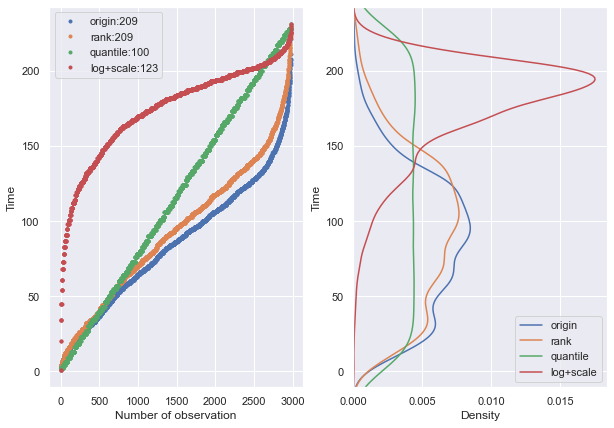

In [18]:
fig, axes = plt.subplots(figsize=(10, 7), ncols=2)
for scheme in ["origin", "rank", "quantile", "log+scale"]:
    y_new = y.copy()
    #y_new[np.argmax(y_new["time"] * y_new["cens"])]["time"] = 1000
    y_ = np.sort(bins_scheme(y_new["time"], scheme=scheme))
    axes[0].plot(y_, label=f"{scheme}:{np.unique(y_).shape[0]}", marker='o', markersize=3, linestyle="")
    
    sns.kdeplot(y=bins_scheme(y_new["time"], scheme=scheme), label=f"{scheme}", ax=axes[1])
axes[0].legend()
axes[0].set_xlabel("Number of observation")
axes[0].set_ylabel("Time")

axes[1].legend()
axes[1].set_ylabel("Time")


ymin, ymax = axes[0].get_ylim()
axes[1].set_ylim(ymin, ymax)

Text(0, 0.5, 'BS(Time)')

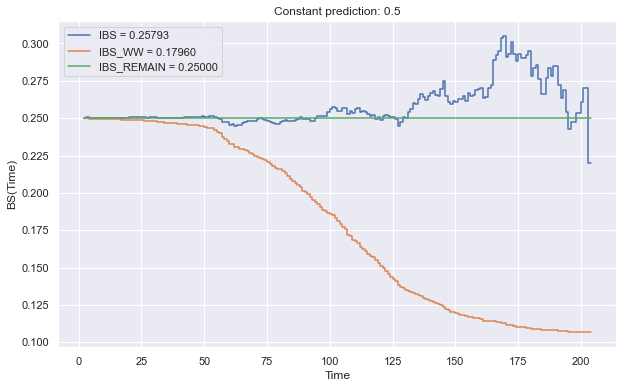

In [19]:
from survivors.experiments.grid import generate_sample
for X_tr, y_tr, X_HO, y_HO, bins in generate_sample(X, y, 5, "CV+HOLD-OUT"):
    pass

plt.figure(figsize=(10, 6))
for m in [ibs, ibs_WW, ibs_remain]:
    for i in [0]:#[0, 1000,  2000][::-1]:
        max_time = np.max(bins) + i
        y_HO_ = y_HO.copy()
        y_HO_[np.argmax(y_HO_["time"] * y_HO_["cens"])]["time"] = max_time
    #     y_HO_["cens"] = True
        bins_ = np.hstack([bins, max_time])
        ibs_all = m(y_tr, y_HO_, np.ones((y_HO_.shape[0], bins_.shape[0]))*0.5, bins_, axis=1)
        ibs_mean = m(y_tr, y_HO_, np.ones((y_HO_.shape[0], bins_.shape[0]))*0.5, bins_, axis=-1)

        #plt.fill_between(bins_, ibs_all, step="pre", alpha=0.3)
        plt.step(bins_, ibs_all,  label=f"{m.__name__.upper()} = {ibs_mean:.5f}") #label=f"max bins:{max_time}, ibs={ibs_mean:.5f}")
plt.legend()
plt.title(f"Constant prediction: 0.5")
plt.xlabel("Time")
plt.ylabel("BS(Time)")

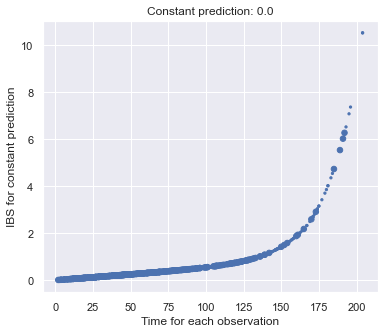

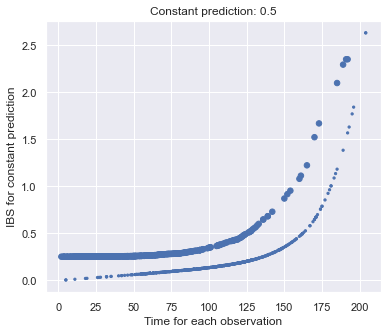

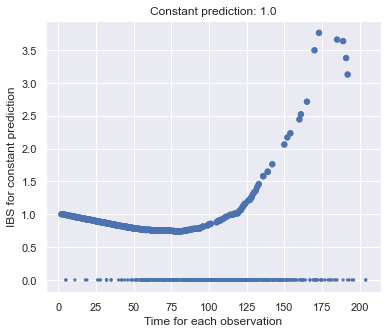

In [20]:
for cnt_p in [0.0, 0.5, 1.0]:
    plt.figure(figsize=(6, 5))
    for scheme in ["origin"]: # ["origin", "rank", "quantile", "log+scale"]:
        y_new = y.copy()
#         y_new[np.argmax(y_new["time"] * y_new["cens"])]["time"] = 1000
        y_new["time"] = bins_scheme(y_new["time"], scheme=scheme)
        for X_tr, y_tr, X_HO, y_HO, bins in generate_sample(X, y_new, 5, "CV+HOLD-OUT"):
            pass
        #bins = np.hstack([bins, bins[-1]*1.2])
        ibs_all = ibs(y_tr, y_HO, np.ones((y_HO.shape[0], bins.shape[0]))*cnt_p, bins, axis=-1)
        ibs_cnt_p = ibs(y_tr, y_HO, np.ones((y_HO.shape[0], bins.shape[0]))*cnt_p, bins, axis=0)
        plt.scatter(y_HO["time"], ibs_cnt_p, label=f"{scheme}:{ibs_all:.5f}", s=np.where(y_HO["cens"], 30, 5))
#     plt.legend()
    plt.title(f"Constant prediction: {cnt_p}")
    plt.xlabel("Time for each observation")
    plt.ylabel("IBS for constant prediction")
    plt.show()

In [770]:
y["time"] = bins_scheme(y["time"], scheme="rank")  # "rank"

In [21]:
from survivors.experiments.grid import generate_sample

# X_tr, y_tr, X_HO, y_HO, bins = next(generate_sample(X, y, 1, "HOLD-OUT"))

for X_tr, y_tr, X_HO, y_HO, bins in generate_sample(X, y, 5, "CV+HOLD-OUT"):
    pass

# y_tr[cnt.TIME_NAME] = np.clip(y_tr[cnt.TIME_NAME], bins.min() - 1, bins.max() + 1)
# y_HO[cnt.TIME_NAME] = np.clip(y_HO[cnt.TIME_NAME], bins.min(), bins.max())

In [22]:
from sksurv.ensemble import RandomSurvivalForest

# GBSG
# rsf_params = {'max_depth': None, 'min_samples_leaf': 10, 
#               'n_estimators': 50, 'random_state': 123}

# ONK
rsf_params = {'max_depth': None, 'min_samples_leaf': 20, 
              'n_estimators': 30, 'random_state': 123}

rsf = RandomSurvivalForest(**rsf_params)

X_tr_rsf = X_tr.fillna(0).replace(np.nan, 0)
X_HO_rsf = X_HO.fillna(0).replace(np.nan, 0)

rsf.fit(X_tr_rsf, y_tr)
survs = rsf.predict_survival_function(X_HO_rsf)
hazards = rsf.predict_cumulative_hazard_function(X_HO_rsf)

tr_survs = rsf.predict_survival_function(X_tr_rsf)
tr_pred_surv_rsf = np.array(list(map(lambda x: x(bins), tr_survs)))

pred_surv_rsf = np.array(list(map(lambda x: x(bins), survs)))
pred_haz_rsf = np.array(list(map(lambda x: x(bins), hazards)))
pred_time_rsf = -1*rsf.predict(X_HO_rsf)

In [1134]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

gb_params = {'learning_rate': 0.5, 'loss': 'coxph',  # 0.05 GBSG
             'max_depth': 20, 'max_features': 'sqrt', 
             'min_samples_leaf': 20, 'n_estimators': 100, 'random_state': 123}

gbsa = GradientBoostingSurvivalAnalysis(**gb_params)

X_tr_gb = X_tr.fillna(0).replace(np.nan, 0)
X_HO_gb = X_HO.fillna(0).replace(np.nan, 0)

gbsa.fit(X_tr_gb, y_tr)
survs = gbsa.predict_survival_function(X_HO_gb)
hazards = gbsa.predict_cumulative_hazard_function(X_HO_gb)

tr_survs = gbsa.predict_survival_function(X_tr_gb)
tr_pred_surv_gbsa = np.array(list(map(lambda x: x(bins), tr_survs)))

pred_surv_gbsa = np.array(list(map(lambda x: x(bins), survs)))
pred_haz_gbsa = np.array(list(map(lambda x: x(bins), hazards)))
pred_time_gbsa = -1*gbsa.predict(X_HO_gb)

In [342]:
d = pd.DataFrame(np.vstack([X_tr.columns, gbsa.feature_importances_]).T).sort_values(by=1)
d[d[1] > 0.01]

0         1
41                            Неспецифическое_лечение  0.010008
37     Лучевая_терапия_Первичной_опухоли_ложа_опухоли   0.01028
2                                                 Пол  0.010575
22                                    Лучевая_терапия  0.011937
29  Лекарственная_противоопухолевая_терапия_Первая...   0.01221
43                       Кол_во_Хирургическое_лечение  0.012927
64                     Кол_во_Неспецифическое_лечение  0.014382
20                              Хирургическое_лечение  0.014824
60  Кол_во_Лучевая_терапия_Первичной_опухоли_ложа_...  0.015171
6                                          Nodus_узлы  0.015845
30  Лекарственная_противоопухолевая_терапия_Вторая...  0.016338
23  Хирургическое_лечение_Первичной_опухоли_в_том_...  0.018029
45                             Кол_во_Лучевая_терапия  0.020406
53  Кол_во_Лекарственная_противоопухолевая_терапия...  0.031416
5                                       Tumor_опухоль  0.036087
7                                           Метастазы  0.044463
4                                              Стадия  0.045609
1                                                Рост  0.052727
19                                            Диагноз  0.060641
9                                        Индекс_массы  0.063126
0                                                 Вес  0.065076
3                                             Возраст  0.079582
52  Кол_во_Лекарственная_противоопухолевая_терапия...  0.095812
44     Кол_во_Лекарственная_противоопухолевая_терапия  0.145003

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\fitters\mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  for variable in self.params_.index & (columns or self.params_.index):
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 2264 total observations, 1913 right-censored observations>
         test_name = proportional_hazard_test

---
                                                                                                                                 test_statistic      p  -log2(p)
MTSTZ                                                                                                                      km              0.63   0.43      1.23
                                                                                                                           rank            0.54   0.46      1.11
Nodus_узлы                                                                                                                 km              6.58   0.01      6.60
                                                                                                                           rank           10.39 <0.005      9.62
Tumor_опухоль                                                                                                              km              0.28   0.60      0.74
                                                                                                                           rank            0.16   0.69      0.53
Вес                                                                                                                        km              2.08   0.15      2.74
                                                                                                                           rank            2.61   0.11      3.24
Возраст                                                                                                                    km              0.08   0.78      0.36
                                                                                                                           rank            0.90   0.34      1.54
Диагноз                                                                                                                    km              6.67   0.01      6.68
                                                                                                                           rank           12.28 <0.005     11.09
Диагностика                                                                                                                km              0.10   0.75      0.41
                                                                                                                           rank            0.19   0.66      0.59
Длительность_прошлой_нити                                                                                                  km              0.91   0.34      1.55
                                                                                                                           rank            2.28   0.13      2.94
Дни_между_прошлой_нитью                                                                                                    km              0.00   0.96      0.05
                                                                                                                           rank            0.02   0.89      0.17
Дни_между_прошлым_посещением                                                                                               km              0.00   0.95      0.07
                                                                                                                           rank            0.00   1.00      0.00
Индекс_массы                                                                                                               km              2.25   0.13      2.90
                                                                                                                           rank            2.39   0.12      3.03
Кол_во_Лекарственн



1. Variable 'Nodus_узлы' failed the non-proportional test: p-value is 0.0013.

   Advice: with so few unique values (only 4), you can include `strata=['Nodus_узлы', ...]` in the
call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


2. Variable 'Метастазы' failed the non-proportional test: p-value is 0.0005.

   Advice: with so few unique values (only 2), you can include `strata=['Метастазы', ...]` in the
call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


3. Variable 'Диагноз' failed the non-proportional test: p-value is 0.0005.

   Advice: with so few unique values (only 3), you can include `strata=['Диагноз', ...]` in the call
in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


4. Variable 'Лекарственная_противоопухолевая_терапия_Третья_линия' failed the non-proportional test: p-value is 0.0022.

   Advice: with so few uniq

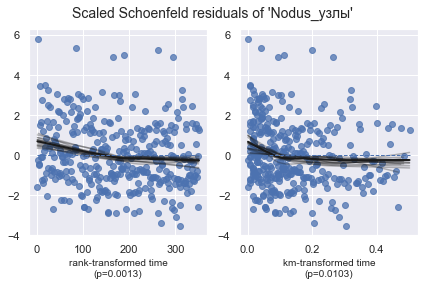

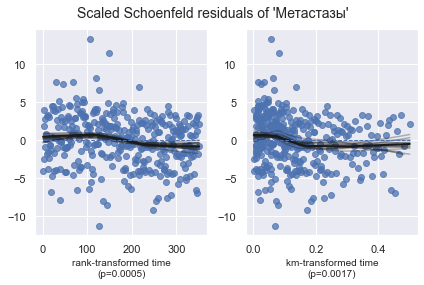

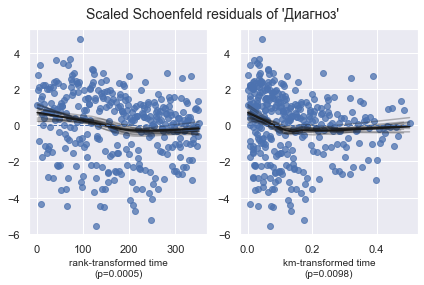

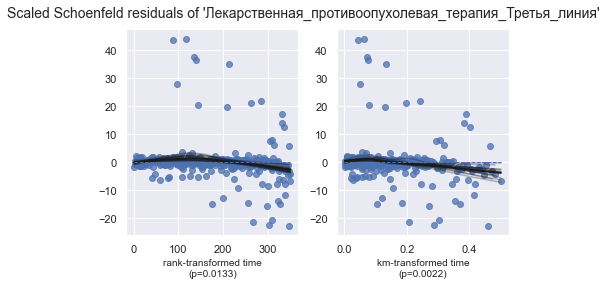

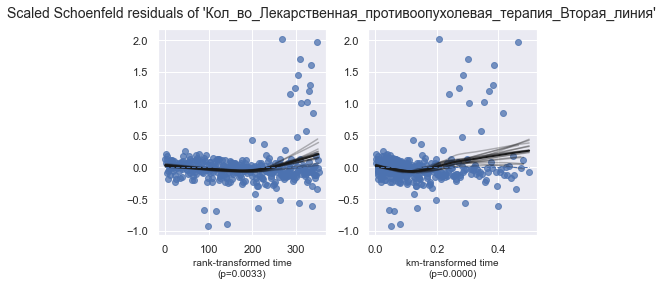

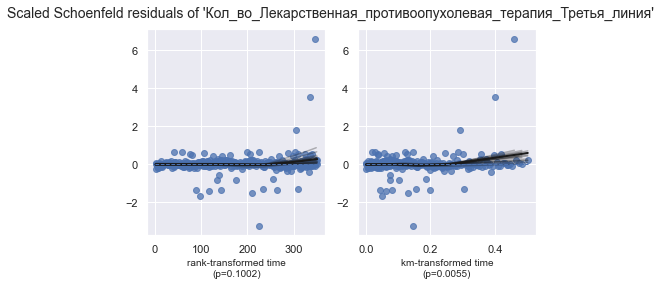

In [343]:
from lifelines import CoxPHFitter

new_features = [f for f in features if f not in bad_features]
df_tr_gb = X_tr_gb[new_features].copy()
df_tr_gb[cnt.TIME_NAME] = y_tr[cnt.TIME_NAME]
df_tr_gb[cnt.CENS_NAME] = y_tr[cnt.CENS_NAME]

cph = CoxPHFitter().fit(df_tr_gb, 'time', 'cens')

axes = cph.check_assumptions(df_tr_gb, show_plots=True)

In [ ]:
from sklearn.model_selection import ParameterGrid

short = False
# BOOST_param_grid = {
#     "size_sample": [0.9],  # [0.5, 0.7],
#     "n_estimators": [30],  # old [30]
#     "ens_metric_name": ["ibs"] if short else ["bic", "ibs"],  # ["roc", "ibs"],  # ["conc", "ibs"]
#     "depth": [10] if short else [15],  # new [5]
#     "criterion": ["confident", "logrank"] if short else ["confident", "weights", "peto",
#                                                          "tarone-ware", "wilcoxon", "logrank"],
#     "min_samples_leaf": [5] if short else [5],  # [20, 100]
#     "max_features": [0.4] if short else [0.7, 0.9],  # [0.2, 0.5],
#     "aggreg_func": ['wei'] if short else ['wei'],
#     "leaf_model": ["base_fast"] if short else ["base_fast"],
#     "all_weight": [True, False],
#     "balance": [None, "balance", "only_log_rank"],
#     "with_arc": [True, False],
#     "n_jobs": [1]
# }

CRAID_param_grid = {
    "depth": [10],
    "balance": [None, "balance", "balance+correct", "only_log_rank"],  # "balance+weights",
    "criterion": ["peto"] if short else ["confident", "peto", "tarone-ware", "wilcoxon", "logrank"],
    "min_samples_leaf": [10] if short else [5, 50],
    'cut': [False, True],
    "woe": [True],  # if short else [True, False],
    "signif": [0.05] if short else [0.05, 1.0],
    "max_features": [1.0],
    "n_jobs": [40]
}

grid_params = ParameterGrid(CRAID_param_grid)
p_size = len(grid_params)
for i_p, p in enumerate(grid_params):
    print(i_p, "="*10, p)

In [1135]:
# proboost_params = {'balance': None,
#  'with_arc': False, 'aggreg_func': 'wei', 'all_weight': False, 
#  'categ': categ, 
#  'criterion': 'confident', 'depth': 10, 'ens_metric_name': 'ibs', 
#  'leaf_model': 'base_fast', 'max_features': 'sqrt', 'min_samples_leaf': 5, 
#  'n_estimators': 100, 'n_jobs': 2, 'size_sample': 0.5}

# proboost_params = {
#  'balance': None, 
#  "with_arc": False,
#  'aggreg_func': 'wei', 'all_weight': False, 'categ': ['Диагноз'], 
#  'criterion': 'logrank', 'depth': 10, 'ens_metric_name': 'bic', 
#  'leaf_model': 'wei_survive', 'max_features': 0.7, 'min_samples_leaf': 5, 
#  'n_estimators': 300, 'n_jobs': 2, 'size_sample': 0.7
# }

# proboost_params = {
#  'balance': None, 
#  "with_arc": False,
#  'aggreg_func': 'wei', 'all_weight': True, 'categ': categ,
#  'criterion': 'logrank', 'depth': 5, 'ens_metric_name': 'ibs', 
#  'leaf_model': 'base_fast', 'max_features': "sqrt", 'min_samples_leaf': 10, 
#  'n_estimators': 10, 'n_jobs': 2, 'size_sample': 0.7
# }
# TEST PR: 0.16174314512976404

# proboost_params = {
#  'balance': None, 
#  "with_arc": False,
#  'aggreg_func': 'wei', 'all_weight': False, 'categ': categ,
#  'criterion': 'logrank', 'depth': 10, 'ens_metric_name': 'ibs', 
#  'leaf_model': 'base_fast', 'max_features': "sqrt", 'min_samples_leaf': 10, 
#  'n_estimators': 30, 'n_jobs': 2, 'size_sample': 0.7
# }
# TEST PR: 0.16437608076688845

# proboost_params = {'balance': None, 
#                    "with_arc": False,
#                    'aggreg_func': 'wei', 'all_weight': True, 'categ': ['Диагноз'], 
#                    'criterion': 'logrank', 'depth': 20, 'ens_metric_name': 'conc', 
#                    'leaf_model': 'base_fast', 'max_features': 0.7, 'min_samples_leaf': 20, 
#                    'n_estimators': 100, 'n_jobs': 2, 'size_sample': 0.7}

# ONK RANDOM PROBOOST
proboost_params = {'balance': "balance", 
                   "with_arc": False,
                   'aggreg_func': 'wei', 'all_weight': True, 'categ': ['Диагноз'], 
                   'criterion': 'confidence', 'depth': 20, 'ens_metric_name': 'conc', 
                   'leaf_model': 'base_fast', 'max_features': 0.7, 'min_samples_leaf': 20, 
                   'n_estimators': 30, 'n_jobs': 2, 'size_sample': 0.7}

# # GBSG RANDOM PROBOOST
# proboost_params = {'balance': None, 'with_arc': True, 'aggreg_func': 'wei', 
#                    'all_weight': False, 'categ': ['htreat', 'menostat', 'tumgrad'], 
#                    'criterion': 'confident', 'depth': 10, 'ens_metric_name': 'conc', 'leaf_model': 'base_fast', 
#                    'max_features': 0.5, 'min_samples_leaf': 20, 'n_estimators': 30, 'n_jobs': 2, 'size_sample': 0.5}

start_time = time.time()
proboost = ProbBoostingCRAID(**proboost_params)
proboost.fit(X_tr, y_tr)

print(time.time() - start_time)

[0.8289 0.8293 0.8339 0.836  0.8392 0.8468 0.8471 0.8494 0.8507 0.8501
 0.8516 0.8519 0.8531 0.8544 0.8542 0.855  0.8539 0.8551 0.8544 0.8561
 0.8564 0.8583 0.8583 0.8591 0.8594 0.8588 0.8584 0.8587 0.8592 0.8593]
fitted: 25 models.
77.63842701911926


In [1136]:
# proboost.models[0].visualize()

Prior distribution: [1913  351]


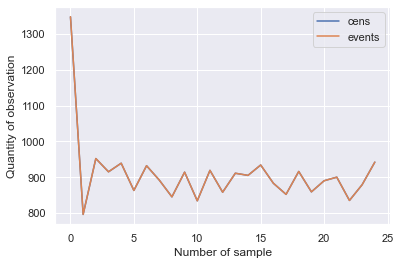

In [1137]:
print("Prior distribution:", np.bincount(y_tr["cens"]))
n_cens = []
n_events = []
for i in range(len(proboost.models)):
    distr = np.bincount(proboost.models[i].nodes[0].leaf_model.predict_list_feature(feature_name="cens"))
    n_cens.append(distr[0])
    n_events.append(distr[1])

plt.plot(n_cens, label="cens")
plt.plot(n_events, label="events")
plt.legend()
plt.ylabel("Quantity of observation")
plt.xlabel("Number of sample")
plt.show()

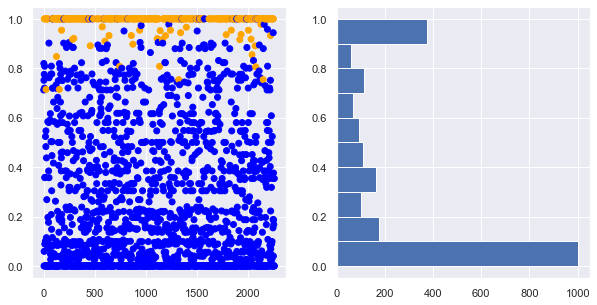

In [1138]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
axes[0].scatter(np.arange(proboost.weights.shape[0]), 
                proboost.weights,
                c = np.where(proboost.y_train["cens"], "orange", "blue"))
axes[1].hist(proboost.weights, orientation="horizontal")
plt.show()

In [535]:
# HISTOGRAMS OF OBSERVATIONS WITH SMALL WEIGHTS

# y_tr_cens_counts = np.bincount(y_tr["cens"])
# y_bad_cens_counts = np.bincount(y_tr[proboost.weights > 0.9]["cens"])

# plt.hist(y_tr["time"], label=f"{y_tr_cens_counts}")
# plt.hist(y_tr[proboost.weights > 0.9]["time"], label=f"{y_bad_cens_counts}")
# plt.legend()

In [536]:
# SCATTER WEIGHTS OVER TIME

# for i in range(len(proboost.l_weights[:10])):
#     plt.figure(figsize=(14, 7))
#     plt.scatter(range(w.shape[0]), proboost.l_weights[i+1], alpha=0.5, label="new")
#     plt.scatter(range(w.shape[0]), proboost.l_weights[i], alpha=0.5, label="old")
#     plt.legend()
#     plt.show()

In [537]:
# # pred_bettas = proboost.bettas.copy()
# proboost.bettas = pred_bettas.copy()
# proboost.bettas = proboost.bettas - np.linspace(0, 3000, len(proboost.bettas))

In [538]:
# proboost.bettas

In [539]:
# WEIGHTS OF TREES IN ENSEMBLE

# inv_wei = np.array(proboost.bettas)
# plt.plot(inv_wei/sum(inv_wei))

In [1144]:
tr_pred_surv_proboost = proboost.predict_at_times(X_tr, bins=bins, mode="surv")

pred_surv_proboost = proboost.predict_at_times(X_HO, bins=bins, mode="surv")
pred_time_proboost = proboost.predict(X_HO, target=cnt.TIME_NAME)
pred_haz_proboost = proboost.predict_at_times(X_HO, bins=bins, mode="hazard")

In [1145]:
# pred_surv_gbsa = np.hstack([pred_surv_gbsa] + [pred_surv_gbsa[:, -1][np.newaxis,:].T]*(2000 - pred_surv_gbsa.shape[1]))
# pred_surv_rsf = np.hstack([pred_surv_rsf] + [pred_surv_rsf[:, -1][np.newaxis,:].T]*(2000 - pred_surv_rsf.shape[1]))

In [1149]:
for m in [kl, loglikelihood]:
    print("METRIC:", m.__name__)
    print("TEST RSF:", m(y_HO["time"], y_HO["cens"], pred_surv_rsf, pred_haz_rsf, bins))
    print("TEST GBSA:", m(y_HO["time"], y_HO["cens"], pred_surv_gbsa, pred_haz_gbsa, bins))
    print("TEST PROBOOST:", m(y_HO["time"], y_HO["cens"], pred_surv_proboost, pred_haz_proboost, bins))

METRIC: kl
TEST RSF: 13618.896412623553
TEST GBSA: 6554.103576408809
TEST PROBOOST: 7636.225618006067
METRIC: loglikelihood
TEST RSF: -2690.051871526433
TEST GBSA: -2664.9071292332205
TEST PROBOOST: -3256.159992509286


In [1150]:
# print("TRAIN RSF:", metr.ibs(y_tr, y_tr, tr_pred_surv_rsf, bins, axis=-1))
# print("TRAIN GB:", metr.ibs(y_tr, y_tr, tr_pred_surv_gbsa, bins, axis=-1))
# print("TRAIN PR:", metr.ibs(y_tr, y_tr, tr_pred_surv_proboost, bins, axis=-1))
# print()
# print("TEST RSF:", metr.ibs(y_tr, y_HO, pred_surv_rsf, bins, axis=-1))
# print("TEST GB:", metr.ibs(y_tr, y_HO, pred_surv_gbsa, bins, axis=-1))
# print("TEST PR:", metr.ibs(y_tr, y_HO, pred_surv_proboost, bins, axis=-1))

for m in ibs_list:
    print(f"METRIC: {m.__name__}")
#     print("TRAIN RSF:", m(y_tr, y_tr, tr_pred_surv_rsf, bins, axis=-1))
#     print("TRAIN GB:", m(y_tr, y_tr, tr_pred_surv_gbsa, bins, axis=-1))
#     print("TRAIN PR:", m(y_tr, y_tr, tr_pred_surv_proboost, bins, axis=-1))
    print(f"TEST RSF:{m(y_tr, y_HO, pred_surv_rsf, bins, axis=-1):.5f}")
    print(f"TEST GB:{m(y_tr, y_HO, pred_surv_gbsa, bins, axis=-1):.5f}")
    print(f"TEST PR:{m(y_tr, y_HO, pred_surv_proboost, bins, axis=-1):.5f}")

ibs_gbsa_obs = metr.ibs(y_tr, y_HO, pred_surv_gbsa, bins, axis=0)
ibs_proboost_obs = metr.ibs(y_tr, y_HO, pred_surv_proboost, bins, axis=0)

ibs_WW_gbsa_obs = ibs_WW(y_tr, y_HO, pred_surv_gbsa, bins, axis=0)
ibs_WW_proboost_obs = ibs_WW(y_tr, y_HO, pred_surv_proboost, bins, axis=0)

METRIC: ibs
TEST RSF:0.15612
TEST GB:0.11513
TEST PR:0.12211
METRIC: bal_ibs
TEST RSF:0.81149
TEST GB:0.54503
TEST PR:0.47517
METRIC: ibs_WW
TEST RSF:0.04921
TEST GB:0.02665
TEST PR:0.02707
METRIC: bal_ibs_WW
TEST RSF:0.29661
TEST GB:0.15280
TEST PR:0.13166


In [543]:
# def ibs_equals(survival_train, survival_test, estimate, times, axis=-1):
#     times_less = list(set(survival_train['time']) | set(survival_test['time']))
#     times_less = np.digitize(times_less, times)
#     survival_test["time"] = np.digitize(survival_test["time"], times_less)
#     survival_train["time"] = np.digitize(survival_train["time"], times_less)
#     return metr.ibs(survival_train, survival_test, estimate[:, times_less], times_less, axis=axis)

# print("TEST RSF:", ibs_equals(y_tr, y_HO, pred_surv_rsf, bins, axis=-1))
# print("TEST GB:", ibs_equals(y_tr, y_HO, pred_surv_gbsa, bins, axis=-1))
# print("TEST PR:", ibs_equals(y_tr, y_HO, pred_surv_proboost, bins, axis=-1))

In [544]:
# bins_r = np.array([1, 10, 50, 100, 600])
# print("TEST RSF:", metr.ibs(y_tr, y_HO, pred_surv_rsf[:, bins_r], bins_r, axis=-1))
# print("TEST GB:", metr.ibs(y_tr, y_HO, pred_surv_gbsa[:, bins_r], bins_r, axis=-1))
# print("TEST PR:", metr.ibs(y_tr, y_HO, pred_surv_proboost[:, bins_r], bins_r, axis=-1))

In [176]:
for p in [pred_surv_proboost, pred_surv_gbsa]:
    test_ibs = metr.ibs(y_tr, y_HO, p, bins, axis=0)
    srt_idx = np.argsort(test_ibs)
    print(test_ibs[srt_idx[::-1][:10]], y_HO[srt_idx[::-1][:10]])

[0.65812414 0.58207653 0.56107834 0.52044081 0.51916801 0.49870567
 0.49528494 0.49119289 0.4751554  0.45995266] [( True, 560.) ( True,  33.) (False, 522.) (False, 517.) ( True,  69.)
 ( True,  83.) ( True,  79.) ( True, 554.) ( True, 139.) (False, 532.)]
[1.08509621 0.80388346 0.54507546 0.5293541  0.52793665 0.51677952
 0.49250024 0.47202563 0.43389635 0.43010129] [( True, 560.) (False, 517.) ( True,  69.) ( True,  33.) ( True, 139.)
 (False, 522.) ( True, 554.) ( True,  83.) ( True,  79.) ( True,  18.)]


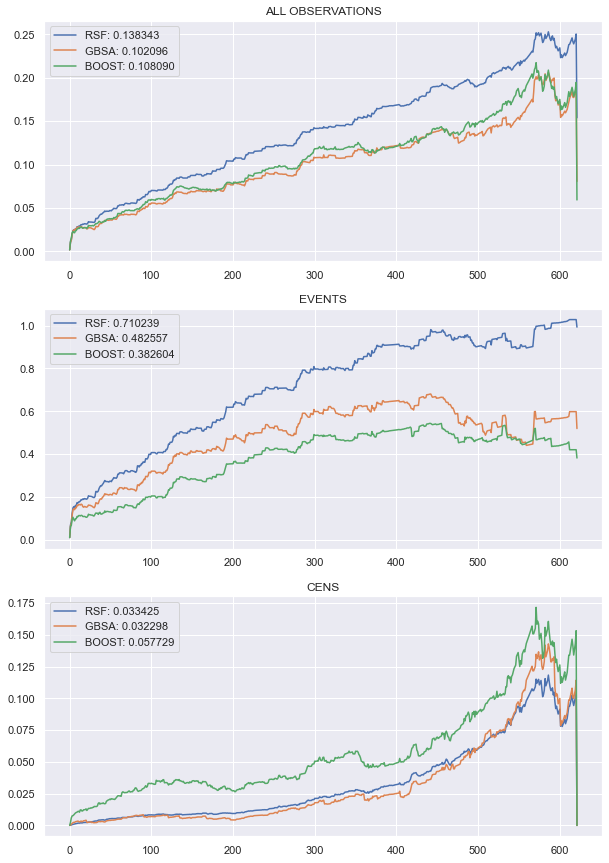

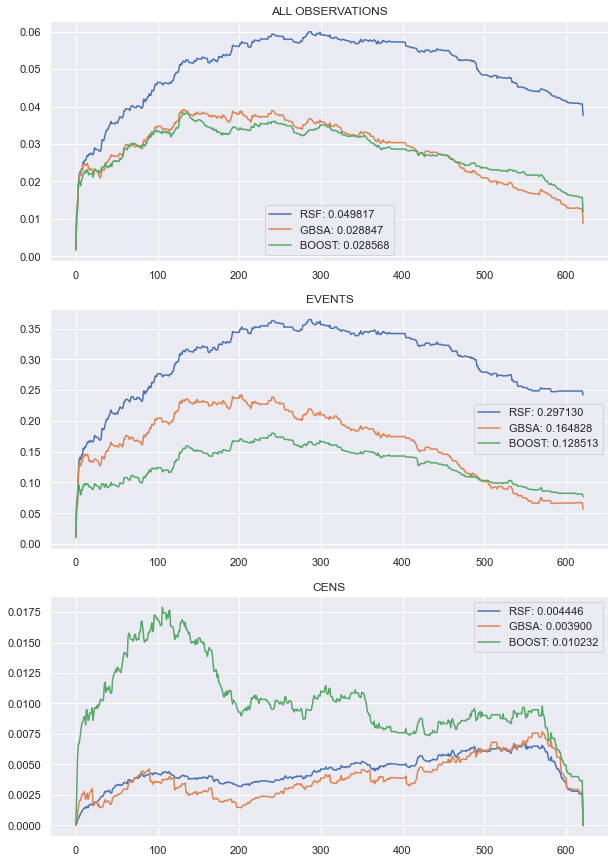

In [814]:
def plot_all_ibs(survival_train, survival_test, preds, labels, bins, metric, axis=1):
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))
    for p, l in zip(preds, labels):
        ibs_val = metric(survival_train, survival_test, p, bins, -1)
        axes[0].plot(metric(survival_train, survival_test, p, bins, axis), label=f"{l}: {ibs_val:.6f}")
    axes[0].legend()
    axes[0].set_title("ALL OBSERVATIONS")
    
    for p, l in zip(preds, labels):
        ibs_val = metric(survival_train, survival_test[survival_test["cens"]], 
                           p[survival_test["cens"]], bins, -1)
        axes[1].plot(metric(survival_train, survival_test[survival_test["cens"]], 
                              p[survival_test["cens"]], bins, axis), label=f"{l}: {ibs_val:.6f}")
    axes[1].legend()
    axes[1].set_title("EVENTS")
    
    for p, l in zip(preds, labels):
        ibs_val = metric(survival_train, survival_test[~survival_test["cens"]], 
                           p[~survival_test["cens"]], bins, -1)
        axes[2].plot(metric(survival_train, survival_test[~survival_test["cens"]], 
                              p[~survival_test["cens"]], bins, axis), label=f"{l}: {ibs_val:.6f}")
    axes[2].legend()
    axes[2].set_title("CENS")
    plt.show()
    
for m in [ibs, ibs_WW]:
    plot_all_ibs(y_tr, y_HO, 
                 [pred_surv_rsf, pred_surv_gbsa, pred_surv_proboost], 
                 ["RSF", "GBSA", "BOOST"],
                 bins, 
                 m,
                 axis=1)

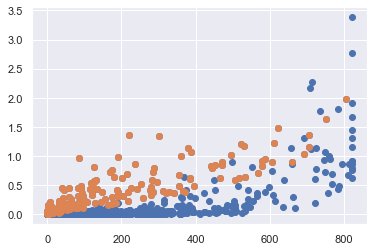

In [496]:
# plt.plot(metr.ibs(y_tr, y_tr, tr_pred_surv_proboost, bins, axis=1))
# plt.plot(metr.ibs(y_tr, y_tr, tr_pred_surv_gbsa, bins, axis=1))

plt.scatter(y_HO["time"], metr.ibs(y_tr, y_HO, pred_surv_proboost, bins, axis=0))
plt.scatter(y_HO[y_HO["cens"]]["time"], metr.ibs(y_tr, y_HO[y_HO["cens"]], pred_surv_proboost[y_HO["cens"]], bins, axis=0))

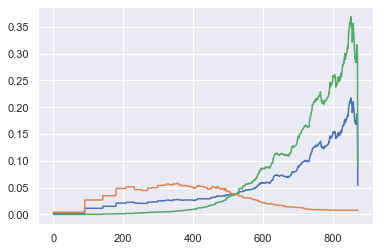

In [569]:
plt.plot(metr.ibs(y_tr, y_HO, pred_surv_proboost, bins, axis=1))
plt.plot(metr.ibs(y_tr, y_HO[y_HO["time"] < 500], pred_surv_proboost[y_HO["time"] < 500], bins, axis=1))
plt.plot(metr.ibs(y_tr, y_HO[y_HO["time"] > 500], pred_surv_proboost[y_HO["time"] > 500], bins, axis=1))
#plt.plot(metr.ibs(y_tr, y_HO, np.ones_like(pred_surv_proboost)*0.5, bins, axis=1))

In [725]:
# print("EVENT TRAIN GB:", metr.ibs(y_tr, y_tr[y_tr["cens"]], tr_pred_surv_gbsa[y_tr["cens"]], bins, axis=-1))
# print("CENS TRAIN GB:", metr.ibs(y_tr, y_tr[~y_tr["cens"]], tr_pred_surv_gbsa[~y_tr["cens"]], bins, axis=-1))
# print()
# print("EVENT TRAIN PR:", metr.ibs(y_tr, y_tr[y_tr["cens"]], tr_pred_surv_proboost[y_tr["cens"]], bins, axis=-1))
# print("CENS TRAIN PR:", metr.ibs(y_tr, y_tr[~y_tr["cens"]], tr_pred_surv_proboost[~y_tr["cens"]], bins, axis=-1))
# print()
print("EVENT TEST RSF:", metr.ibs(y_tr, y_HO[y_HO["cens"]], pred_surv_rsf[y_HO["cens"]], bins, axis=-1))
print("CENS TEST RSF:", metr.ibs(y_tr, y_HO[~y_HO["cens"]], pred_surv_rsf[~y_HO["cens"]], bins, axis=-1))
print()
print("EVENT TEST GB:", metr.ibs(y_tr, y_HO[y_HO["cens"]], pred_surv_gbsa[y_HO["cens"]], bins, axis=-1))
print("CENS TEST GB:", metr.ibs(y_tr, y_HO[~y_HO["cens"]], pred_surv_gbsa[~y_HO["cens"]], bins, axis=-1))
print()
print("EVENT TEST PR:", metr.ibs(y_tr, y_HO[y_HO["cens"]], pred_surv_proboost[y_HO["cens"]], bins, axis=-1))
print("CENS TEST PR:", metr.ibs(y_tr, y_HO[~y_HO["cens"]], pred_surv_proboost[~y_HO["cens"]], bins, axis=-1))

EVENT TEST RSF: 0.7102386819415012
CENS TEST RSF: 0.033424881715724906

EVENT TEST GB: 0.48255741525497664
CENS TEST GB: 0.03229787785239551

EVENT TEST PR: 0.3826041008600706
CENS TEST PR: 0.05772864329271654


In [726]:
def mean_harm(x, y):
    return (x+y)#2/(1/x + 1/y)

In [727]:
# print("TRAIN GB:", mean_harm(metr.ibs(y_tr, y_tr[y_tr["cens"]], tr_pred_surv_gbsa[y_tr["cens"]], bins, axis=-1), 
#                              metr.ibs(y_tr, y_tr[~y_tr["cens"]], tr_pred_surv_gbsa[~y_tr["cens"]], bins, axis=-1)))

# print("TRAIN PR:", mean_harm(metr.ibs(y_tr, y_tr[y_tr["cens"]], tr_pred_surv_proboost[y_tr["cens"]], bins, axis=-1), 
#       metr.ibs(y_tr, y_tr[~y_tr["cens"]], tr_pred_surv_proboost[~y_tr["cens"]], bins, axis=-1)))

print("TEST RSF:", mean_harm(metr.ibs(y_tr, y_HO[y_HO["cens"]], pred_surv_rsf[y_HO["cens"]], bins, axis=-1), 
      metr.ibs(y_tr, y_HO[~y_HO["cens"]], pred_surv_rsf[~y_HO["cens"]], bins, axis=-1)))

print("TEST GB:", mean_harm(metr.ibs(y_tr, y_HO[y_HO["cens"]], pred_surv_gbsa[y_HO["cens"]], bins, axis=-1), 
      metr.ibs(y_tr, y_HO[~y_HO["cens"]], pred_surv_gbsa[~y_HO["cens"]], bins, axis=-1)))

print("TEST PR:", mean_harm(metr.ibs(y_tr, y_HO[y_HO["cens"]], pred_surv_proboost[y_HO["cens"]], bins, axis=-1), 
                  metr.ibs(y_tr, y_HO[~y_HO["cens"]], pred_surv_proboost[~y_HO["cens"]], bins, axis=-1)))

TEST RSF: 0.7436635636572261
TEST GB: 0.5148552931073721
TEST PR: 0.4403327441527871


In [168]:
def balance_ibs(survival_train, survival_test, *args, **kwargs):
    survival_test = survival_test.copy()
    survival_test["cens"] = 1
    ibs_event = metr.ibs(survival_train, survival_test, *args, **kwargs)
    survival_test["cens"] = 0
    ibs_cens = metr.ibs(survival_train, survival_test, *args, **kwargs)
    print(ibs_event, ibs_cens)
    return (ibs_event + ibs_cens)/2

In [5494]:
print("TRAIN GB:", balance_ibs(y_tr, y_tr.copy(), tr_pred_surv_gbsa, bins, axis=-1))
print("TRAIN PR:", balance_ibs(y_tr, y_tr.copy(), tr_pred_surv_proboost, bins, axis=-1))

print("TEST GB:", balance_ibs(y_tr, y_HO, pred_surv_gbsa, bins, axis=-1))
print("TEST PR:", balance_ibs(y_tr, y_HO, pred_surv_proboost, bins, axis=-1))

0.270288916009449 0.06171882053514758
TRAIN GB: 0.1660038682722983
0.28196730647964635 0.06696896691862746
TRAIN PR: 0.1744681366991369
0.29725846031546777 0.0780350727928604
TEST GB: 0.18764676655416407
0.2983888239396851 0.07684307475654373
TEST PR: 0.1876159493481144


(-1.0, 6.0)

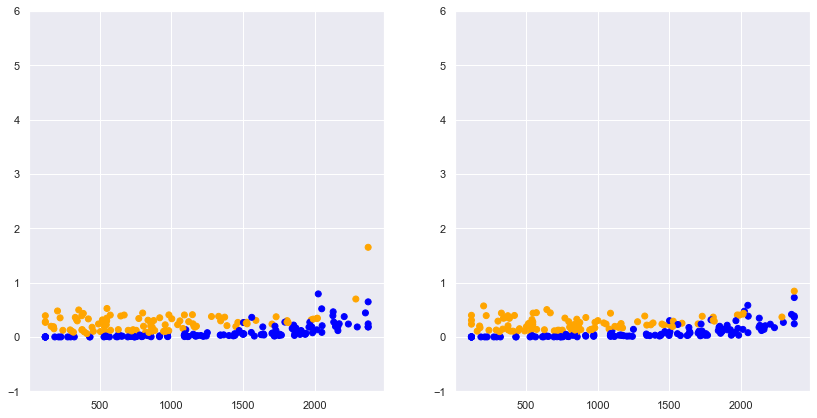

In [5737]:
fig, axes = plt.subplots(figsize=(14, 7), ncols=2)
axes[0].scatter(y_HO["time"], ibs_gbsa_obs, 
            c=np.where(y_HO["cens"], "orange", "blue"))

axes[1].scatter(y_HO["time"], ibs_proboost_obs, 
            c=np.where(y_HO["cens"], "orange", "blue"))

axes[0].set_ylim([-1, 6])
axes[1].set_ylim([-1, 6])

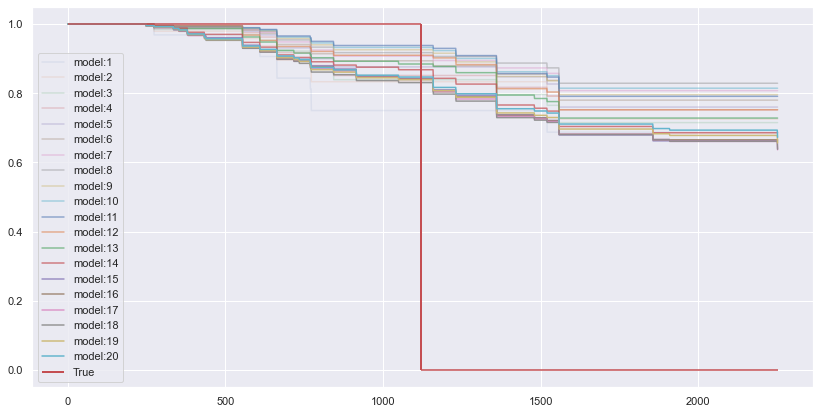

In [1655]:
glob_numb = 25

fig, ax = plt.subplots(figsize=(14, 7))
shared_pred = proboost.models[0].predict_at_times(X_HO, bins=bins, mode="surv")
for i in range(1, 21):
    pred = proboost.models[i].predict_at_times(X_HO, bins=bins, mode="surv")
    shared_pred += pred
#     ax.plot(pred[glob_numb], label = f"model:{i}")
    ax.plot(shared_pred[glob_numb]/(i+1), label = f"model:{i}", alpha=((i+1)/21))

ax.hlines(1.0, 0, y_HO[glob_numb]["time"], color = 'r')
ax.hlines(0.0, y_HO[glob_numb]["time"], len(shared_pred[glob_numb]), color = 'r')
ax.vlines(y_HO[glob_numb]["time"], 0, 1, 
              color = 'r', 
              linestyles = ('solid' if y_HO[glob_numb]["cens"] else 'dashed'),
              linewidth = 2, 
              label = "True")








ax.legend()
plt.show()

In [658]:
import matplotlib.pyplot as plt

def print_true_pred(y_true, y_preds, labels):
    fig, ax = plt.subplots()
    
    for y_pred, label in zip(y_preds, labels):
        ax.plot(y_pred, label = label)
    ax.hlines(1.0, 0, y_true["time"], color = 'r')
    ax.hlines(0.0, y_true["time"], len(y_preds[0]), color = 'r')
    ax.vlines(y_true["time"], 0, 1, 
                  color = 'r', 
                  linestyles = ('solid' if y_true["cens"] else 'dashed'),
                  linewidth = 2, 
                  label = "True")
    ax.legend()
    plt.show()

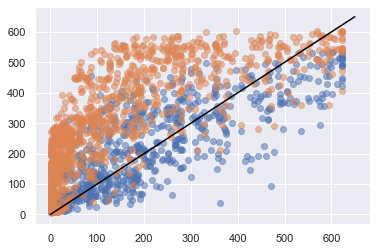

In [792]:
plt.scatter(y_HO["time"], pred_time_proboost, alpha=0.5)
# new_pr_time_proboost = np.trapz(pred_surv_proboost, bins)
# plt.scatter(y_HO["time"], new_pr_time_proboost, alpha=0.5)
new_pr_time_gbsa_int = np.trapz(pred_surv_gbsa, bins)
# new_pr_time_gbsa_05 = bins[list(map(lambda x: x.shape[0] - np.searchsorted(x[::-1], 0.5) - 1, pred_surv_gbsa))]
plt.scatter(y_HO["time"], new_pr_time_gbsa_int, alpha=0.5)
# plt.scatter(y_HO["time"], new_pr_time_gbsa_05, alpha=0.5)
plt.plot([0, 650], [0, 650], color="black")

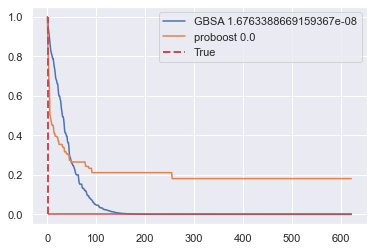

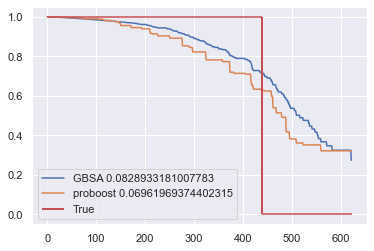

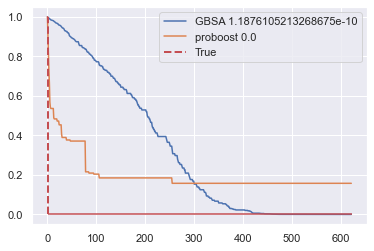

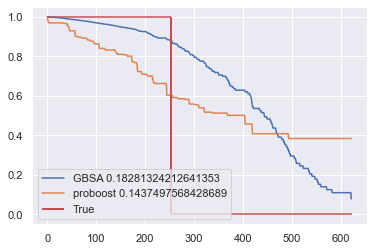

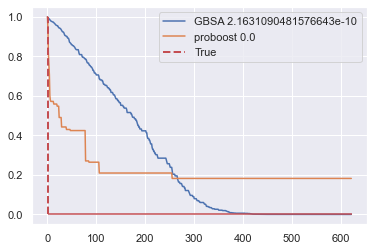

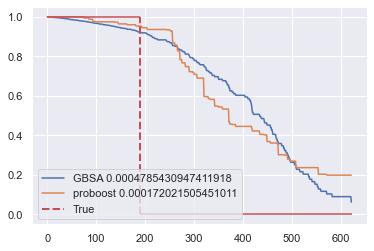

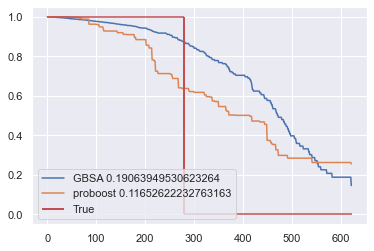

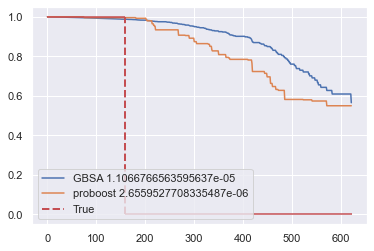

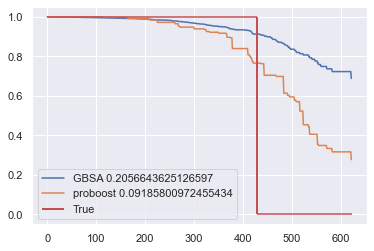

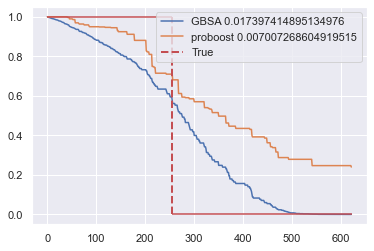

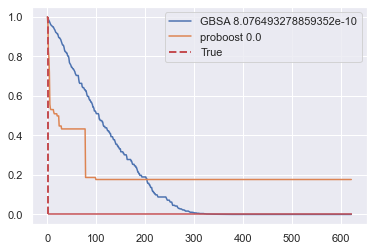

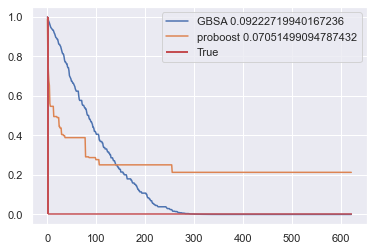

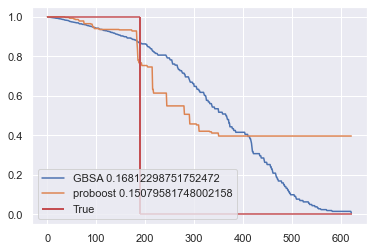

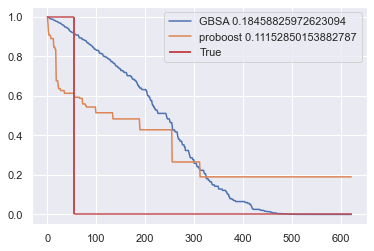

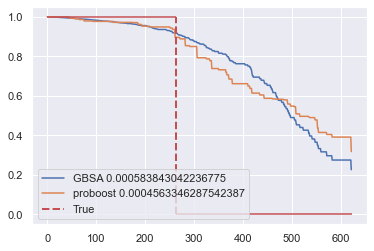

In [815]:

for i in np.where(ibs_WW_proboost_obs < ibs_WW_gbsa_obs)[0][:15]:#[0, 1, 10, 25, 100, 262]:
    print_true_pred(y_HO[i], 
                    [pred_surv_gbsa[i], 
                     pred_surv_proboost[i]],
                    [f"GBSA {ibs_WW_gbsa_obs[i]}", 
                     f"proboost {ibs_WW_proboost_obs[i]}"])

#### Выводы

1. ibs ниже для 'all_weight': True (до 0.125+)
2. Веса моделей без зависимостей
3. Веса наблюдений почти одинаковы
4. При искусственной регуляризации на поздние деревья прогноз не меняется.
5. Не может обучиться на тренировочной (на самих событиях)
6. BEST PROBOOST: 

   {'aggreg_func': 'wei', 'all_weight': True, 'categ': ['Диагноз'], 
    'criterion': 'peto', 'depth': 10, 'ens_metric_name': 'ibs', 
    'leaf_model': 'base_fast', 'max_features': 0.7, 'min_samples_leaf': 10, 
    'n_estimators': 200, 'n_jobs': 2, 'size_sample': 0.7}

TRAIN GB: 0.040758365855872156

TRAIN PR: 0.07876184911209028

TEST GB: 0.11512669052794938

TEST PR: 0.12589051411686047

6. Самые важные по gbsa (>0.05): ['Вес', 'Рост', 'Возраст', 'Индекс_массы', 'Диагноз',
    'Кол_во_Лекарственная_противоопухолевая_терапия',
    'Кол_во_Лекарственная_противоопухолевая_терапия_Первая_линия']

In [480]:
# gbsa.feature_importances_[np.argsort(gbsa.feature_importances_)[::-1]]
X_tr.columns[gbsa.feature_importances_ > 0.05]

Index(['Вес', 'Рост', 'Возраст', 'Индекс_массы', 'Диагноз',
       'Кол_во_Лекарственная_противоопухолевая_терапия',
       'Кол_во_Лекарственная_противоопухолевая_терапия_Первая_линия'],
      dtype='object')

### Best hyperparameters

In [ ]:
# ProbBoostingCRAID PARAMETERS (ONK)

proboost_params = {'balance': "balance", 
                   "with_arc": False,
                   'aggreg_func': 'wei', 'all_weight': True, 'categ': ['Диагноз'], 
                   'criterion': 'confidence', 'depth': 20, 'ens_metric_name': 'conc', 
                   'leaf_model': 'base_fast', 'max_features': 0.7, 'min_samples_leaf': 20, 
                   'n_estimators': 30, 'n_jobs': 2, 'size_sample': 0.7}

# TEST PR: 0.1221077

# ProbBoostingCRAID PARAMETERS (ONK)
proboost_params = {'balance': None, 
                   "with_arc": False,
                   'aggreg_func': 'wei', 'all_weight': True, 'categ': ['Диагноз'], 
                   'criterion': 'confidence', 'depth': 20, 'ens_metric_name': 'conc', 
                   'leaf_model': 'base_fast', 'max_features': 0.7, 'min_samples_leaf': 20, 
                   'n_estimators': 30, 'n_jobs': 2, 'size_sample': 0.7}

# TEST PR: 0.12249263197944195


# ProbBoostingCRAID (strong GBSG)
proboost_params = {'balance': None,
                   'with_arc': False,
                   'aggreg_func': 'wei', 'all_weight': False, 'categ': ['htreat', 'menostat', 'tumgrad'], 
                   'criterion': 'peto', 'depth': 10, 'ens_metric_name': 'ibs', 
                   'leaf_model': 'base_fast', 'max_features': "sqrt", 'min_samples_leaf': 20, 
                   'n_estimators': 30, 'n_jobs': 2, 'size_sample': 0.5}
# TEST PR: 0.17616463888903017

# ProbBoostingCRAID (random GBSG)
proboost_params =  {'balance': None, 'with_arc': True, 'aggreg_func': 'wei', 
                    'all_weight': False, 'categ': ['htreat', 'menostat', 'tumgrad'], 
 'criterion': 'confident', 'depth': 10, 'ens_metric_name': 'conc', 'leaf_model': 'base_fast', 
 'max_features': 0.5, 'min_samples_leaf': 20, 'n_estimators': 30, 'n_jobs': 2, 'size_sample': 0.5}

# TEST PR: 0.1676535226118239

# ProbBoostingCRAID (random GBSG with fullprob)
proboost_params = {'balance': None, 'with_arc': False, 'aggreg_func': 'wei', "bootstrap":False,
                    'all_weight': False, 'categ': ['htreat', 'menostat', 'tumgrad'], 
 'criterion': 'fullprob', 'depth': 10, 'ens_metric_name': 'ibs', 'leaf_model': 'fullprob_fast', 
 'max_features': 0.7, 'min_samples_leaf': 5, 'n_estimators': 30, 'n_jobs': 2, 'size_sample': 0.5}

# TEST PR: 0.16677526063464262

# ProbBoostingCRAID (random ONK)
proboost_params = {
 'balance': None, 
 'with_arc': True,
 'aggreg_func': 'mean', 'all_weight': False, 'categ': ['Диагноз'], 
 'criterion': 'logrank', 'depth': 10, 'ens_metric_name': 'bic', 
 'leaf_model': 'wei_survive', 'max_features': 0.7, 'min_samples_leaf': 100, 
 'n_estimators': 30, 'n_jobs': 2, 'size_sample': 0.9
}
# TEST PR: 0.13363

In [ ]:
# ProbBoostingCRAID PARAMETERS (INVERT ONK)

proboost_params = {'balance': "only_log_rank", 
                   "with_arc": False,
                   'aggreg_func': 'wei', 'all_weight': False, 'categ': ['Диагноз'], 
                   'criterion': 'confidence', 'depth': 20, 'ens_metric_name': 'conc', 
                   'leaf_model': 'base_fast', 'max_features': 0.7, 'min_samples_leaf': 5, 
                   'n_estimators': 200, 'n_jobs': 2, 'size_sample': 0.7}

# INVERT TEST PR: 0.0450258

proboost_params = {'balance': "only_log_rank", 
                   "with_arc": False,
                   'aggreg_func': 'wei', 'all_weight': False, 'categ': ['Диагноз'], 
                   'criterion': 'confidence', 'depth': 30, 'ens_metric_name': 'ibs', 
                   'leaf_model': 'base_fast', 'max_features': 0.9, 'min_samples_leaf': 5, 
                   'n_estimators': 200, 'n_jobs': 2, 'size_sample': 0.9}

# INVERT TEST PR: 0.04492703506292507

proboost_params = {'balance': None, 
                   "with_arc": False,
                   'aggreg_func': 'wei', 'all_weight': False, 'categ': ['Диагноз'], 
                   'criterion': 'wilcoxon', 'depth': 30, 'ens_metric_name': 'ibs', 
                   'leaf_model': 'base_fast', 'max_features': 0.9, 'min_samples_leaf': 5, 
                   'n_estimators': 200, 'n_jobs': 2, 'size_sample': 0.9}

# # TEST PR: 0.04439044992620185

In [ ]:
# IBSBOOST PARAMETERS (ONK)

proboost_params = {'balance': None, 
                   "with_arc": False,
                   'aggreg_func': 'wei', 'all_weight': True, 'categ': ['Диагноз'], 
                   'criterion': 'logrank', 'depth': 10, 'ens_metric_name': 'conc', 
                   'leaf_model': 'wei_survive', 'max_features': 0.7, 'min_samples_leaf': 10, 
                   'n_estimators': 30, 'n_jobs': 2, 'size_sample': 0.7}

# TEST PR: 0.11094938889349701


# IBSBOOST PARAMETERS (GBSG)
proboost_params = {'balance': None, 
                   "with_arc": False,
                   'aggreg_func': 'wei', 'all_weight': True, 'categ': categ, # ['Диагноз'], 
                   'criterion': 'logrank', 'depth': 10, 'ens_metric_name': 'ibs', 
                   'leaf_model': 'base_fast', 'max_features': 0.5, 'min_samples_leaf': 5, 
                   'n_estimators': 100, 'n_jobs': 2, 'size_sample': 0.7}

# TEST PR: 0.17204071997749532

In [ ]:
# Scheme without self.weights / np.sum(self.weights) and without / std(ibs)

# IBSPROBOOST PARAMETERS (ONK)
proboost_params = {'balance': None, 
                   "with_arc": False,
                   'aggreg_func': 'wei', 'all_weight': True, 'categ': ['Диагноз'], 
                   'criterion': 'logrank', 'depth': 10, 'ens_metric_name': 'ibs', 
                   'leaf_model': 'wei_survive', 'max_features': 0.7, 'min_samples_leaf': 5, 
                   'n_estimators': 50, 'n_jobs': 2, 'size_sample': 0.7}

# TEST PR: 0.12181156729133115

# IBSPROBOOST PARAMETERS (GBSG)
proboost_params = {'balance': None, 
                   "with_arc": False,
                   'aggreg_func': 'wei', 'all_weight': False, 'categ': categ, #['Диагноз'], 
                   'criterion': 'logrank', 'depth': 10, 'ens_metric_name': 'conc', 
                   'leaf_model': 'base_fast', 'max_features': "sqrt", 'min_samples_leaf': 5, 
                   'n_estimators': 50, 'n_jobs': 2, 'size_sample': 0.7}
 
# TEST PR: 0.16469216780427154

In [2851]:
# IBSEQBoostingCRAID (GBSG)
proboost_params = {'balance': None, 
                   "with_arc": False,
                   'aggreg_func': 'wei', 'all_weight': False, 'categ': categ, # ['Диагноз'], 
                   'criterion': 'logrank', 'depth': 10, 'ens_metric_name': 'ibs', 
                   'leaf_model': 'base_fast', 'max_features': 0.5, 'min_samples_leaf': 5, 
                   'n_estimators': 100, 'n_jobs': 2, 'size_sample': 0.7}

# TEST PR: 0.1698625601863847

### VISUALIZE BOOSTING WEIGHTS

UNIQ INDEX: 284
UNIQ EVENT: 121
UNIQ CENS: 165


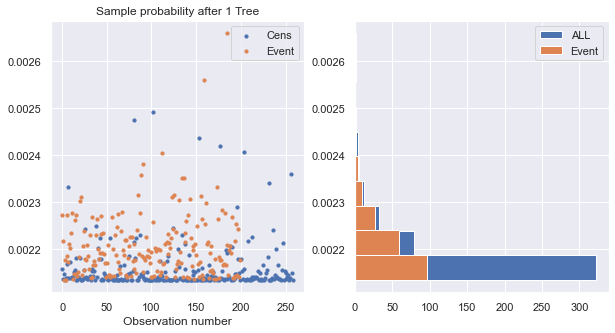

UNIQ INDEX: 287
UNIQ EVENT: 130
UNIQ CENS: 158


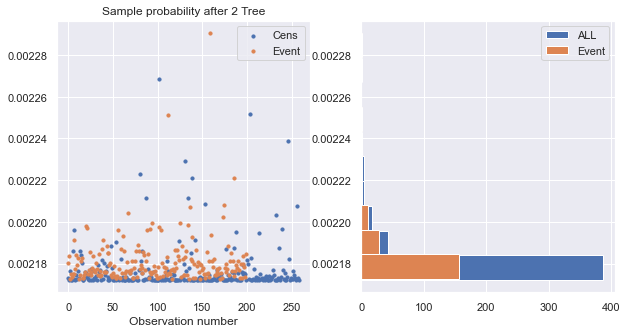

UNIQ INDEX: 287
UNIQ EVENT: 131
UNIQ CENS: 158


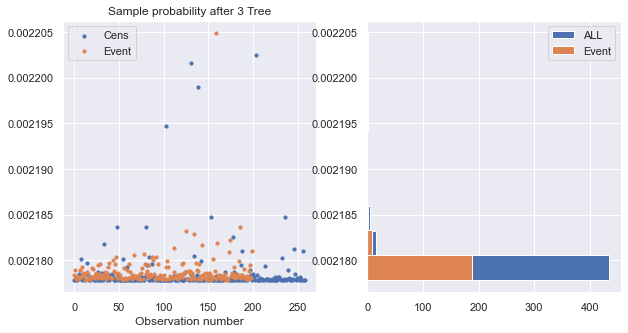

UNIQ INDEX: 286
UNIQ EVENT: 132
UNIQ CENS: 155


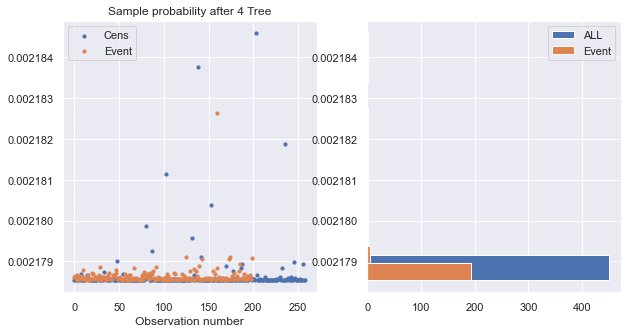

UNIQ INDEX: 295
UNIQ EVENT: 128
UNIQ CENS: 169


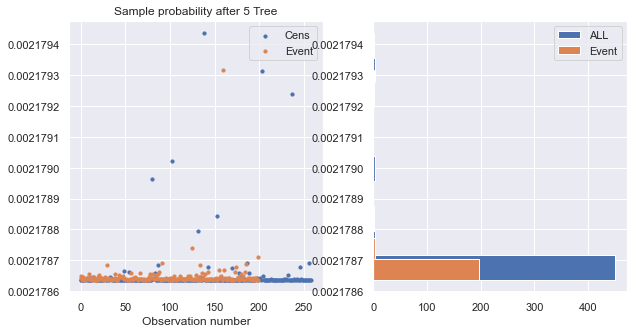

UNIQ INDEX: 292
UNIQ EVENT: 123
UNIQ CENS: 170


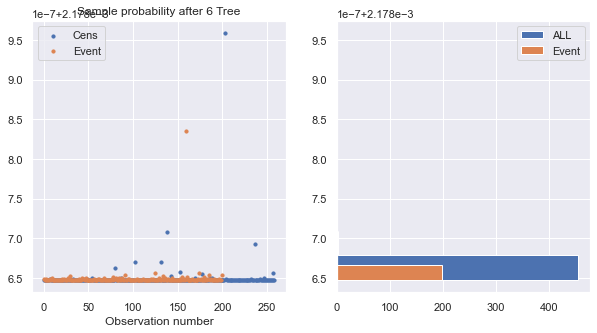

UNIQ INDEX: 289
UNIQ EVENT: 138
UNIQ CENS: 153


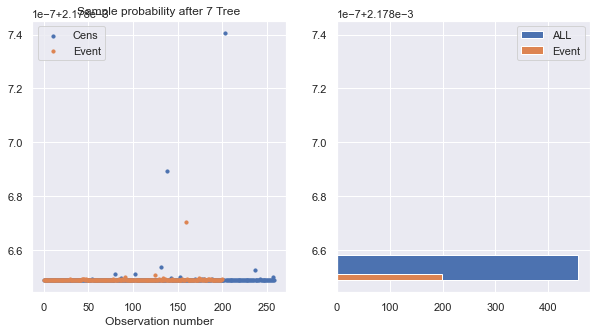

UNIQ INDEX: 294
UNIQ EVENT: 135
UNIQ CENS: 160


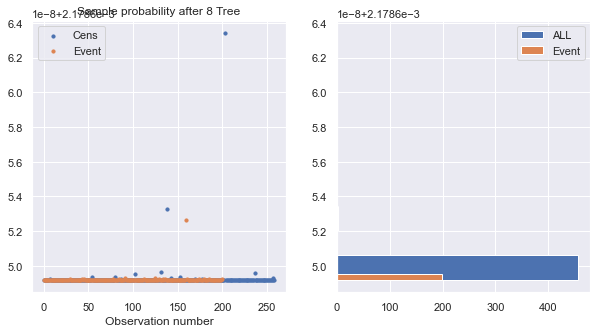

UNIQ INDEX: 290
UNIQ EVENT: 125
UNIQ CENS: 166


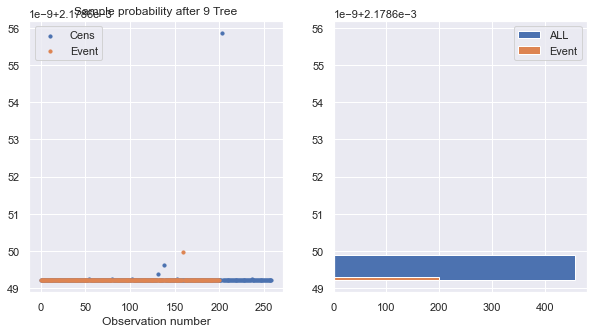

UNIQ INDEX: 284
UNIQ EVENT: 128
UNIQ CENS: 158


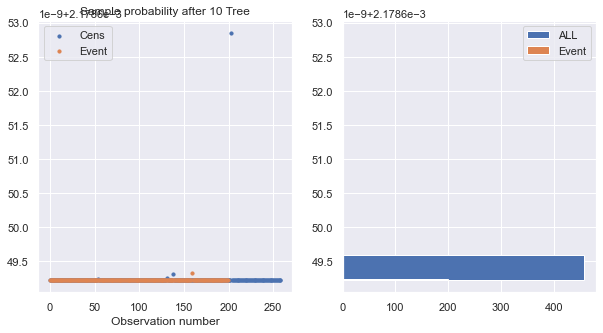

UNIQ INDEX: 277
UNIQ EVENT: 123
UNIQ CENS: 155


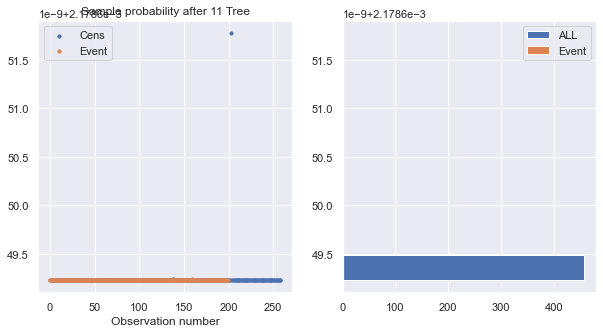

UNIQ INDEX: 291
UNIQ EVENT: 124
UNIQ CENS: 169


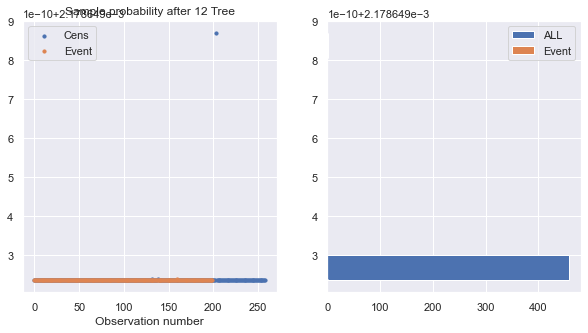

UNIQ INDEX: 297
UNIQ EVENT: 138
UNIQ CENS: 161


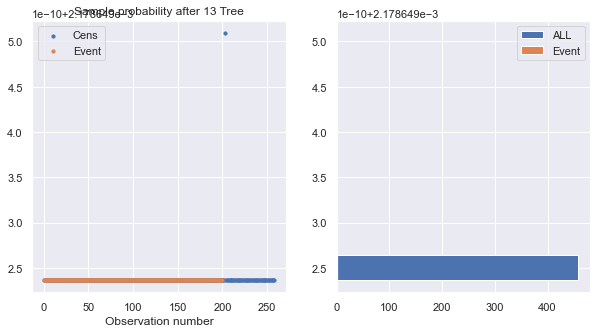

UNIQ INDEX: 281
UNIQ EVENT: 122
UNIQ CENS: 160


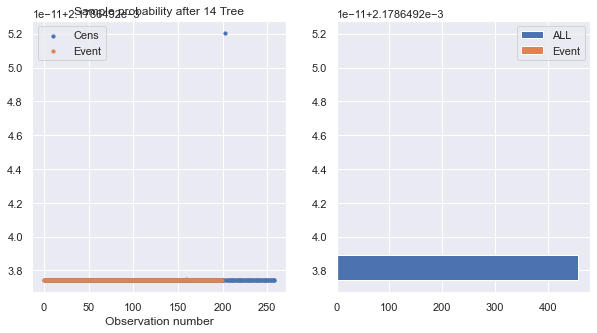

UNIQ INDEX: 285
UNIQ EVENT: 127
UNIQ CENS: 160


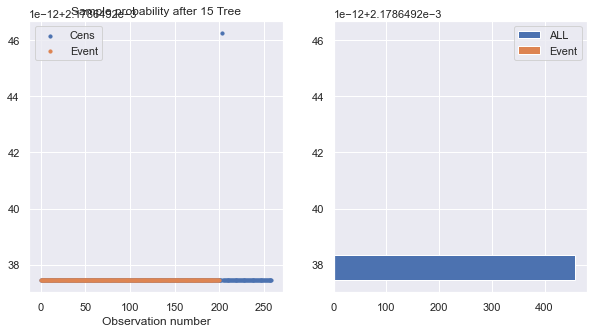

UNIQ INDEX: 295
UNIQ EVENT: 139
UNIQ CENS: 157


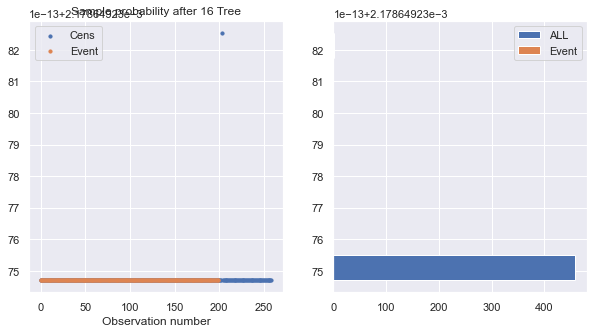

UNIQ INDEX: 285
UNIQ EVENT: 131
UNIQ CENS: 155


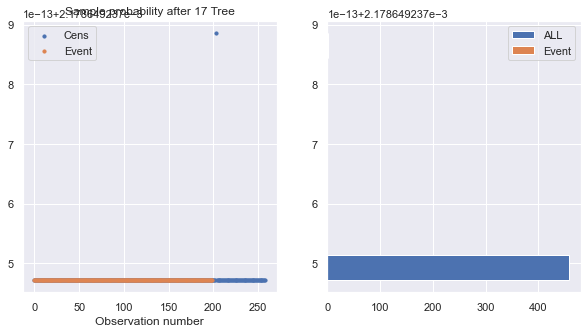

UNIQ INDEX: 284
UNIQ EVENT: 123
UNIQ CENS: 163


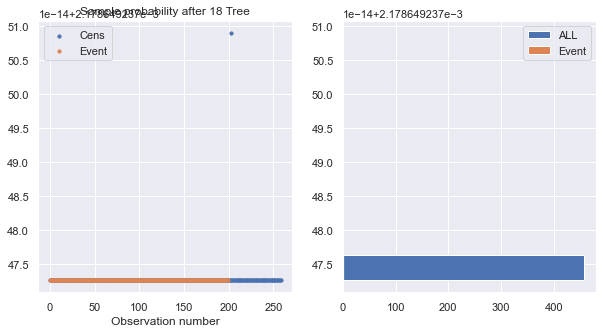

UNIQ INDEX: 287
UNIQ EVENT: 130
UNIQ CENS: 159


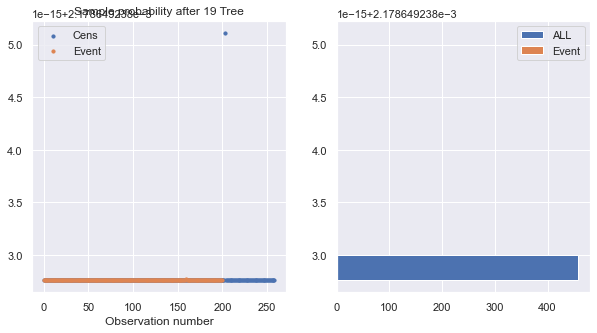

UNIQ INDEX: 296
UNIQ EVENT: 121
UNIQ CENS: 177


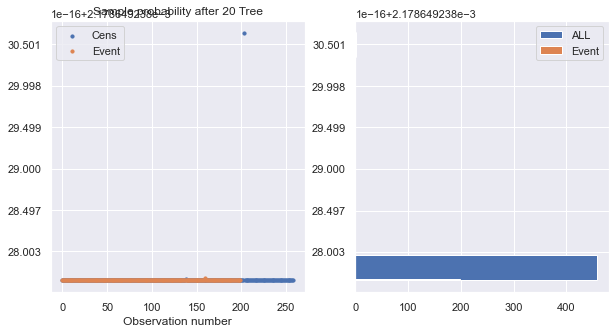

UNIQ INDEX: 289
UNIQ EVENT: 123
UNIQ CENS: 168


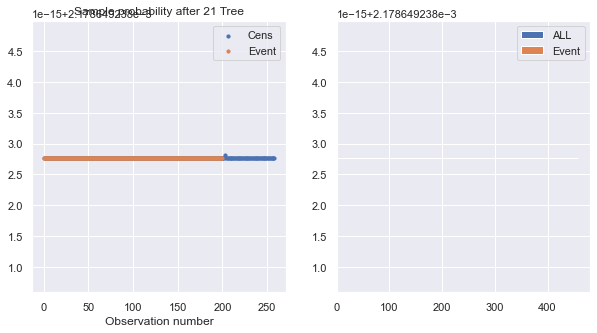

UNIQ INDEX: 295
UNIQ EVENT: 131
UNIQ CENS: 165


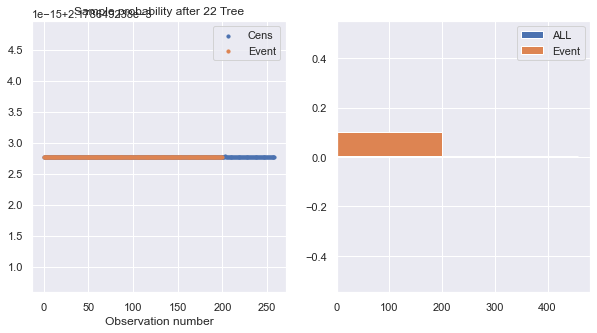

UNIQ INDEX: 283
UNIQ EVENT: 125
UNIQ CENS: 160


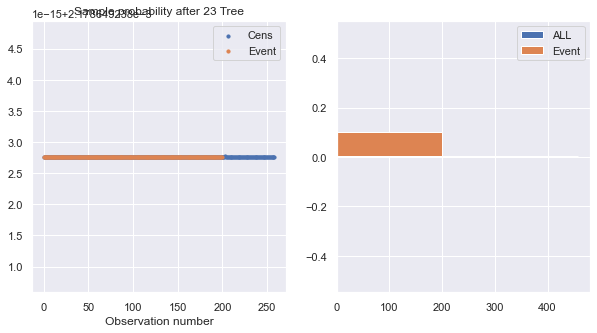

UNIQ INDEX: 296
UNIQ EVENT: 120
UNIQ CENS: 177


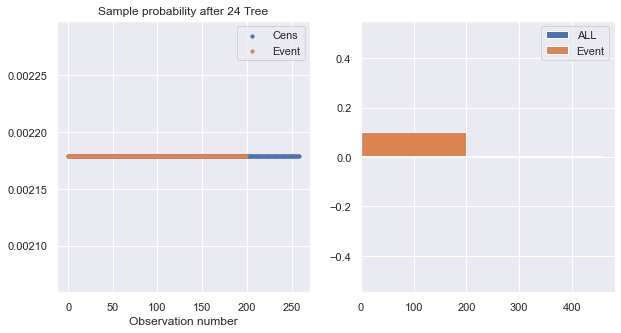

UNIQ INDEX: 302
UNIQ EVENT: 131
UNIQ CENS: 172


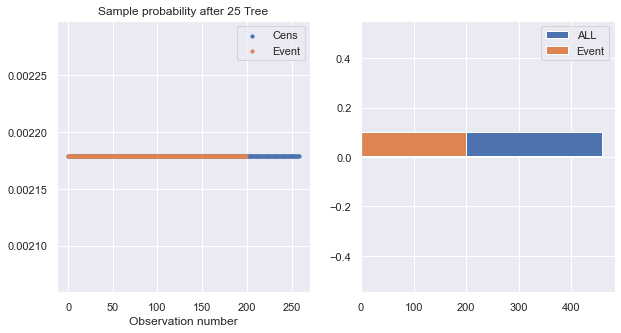

UNIQ INDEX: 292
UNIQ EVENT: 124
UNIQ CENS: 170


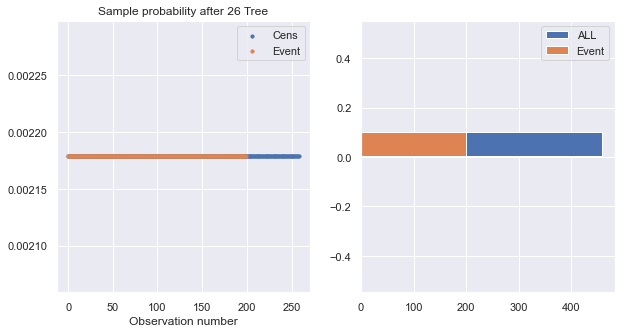

UNIQ INDEX: 292
UNIQ EVENT: 129
UNIQ CENS: 165


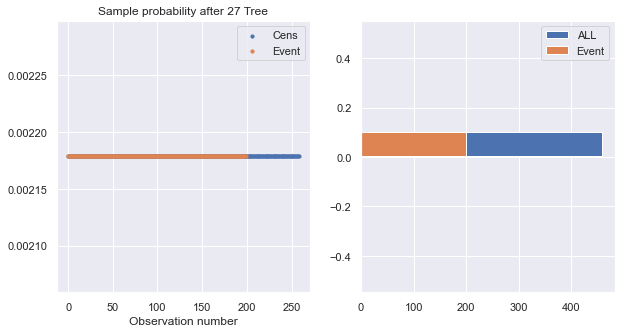

UNIQ INDEX: 289
UNIQ EVENT: 124
UNIQ CENS: 166


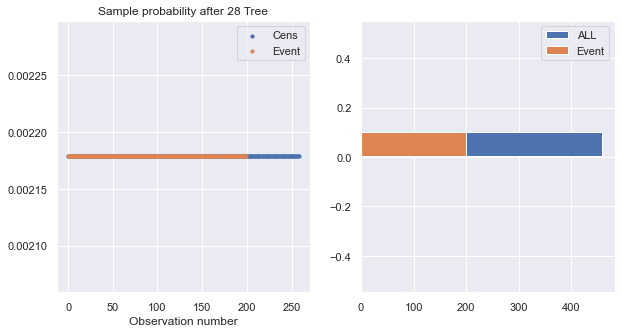

UNIQ INDEX: 282
UNIQ EVENT: 121
UNIQ CENS: 162


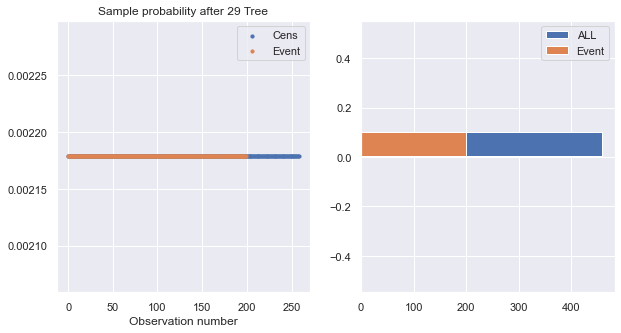

UNIQ INDEX: 291
UNIQ EVENT: 119
UNIQ CENS: 173


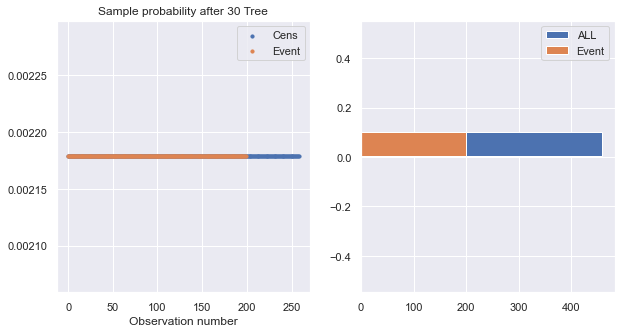

UNIQ INDEX: 295
UNIQ EVENT: 138
UNIQ CENS: 159


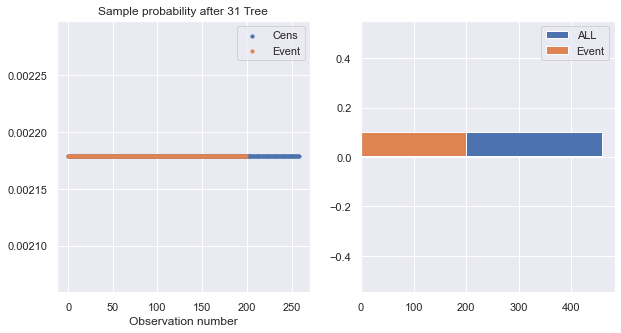

UNIQ INDEX: 289
UNIQ EVENT: 130
UNIQ CENS: 160


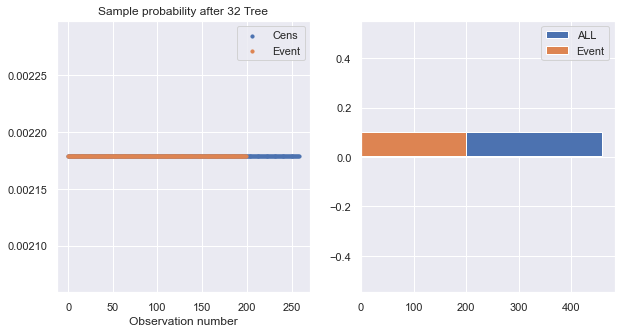

UNIQ INDEX: 299
UNIQ EVENT: 135
UNIQ CENS: 166


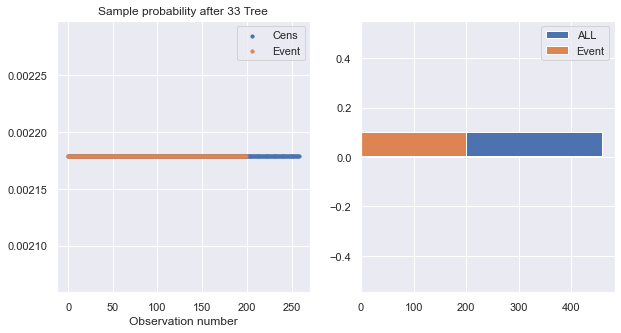

UNIQ INDEX: 287
UNIQ EVENT: 131
UNIQ CENS: 157


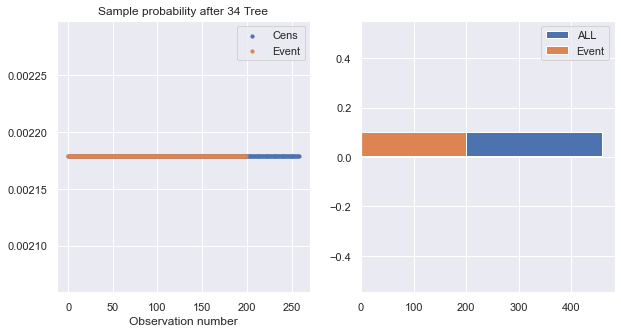

UNIQ INDEX: 296
UNIQ EVENT: 133
UNIQ CENS: 164


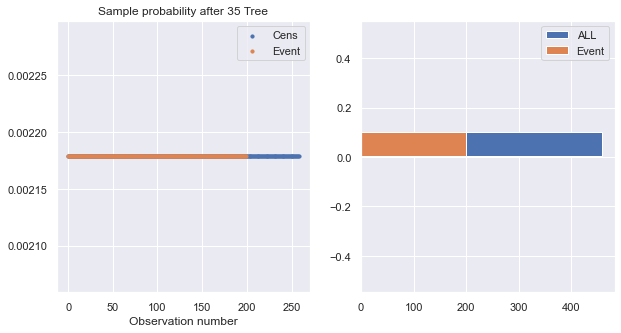

UNIQ INDEX: 290
UNIQ EVENT: 120
UNIQ CENS: 172


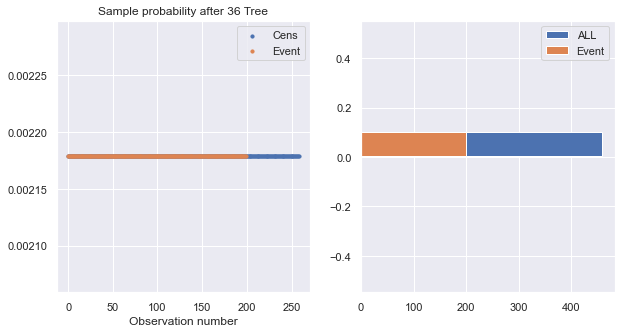

UNIQ INDEX: 288
UNIQ EVENT: 140
UNIQ CENS: 149


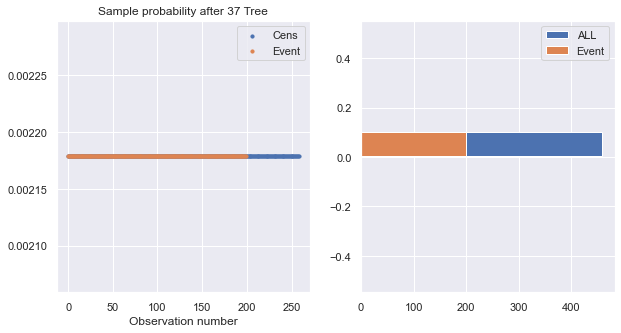

UNIQ INDEX: 282
UNIQ EVENT: 126
UNIQ CENS: 157


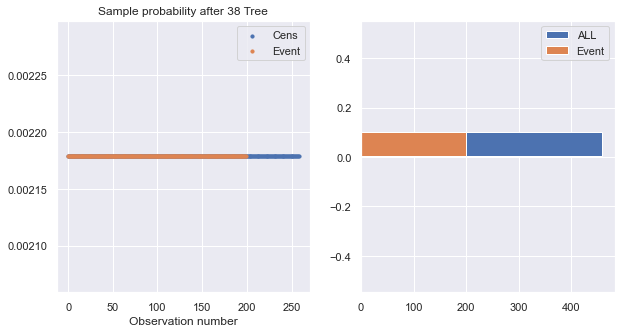

UNIQ INDEX: 284
UNIQ EVENT: 121
UNIQ CENS: 165


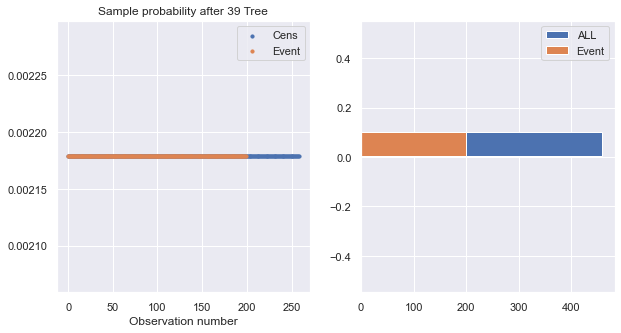

UNIQ INDEX: 284
UNIQ EVENT: 119
UNIQ CENS: 166


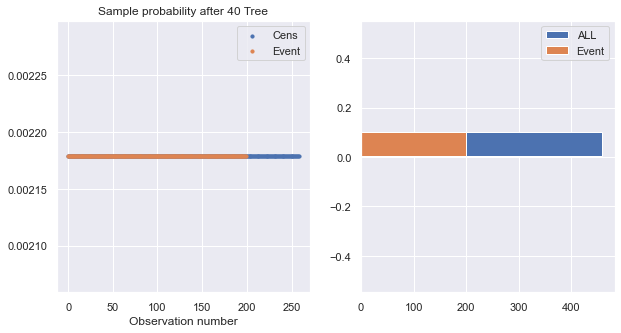

UNIQ INDEX: 288
UNIQ EVENT: 128
UNIQ CENS: 161


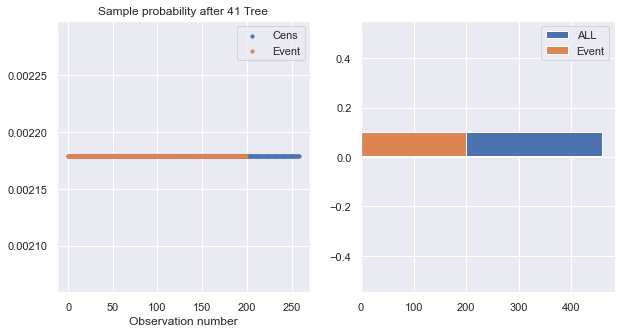

UNIQ INDEX: 294
UNIQ EVENT: 128
UNIQ CENS: 168


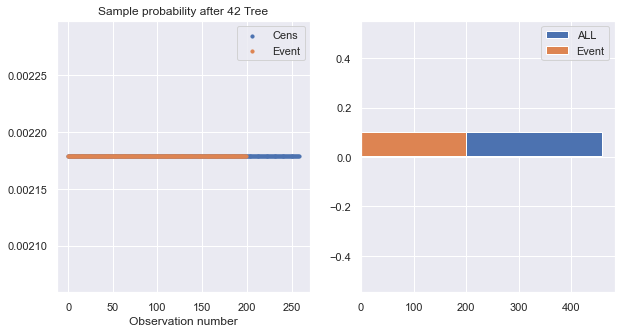

UNIQ INDEX: 288
UNIQ EVENT: 127
UNIQ CENS: 163


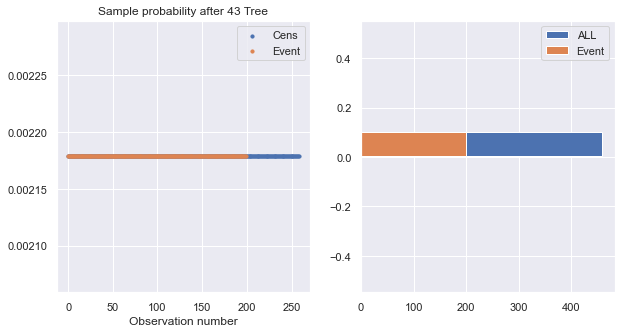

UNIQ INDEX: 304
UNIQ EVENT: 141
UNIQ CENS: 165


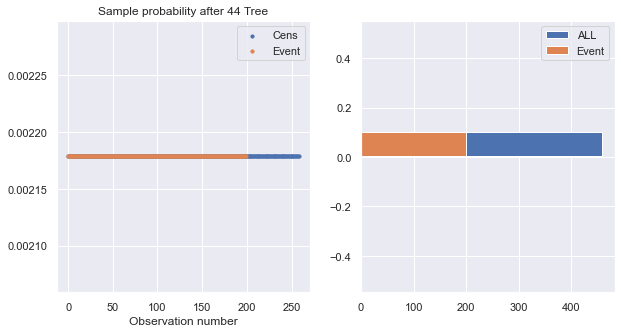

UNIQ INDEX: 297
UNIQ EVENT: 124
UNIQ CENS: 174


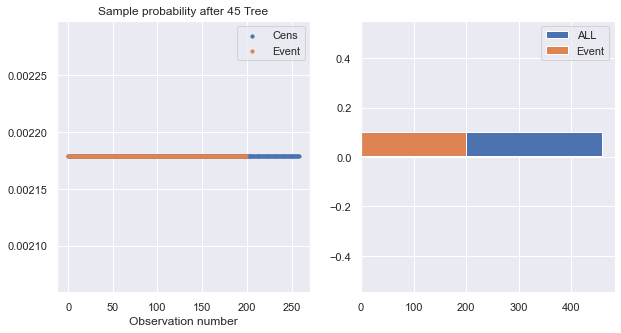

UNIQ INDEX: 284
UNIQ EVENT: 128
UNIQ CENS: 158


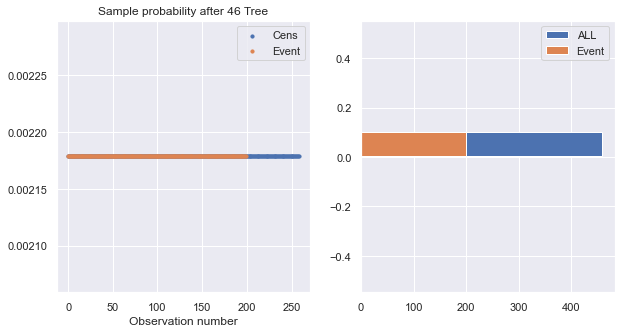

UNIQ INDEX: 292
UNIQ EVENT: 136
UNIQ CENS: 157


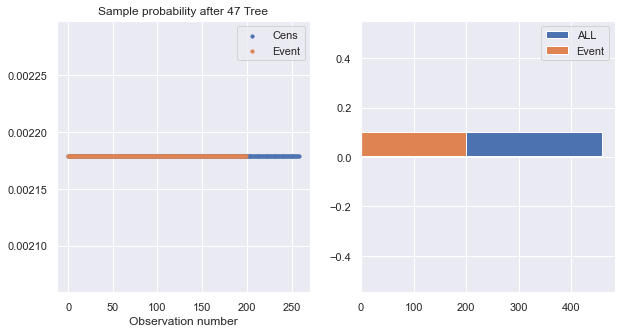

UNIQ INDEX: 288
UNIQ EVENT: 127
UNIQ CENS: 162


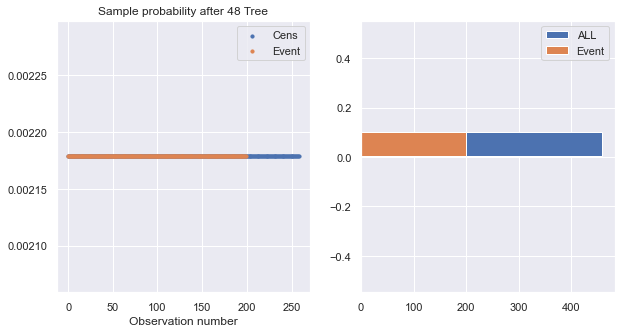

UNIQ INDEX: 285
UNIQ EVENT: 127
UNIQ CENS: 159


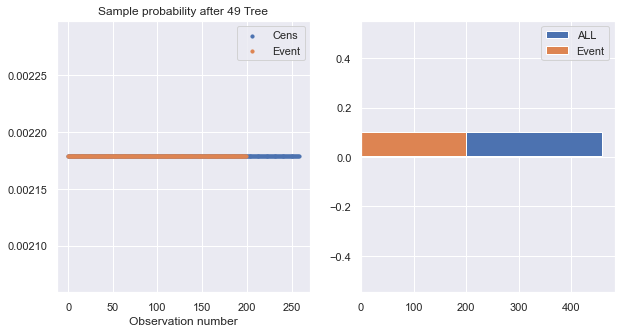

UNIQ INDEX: 297
UNIQ EVENT: 125
UNIQ CENS: 173


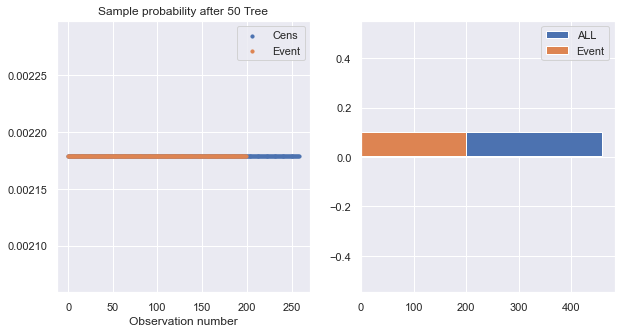

UNIQ INDEX: 298
UNIQ EVENT: 135
UNIQ CENS: 165


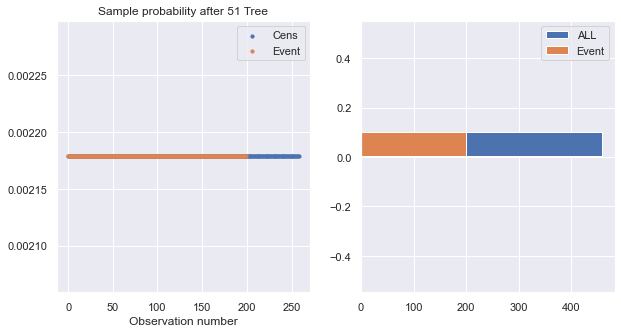

UNIQ INDEX: 293
UNIQ EVENT: 120
UNIQ CENS: 175


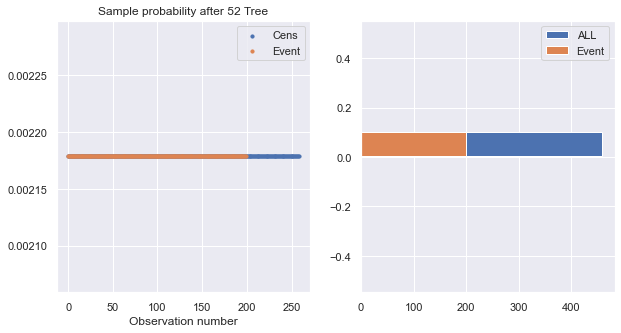

UNIQ INDEX: 291
UNIQ EVENT: 125
UNIQ CENS: 167


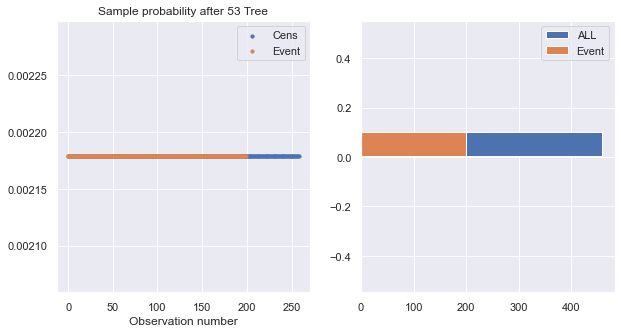

UNIQ INDEX: 294
UNIQ EVENT: 131
UNIQ CENS: 165


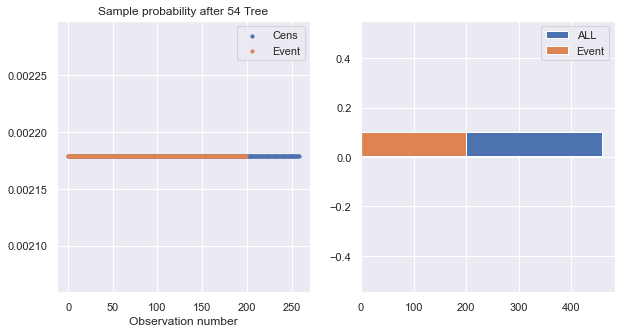

UNIQ INDEX: 284
UNIQ EVENT: 128
UNIQ CENS: 157


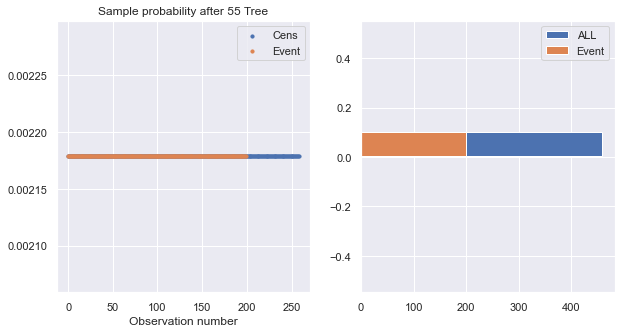

UNIQ INDEX: 288
UNIQ EVENT: 128
UNIQ CENS: 161


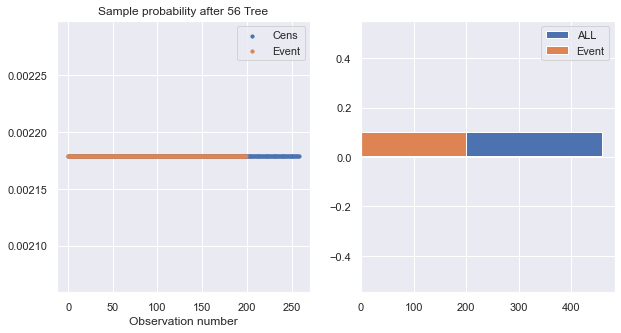

UNIQ INDEX: 293
UNIQ EVENT: 134
UNIQ CENS: 160


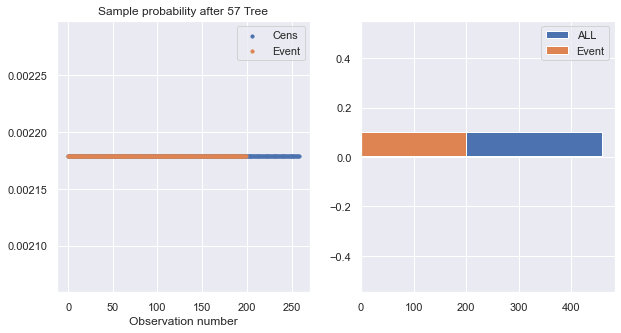

UNIQ INDEX: 296
UNIQ EVENT: 133
UNIQ CENS: 164


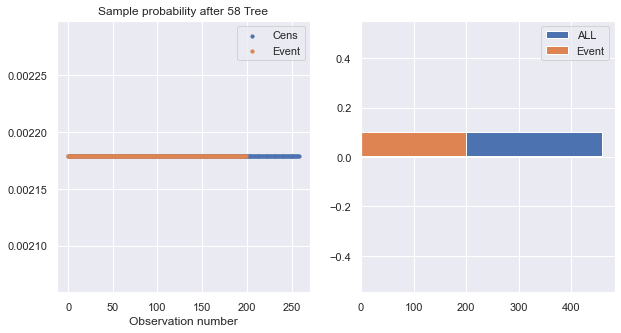

UNIQ INDEX: 298
UNIQ EVENT: 132
UNIQ CENS: 167


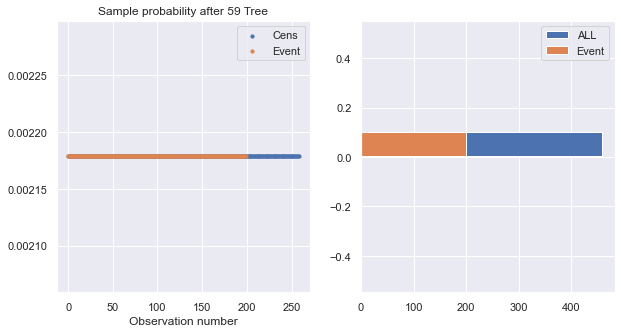

UNIQ INDEX: 293
UNIQ EVENT: 133
UNIQ CENS: 161


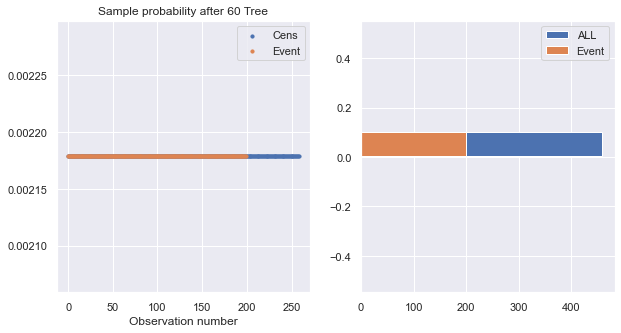

UNIQ INDEX: 278
UNIQ EVENT: 123
UNIQ CENS: 156


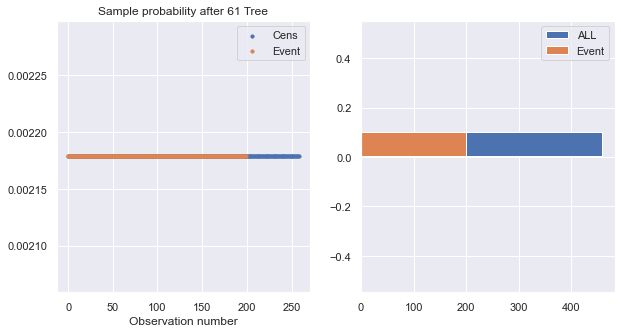

UNIQ INDEX: 293
UNIQ EVENT: 131
UNIQ CENS: 164


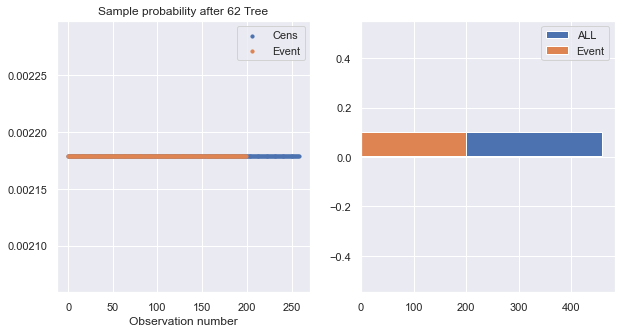

UNIQ INDEX: 288
UNIQ EVENT: 126
UNIQ CENS: 163


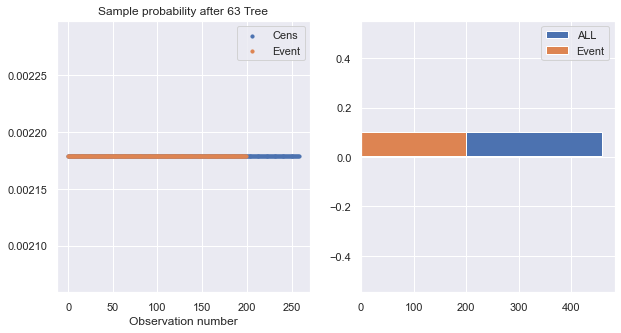

UNIQ INDEX: 278
UNIQ EVENT: 121
UNIQ CENS: 158


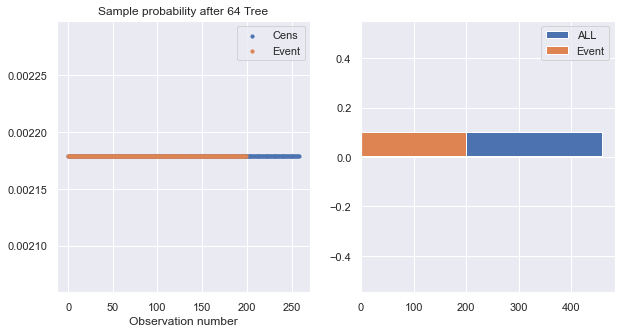

UNIQ INDEX: 294
UNIQ EVENT: 129
UNIQ CENS: 166


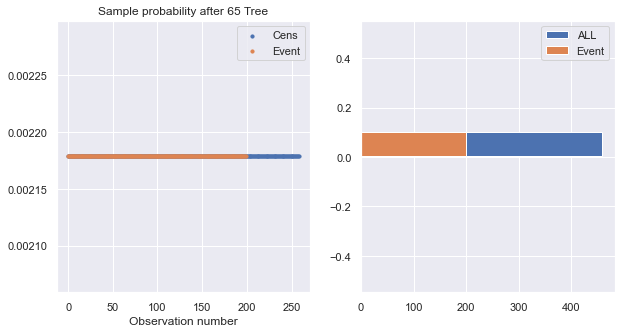

UNIQ INDEX: 291
UNIQ EVENT: 125
UNIQ CENS: 168


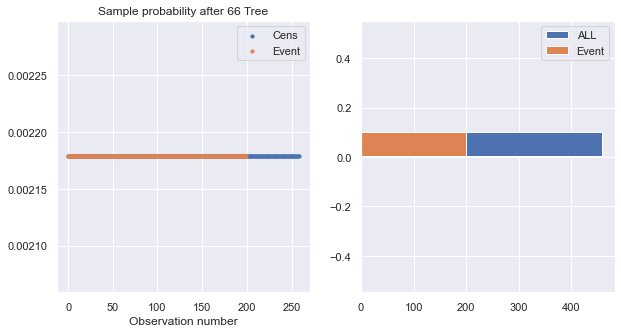

UNIQ INDEX: 292
UNIQ EVENT: 132
UNIQ CENS: 161


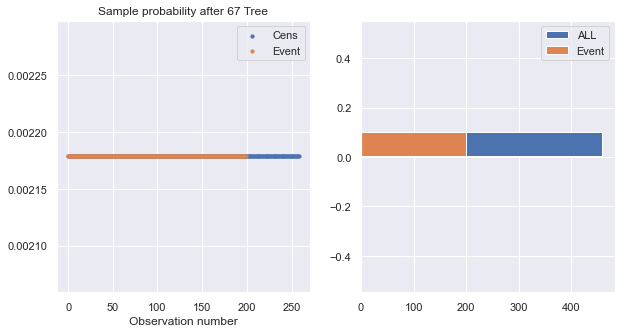

UNIQ INDEX: 291
UNIQ EVENT: 125
UNIQ CENS: 167


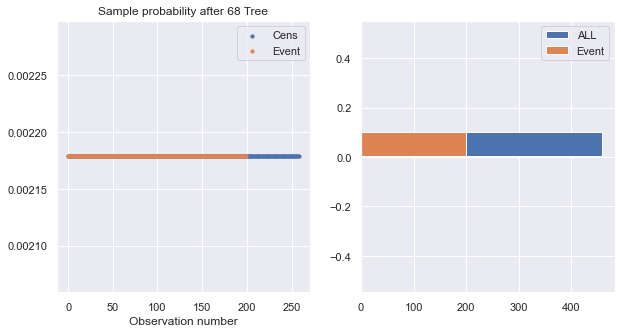

UNIQ INDEX: 305
UNIQ EVENT: 136
UNIQ CENS: 171


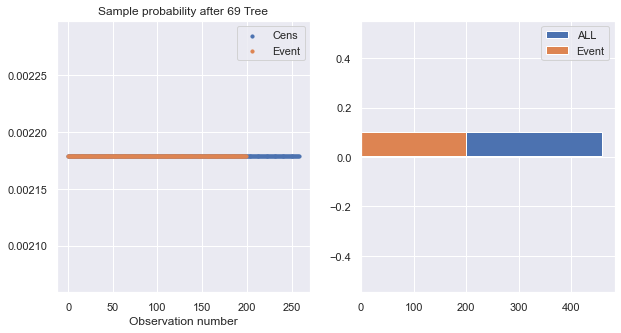

UNIQ INDEX: 289
UNIQ EVENT: 124
UNIQ CENS: 166


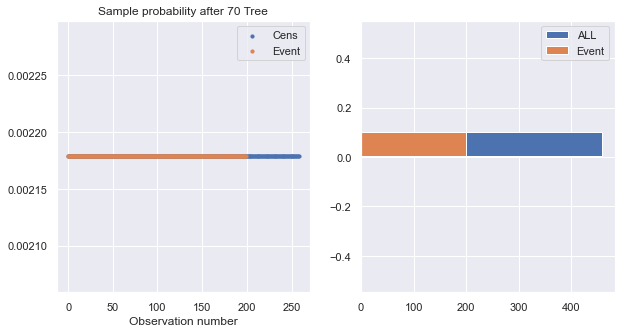

UNIQ INDEX: 288
UNIQ EVENT: 137
UNIQ CENS: 152


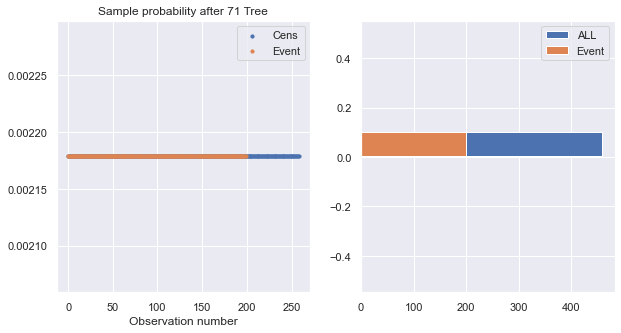

UNIQ INDEX: 284
UNIQ EVENT: 117
UNIQ CENS: 168


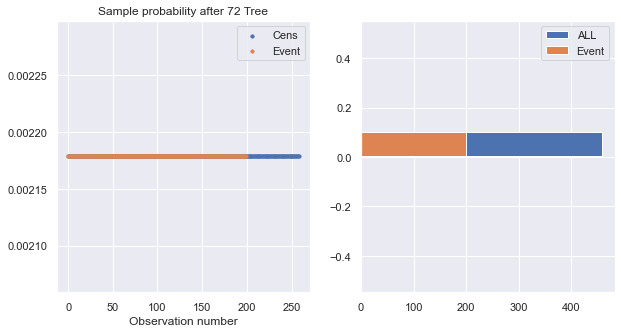

UNIQ INDEX: 290
UNIQ EVENT: 128
UNIQ CENS: 164


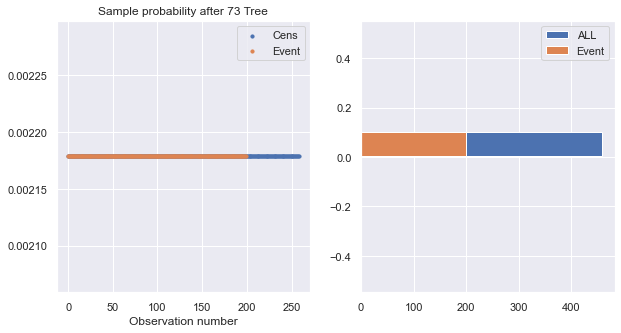

UNIQ INDEX: 307
UNIQ EVENT: 136
UNIQ CENS: 172


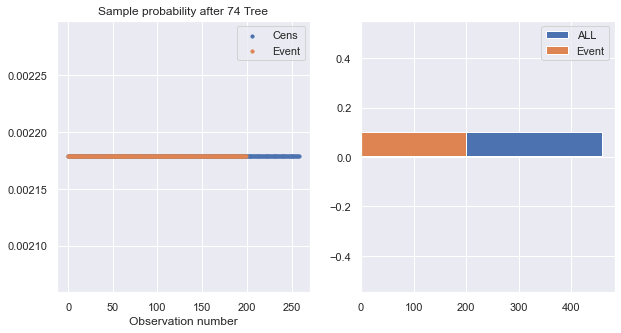

UNIQ INDEX: 293
UNIQ EVENT: 125
UNIQ CENS: 169


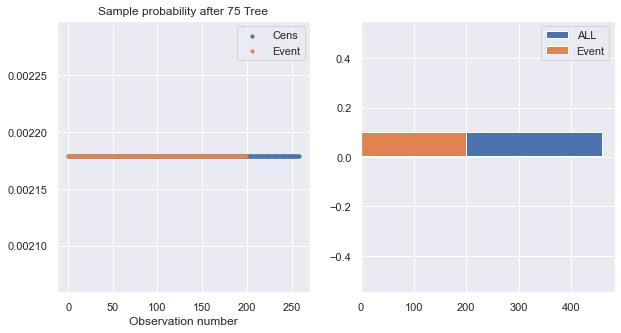

UNIQ INDEX: 286
UNIQ EVENT: 129
UNIQ CENS: 158


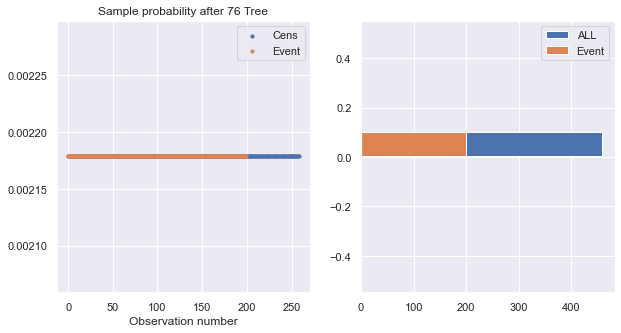

UNIQ INDEX: 293
UNIQ EVENT: 135
UNIQ CENS: 160


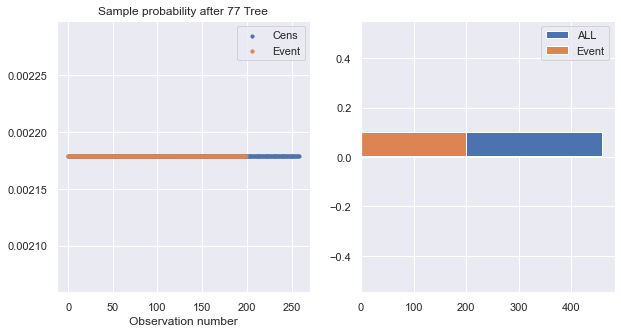

UNIQ INDEX: 296
UNIQ EVENT: 129
UNIQ CENS: 168


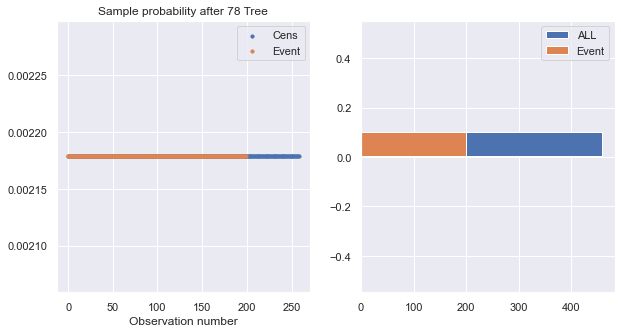

UNIQ INDEX: 285
UNIQ EVENT: 125
UNIQ CENS: 162


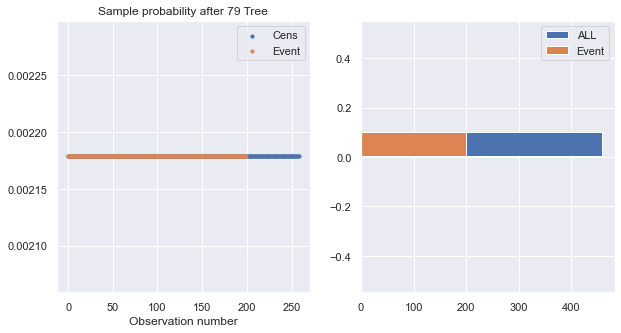

UNIQ INDEX: 299
UNIQ EVENT: 121
UNIQ CENS: 179


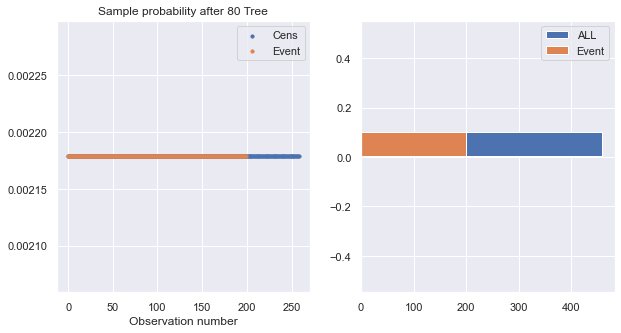

UNIQ INDEX: 294
UNIQ EVENT: 125
UNIQ CENS: 170


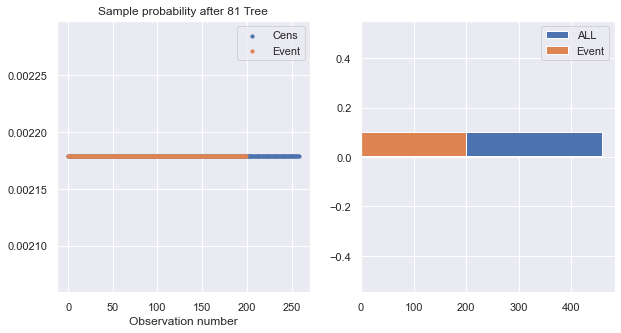

UNIQ INDEX: 295
UNIQ EVENT: 121
UNIQ CENS: 176


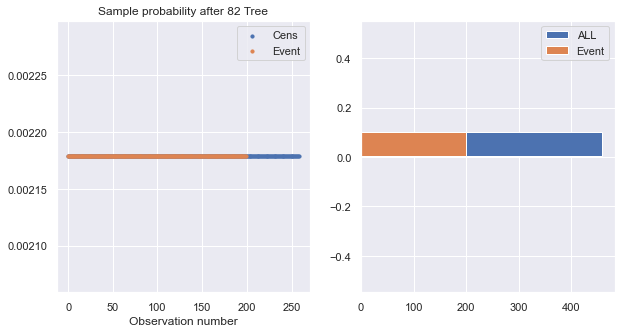

UNIQ INDEX: 286
UNIQ EVENT: 132
UNIQ CENS: 156


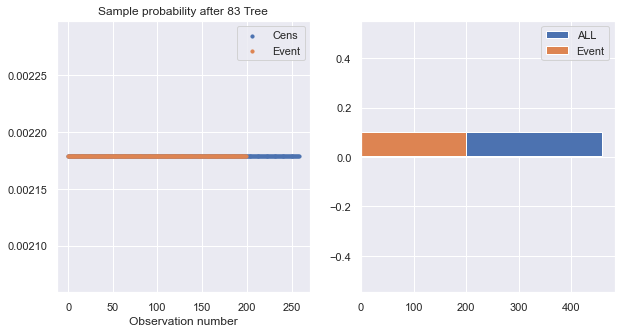

UNIQ INDEX: 291
UNIQ EVENT: 136
UNIQ CENS: 157


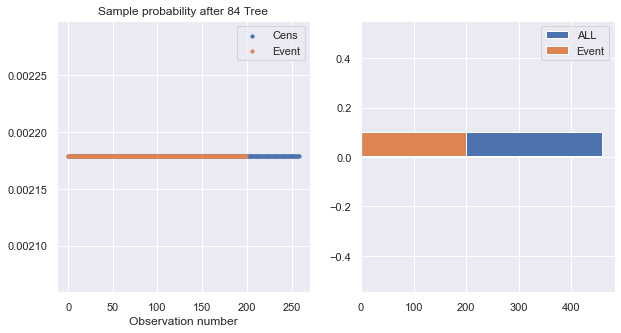

UNIQ INDEX: 296
UNIQ EVENT: 132
UNIQ CENS: 166


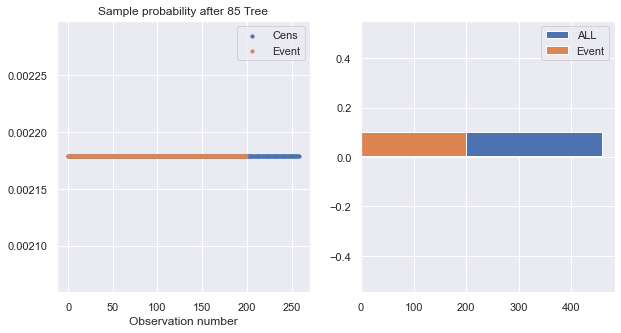

UNIQ INDEX: 294
UNIQ EVENT: 127
UNIQ CENS: 168


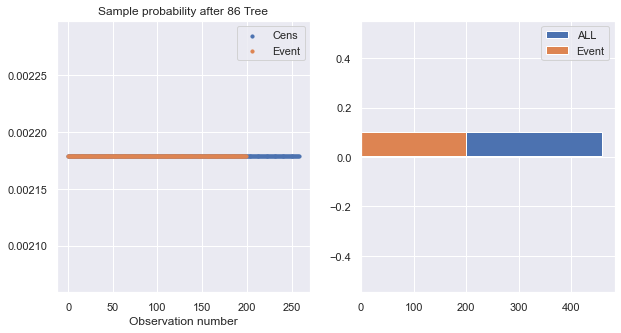

UNIQ INDEX: 285
UNIQ EVENT: 126
UNIQ CENS: 160


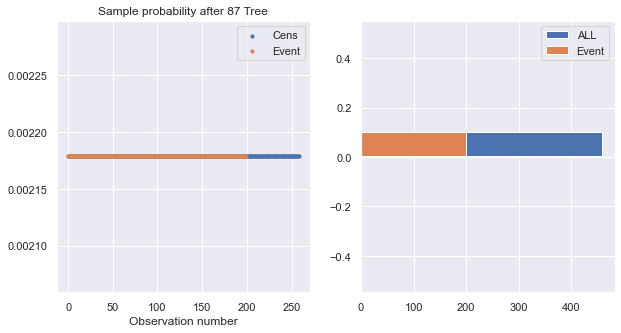

UNIQ INDEX: 297
UNIQ EVENT: 137
UNIQ CENS: 161


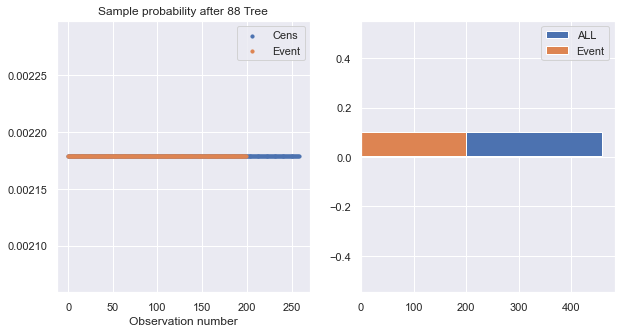

UNIQ INDEX: 277
UNIQ EVENT: 114
UNIQ CENS: 164


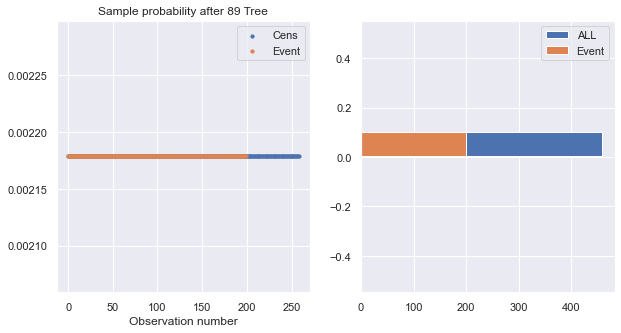

UNIQ INDEX: 289
UNIQ EVENT: 129
UNIQ CENS: 161


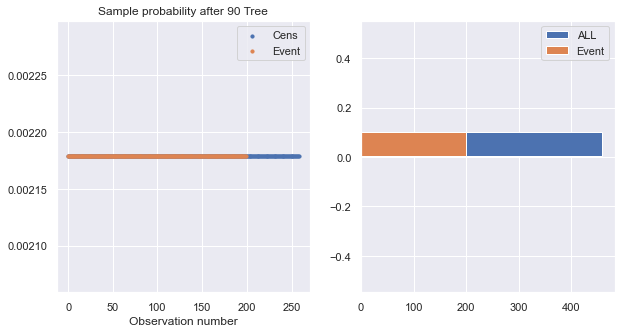

UNIQ INDEX: 274
UNIQ EVENT: 126
UNIQ CENS: 149


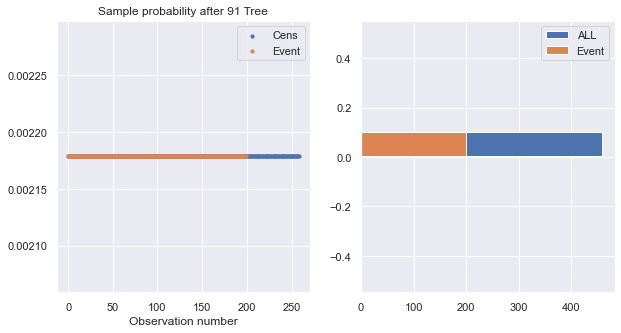

UNIQ INDEX: 290
UNIQ EVENT: 129
UNIQ CENS: 162


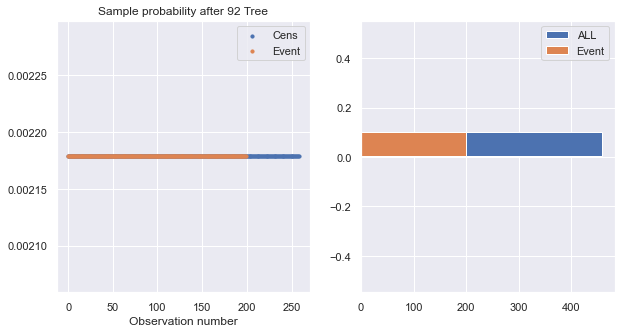

UNIQ INDEX: 284
UNIQ EVENT: 118
UNIQ CENS: 167


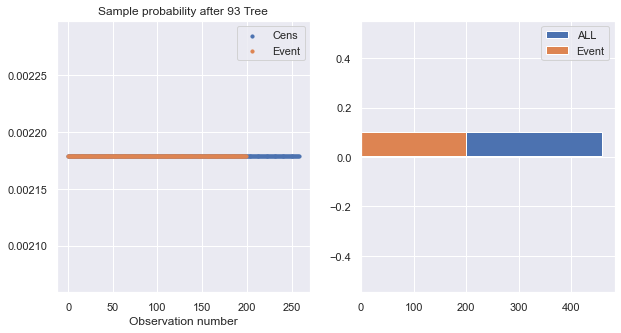

UNIQ INDEX: 300
UNIQ EVENT: 139
UNIQ CENS: 162


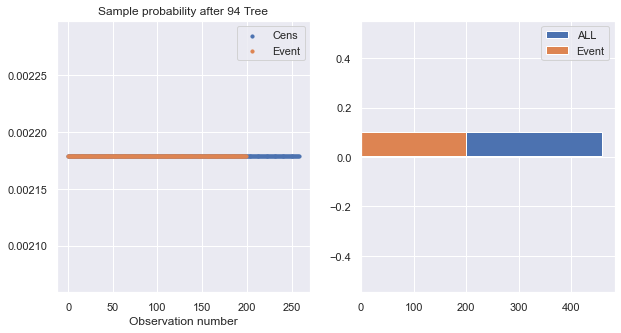

UNIQ INDEX: 285
UNIQ EVENT: 131
UNIQ CENS: 155


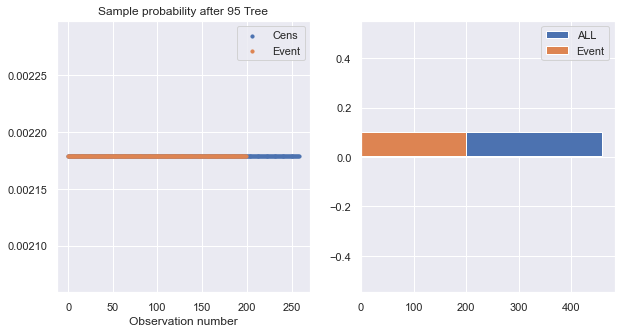

UNIQ INDEX: 282
UNIQ EVENT: 119
UNIQ CENS: 165


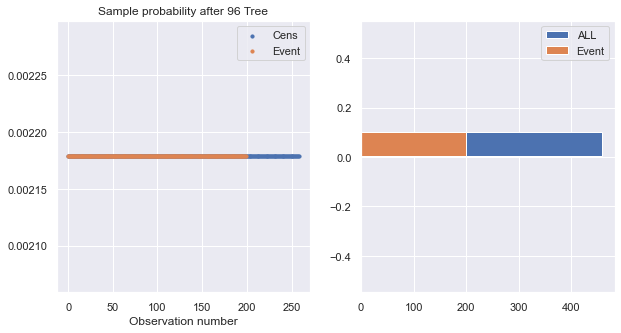

UNIQ INDEX: 293
UNIQ EVENT: 122
UNIQ CENS: 172


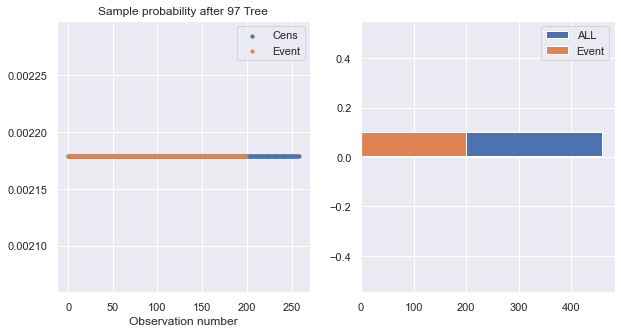

UNIQ INDEX: 277
UNIQ EVENT: 120
UNIQ CENS: 158


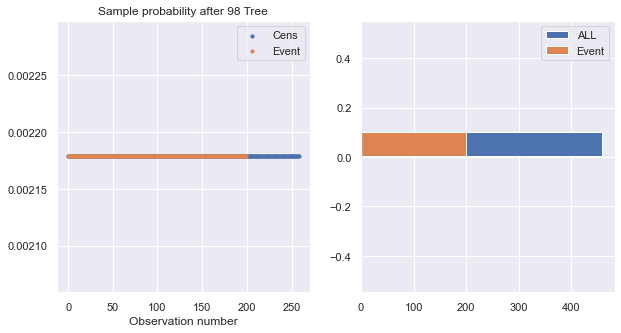

UNIQ INDEX: 280
UNIQ EVENT: 126
UNIQ CENS: 156


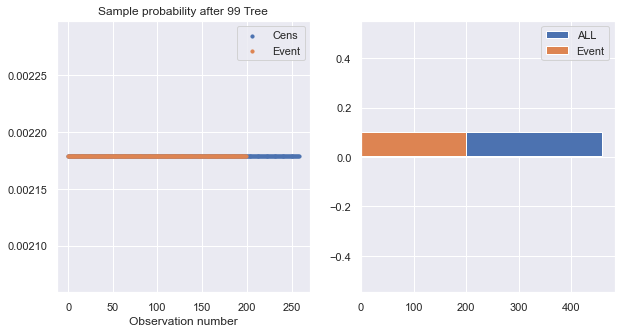

UNIQ INDEX: 295
UNIQ EVENT: 130
UNIQ CENS: 166


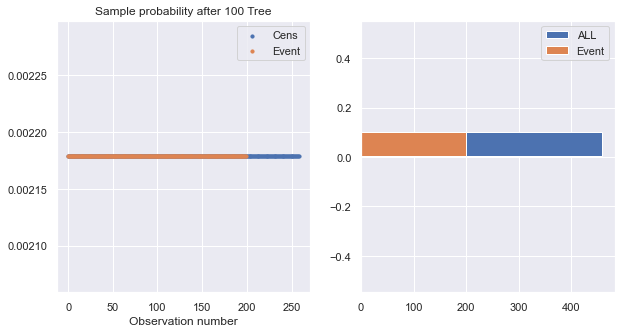

[0.1918 0.2121 0.2138 0.2135 0.208  0.2076 0.2028 0.1993 0.1952 0.1966
 0.1942 0.191  0.1892 0.1913 0.191  0.191  0.1875 0.1871 0.1847 0.1842
 0.1844 0.1832 0.1832 0.1816 0.1811 0.1812 0.1817 0.1814 0.1811 0.1809
 0.1801 0.1798 0.1801 0.1799 0.1799 0.1799 0.1794 0.1794 0.1793 0.1787
 0.1791 0.1796 0.1793 0.1796 0.1794 0.1793 0.1791 0.1791 0.1783 0.1778
 0.1778 0.1777 0.1783 0.178  0.1776 0.1773 0.1771 0.1772 0.1773 0.1772
 0.1774 0.1779 0.178  0.178  0.1781 0.1782 0.1781 0.1779 0.1778 0.1777
 0.178  0.1782 0.1784 0.1787 0.1786 0.1786 0.1788 0.1788 0.1791 0.1789
 0.1791 0.1787 0.1785 0.1783 0.1782 0.1777 0.1778 0.1778 0.1779 0.1779
 0.178  0.178  0.1782 0.1782 0.1782 0.1782 0.1781 0.1785 0.1784 0.1783]
fitted: 57 models.
74.81348967552185


In [4605]:
from survivors.ensemble.boosting import arc_x4

class Visualize(IBSProbBoostingCRAID):
    def update_weight(self, index, wei_i):
        super().update_weight(index, wei_i)
        self.visualize_weights(index)
    
    def visualize_weights(self, train_index):
        fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
        print("UNIQ INDEX:", len(np.unique(train_index)))
        print("UNIQ EVENT:", len(np.unique(train_index * self.y_train[train_index]["cens"])))
        print("UNIQ CENS:", len(np.unique(train_index * (1 - self.y_train[train_index]["cens"]))))
        w = arc_x4(self.weights)
        axes[0].set_title(f"Sample probability after {len(self.bettas)} Tree")
        axes[0].scatter(range(len(w[~self.y_train["cens"]])), 
                        w[~self.y_train["cens"]], 10, label = "Cens")
        axes[0].scatter(range(len(w[self.y_train["cens"]])), 
                        w[self.y_train["cens"]], 10, label = "Event")
        axes[0].set_xlabel("Observation number")
        axes[0].legend()
        
        axes[1].hist(w, orientation="horizontal", label = "ALL")
        axes[1].hist(w[self.y_train["cens"]], orientation="horizontal", label = "Event")
        axes[1].legend()
        plt.show()
        
# DATASET ONK
# proboost_params = {
#  'balance': None, 
#  "with_arc": False,
#  'aggreg_func': 'wei', 'all_weight': False, 'categ': ['Диагноз'], 
#  'criterion': 'logrank', 'depth': 10, 'ens_metric_name': 'bic', 
#  'leaf_model': 'wei_survive', 'max_features': 0.7, 'min_samples_leaf': 5, 
#  'n_estimators': 10, 'n_jobs': 2, 'size_sample': 0.7
# }

# proboost_params = {
#  'balance': None, 
#  "with_arc": False,
#  'aggreg_func': 'wei', 'all_weight': False, 'categ': categ,
#  'criterion': 'logrank', 'depth': 10, 'ens_metric_name': 'conc', 
#  'leaf_model': 'base_fast', 'max_features': "sqrt", 'min_samples_leaf': 5, 
#  'n_estimators': 10, 'n_jobs': 2, 'size_sample': 0.7
# }

proboost_params = {
 'balance': None, 
 "with_arc": True,
 'aggreg_func': 'wei', 'all_weight': True, 'categ': categ,
 'criterion': 'logrank', 'depth': 20, 'ens_metric_name': 'ibs', 
 'leaf_model': 'base_fast', 'max_features': "sqrt", 'min_samples_leaf': 10, 
 'n_estimators': 100, 'n_jobs': 2, 'size_sample': 1.0
}

start_time = time.time()
proboost = Visualize(**proboost_params)
proboost.fit(X_tr, y_tr)

print(time.time() - start_time)

Prior distribution: [259 200]


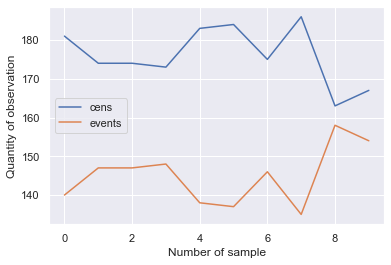

In [3906]:
print("Prior distribution:", np.bincount(y_tr["cens"]))
n_cens = []
n_events = []
for i in range(len(proboost.models)):
    distr = np.bincount(proboost.models[i].nodes[0].leaf_model.predict_list_feature(feature_name="cens"))
    n_cens.append(distr[0])
    n_events.append(distr[1])

plt.plot(n_cens, label="cens")
plt.plot(n_events, label="events")
plt.legend()
plt.ylabel("Quantity of observation")
plt.xlabel("Number of sample")
plt.show()

UNIQ INDEX: 231
UNIQ EVENT: 97
UNIQ CENS: 136


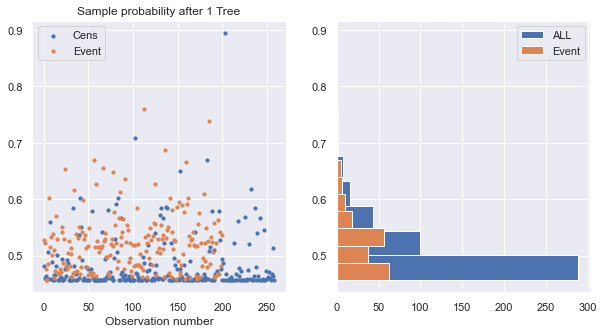

UNIQ INDEX: 234
UNIQ EVENT: 109
UNIQ CENS: 126


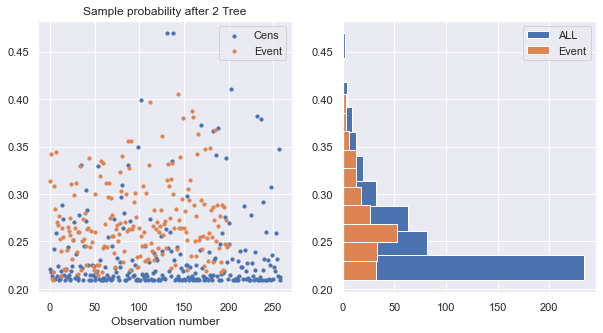

UNIQ INDEX: 220
UNIQ EVENT: 99
UNIQ CENS: 123


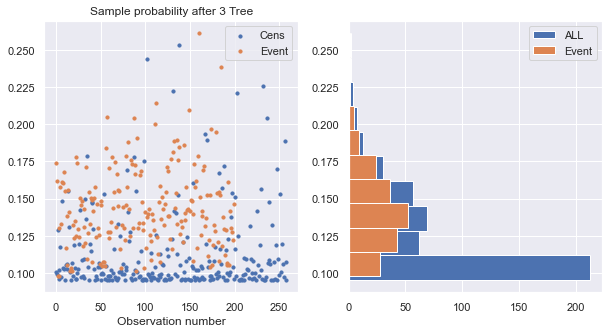

UNIQ INDEX: 225
UNIQ EVENT: 106
UNIQ CENS: 120


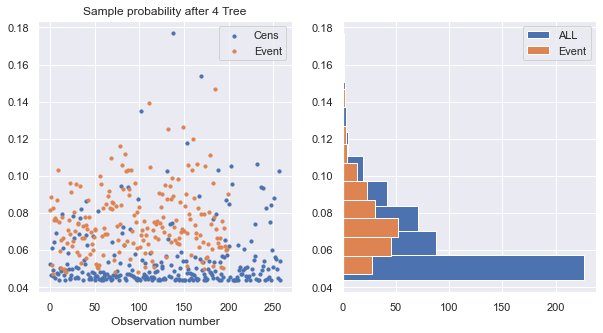

UNIQ INDEX: 229
UNIQ EVENT: 107
UNIQ CENS: 124


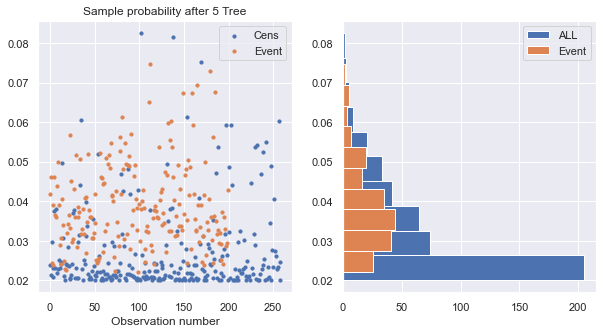

UNIQ INDEX: 229
UNIQ EVENT: 106
UNIQ CENS: 124


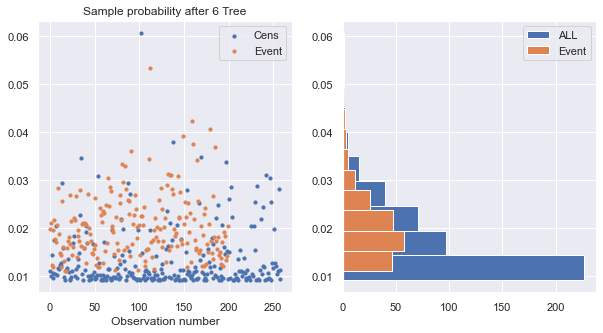

UNIQ INDEX: 221
UNIQ EVENT: 115
UNIQ CENS: 108


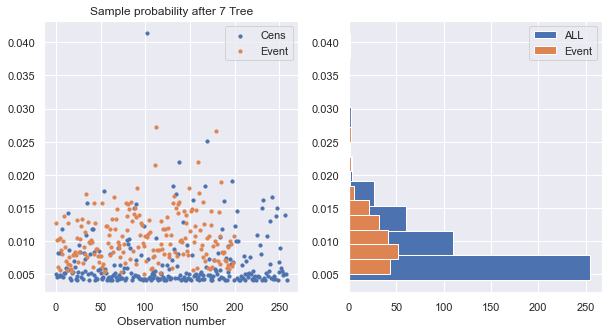

UNIQ INDEX: 225
UNIQ EVENT: 125
UNIQ CENS: 102


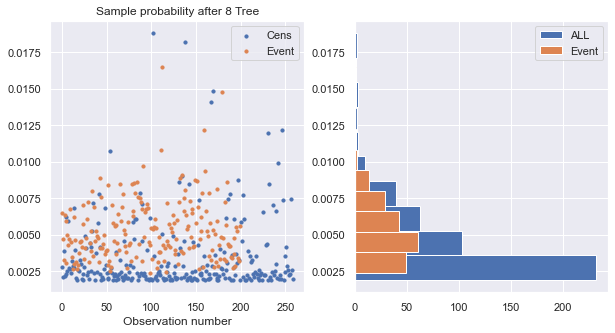

UNIQ INDEX: 212
UNIQ EVENT: 109
UNIQ CENS: 104


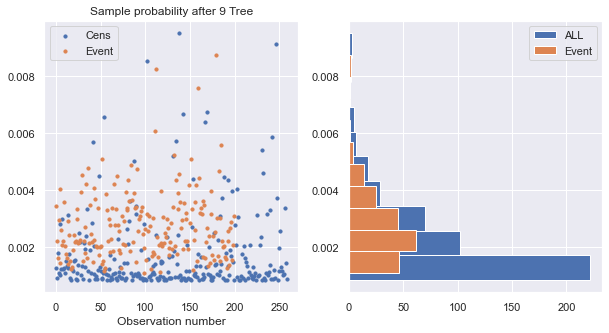

UNIQ INDEX: 219
UNIQ EVENT: 112
UNIQ CENS: 109


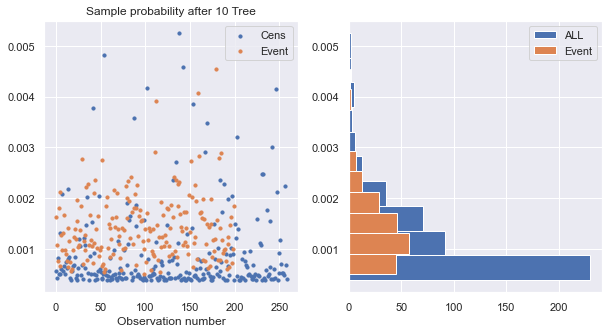

UNIQ INDEX: 198
UNIQ EVENT: 112
UNIQ CENS: 88


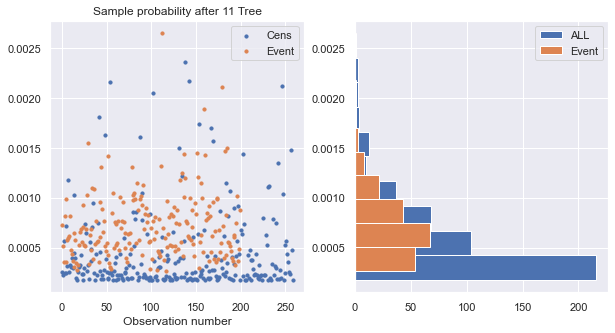

UNIQ INDEX: 201
UNIQ EVENT: 114
UNIQ CENS: 89


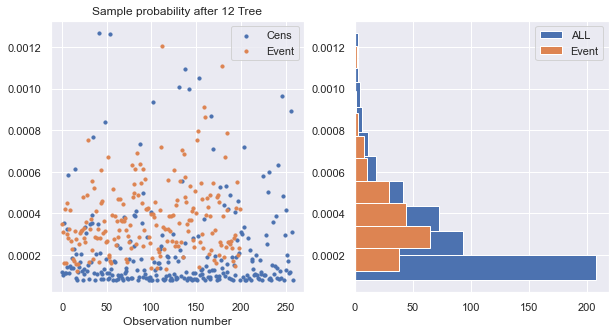

UNIQ INDEX: 196
UNIQ EVENT: 111
UNIQ CENS: 87


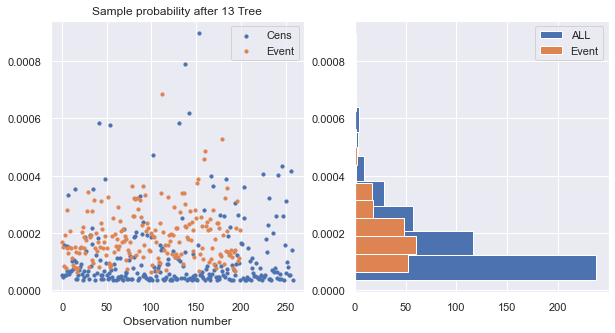

UNIQ INDEX: 196
UNIQ EVENT: 101
UNIQ CENS: 96


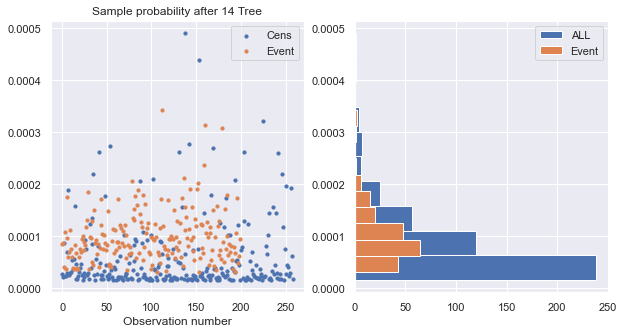

UNIQ INDEX: 207
UNIQ EVENT: 120
UNIQ CENS: 89


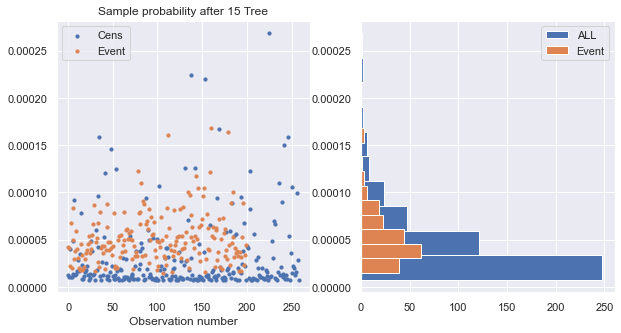

UNIQ INDEX: 196
UNIQ EVENT: 108
UNIQ CENS: 90


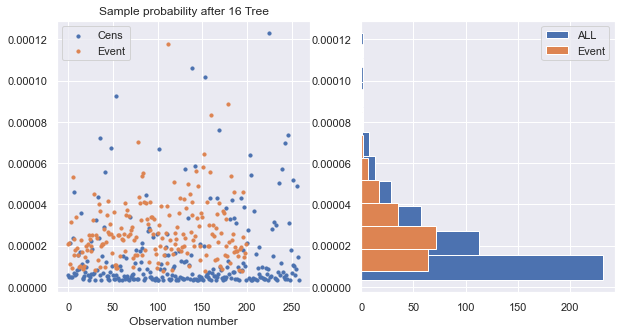

UNIQ INDEX: 198
UNIQ EVENT: 103
UNIQ CENS: 96


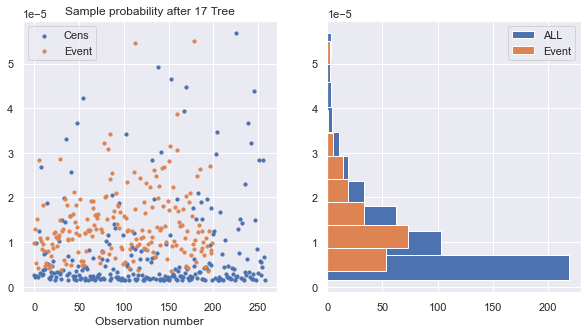

UNIQ INDEX: 187
UNIQ EVENT: 113
UNIQ CENS: 76


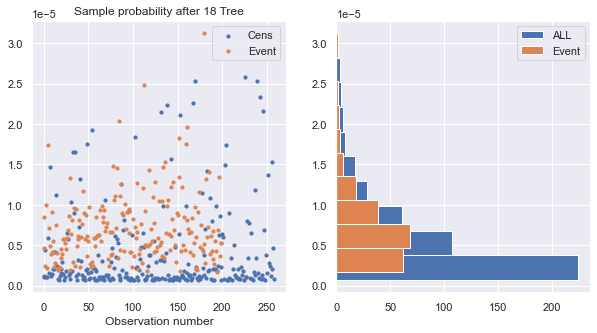

UNIQ INDEX: 188
UNIQ EVENT: 116
UNIQ CENS: 74


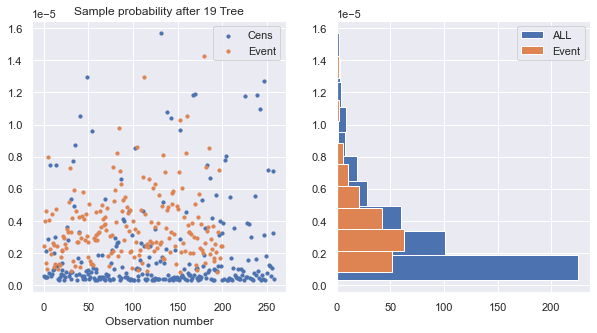

UNIQ INDEX: 196
UNIQ EVENT: 112
UNIQ CENS: 86


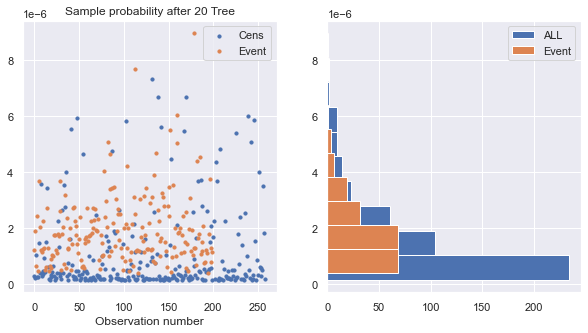

UNIQ INDEX: 183
UNIQ EVENT: 114
UNIQ CENS: 71


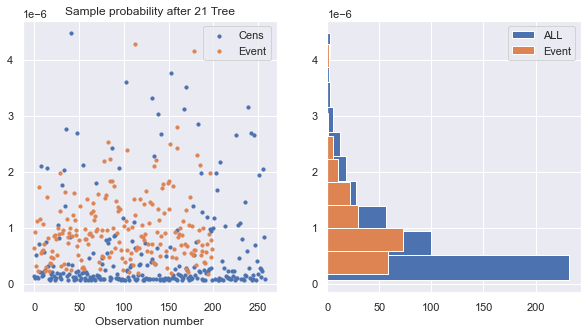

UNIQ INDEX: 190
UNIQ EVENT: 120
UNIQ CENS: 72


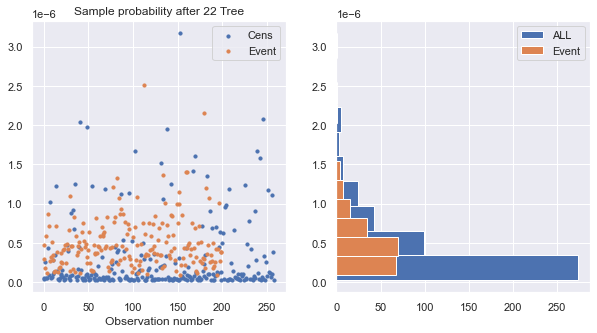

UNIQ INDEX: 182
UNIQ EVENT: 110
UNIQ CENS: 74


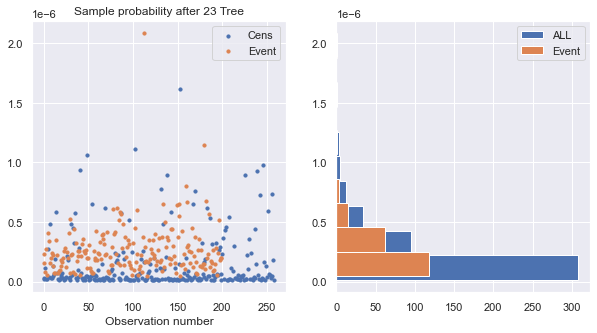

UNIQ INDEX: 179
UNIQ EVENT: 107
UNIQ CENS: 74


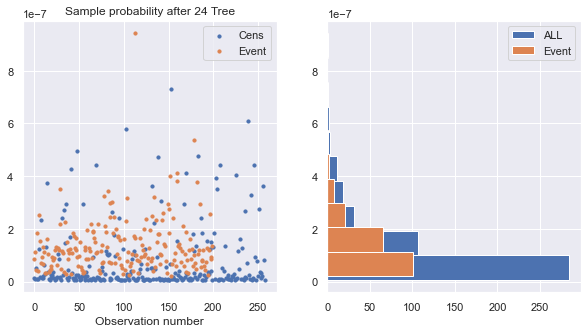

UNIQ INDEX: 182
UNIQ EVENT: 107
UNIQ CENS: 76


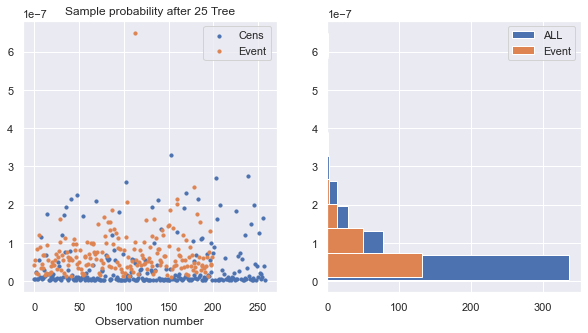

UNIQ INDEX: 174
UNIQ EVENT: 102
UNIQ CENS: 74


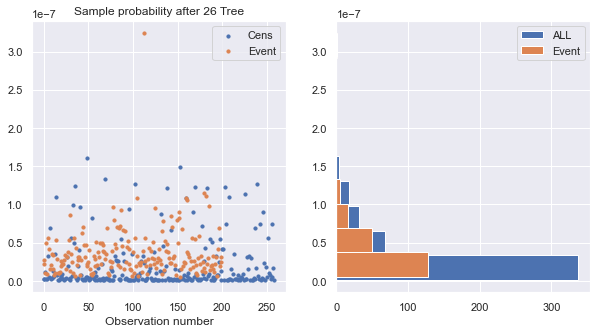

UNIQ INDEX: 176
UNIQ EVENT: 113
UNIQ CENS: 65


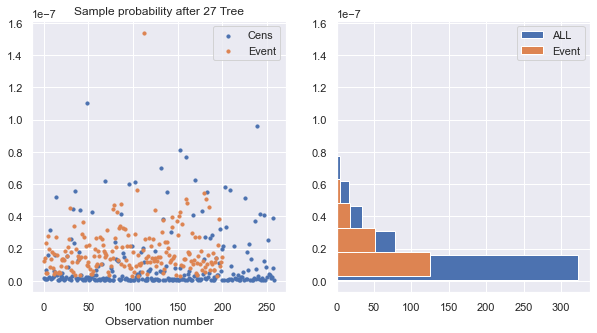

UNIQ INDEX: 171
UNIQ EVENT: 109
UNIQ CENS: 64


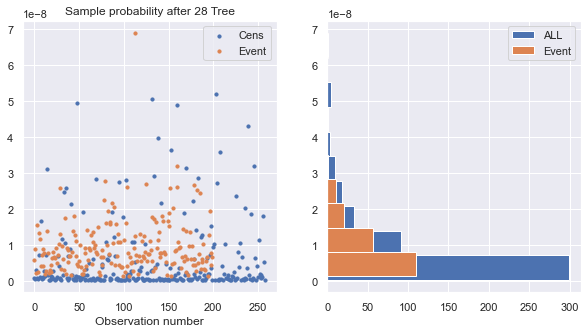

UNIQ INDEX: 180
UNIQ EVENT: 104
UNIQ CENS: 78


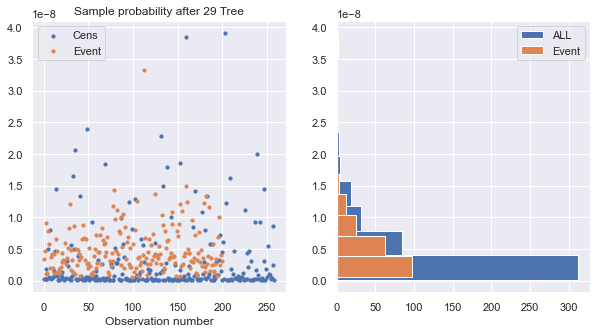

UNIQ INDEX: 175
UNIQ EVENT: 114
UNIQ CENS: 62


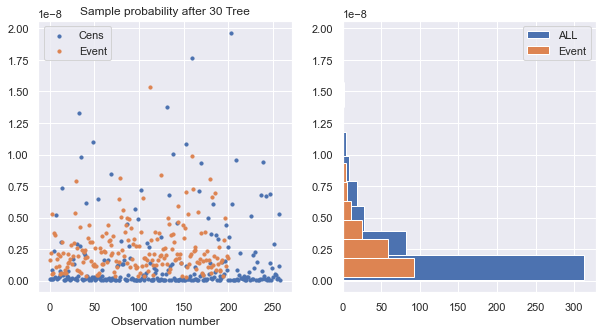

UNIQ INDEX: 172
UNIQ EVENT: 102
UNIQ CENS: 72


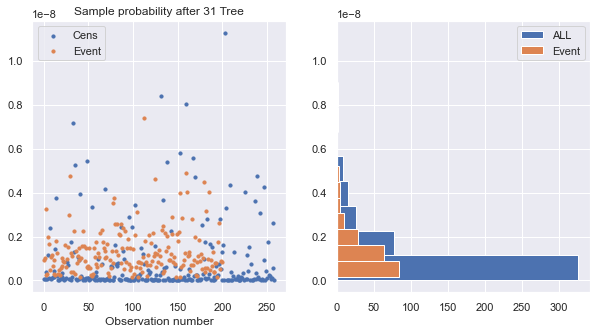

UNIQ INDEX: 170
UNIQ EVENT: 103
UNIQ CENS: 69


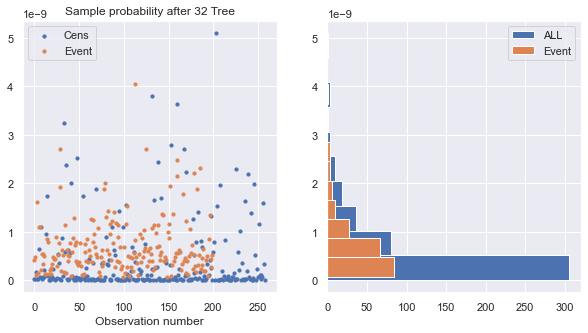

UNIQ INDEX: 171
UNIQ EVENT: 107
UNIQ CENS: 66


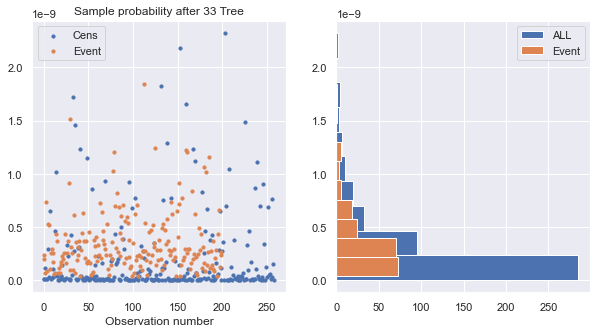

UNIQ INDEX: 170
UNIQ EVENT: 107
UNIQ CENS: 65


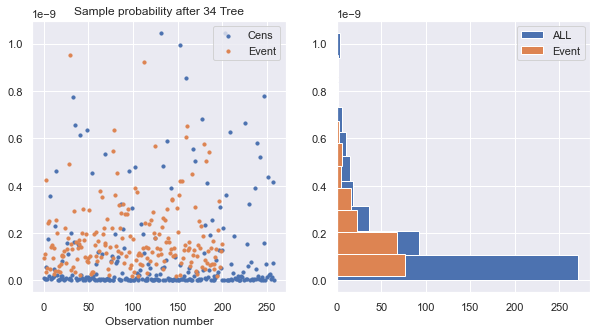

UNIQ INDEX: 174
UNIQ EVENT: 107
UNIQ CENS: 69


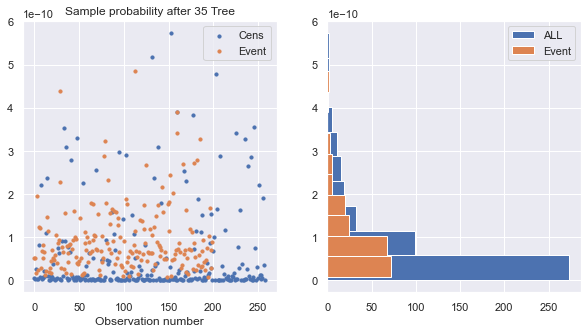

UNIQ INDEX: 164
UNIQ EVENT: 107
UNIQ CENS: 59


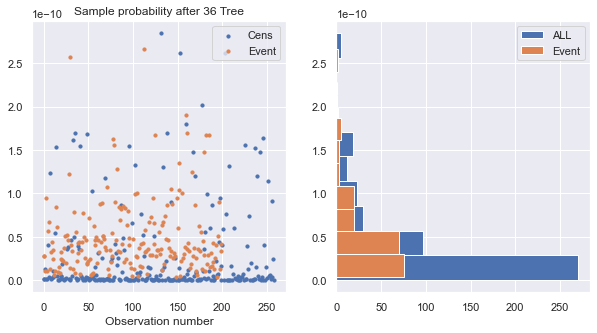

UNIQ INDEX: 176
UNIQ EVENT: 111
UNIQ CENS: 67


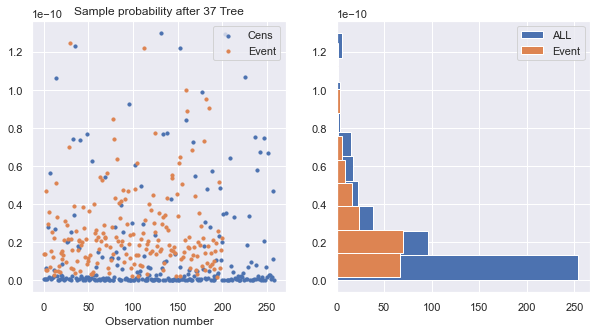

UNIQ INDEX: 162
UNIQ EVENT: 103
UNIQ CENS: 61


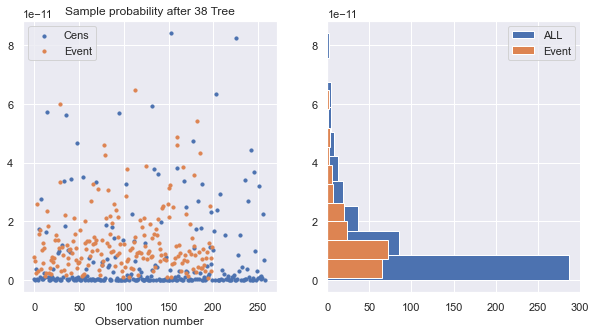

UNIQ INDEX: 176
UNIQ EVENT: 109
UNIQ CENS: 69


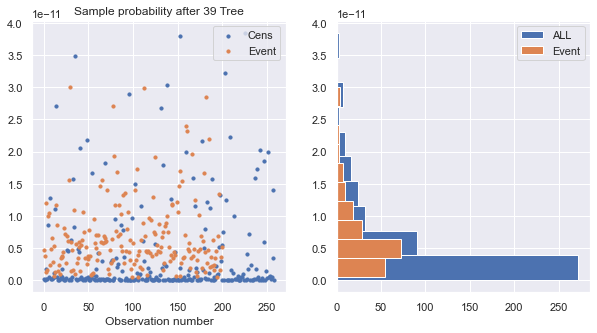

UNIQ INDEX: 148
UNIQ EVENT: 97
UNIQ CENS: 53


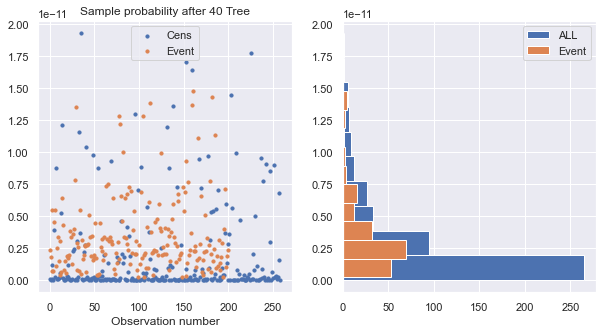

UNIQ INDEX: 171
UNIQ EVENT: 111
UNIQ CENS: 62


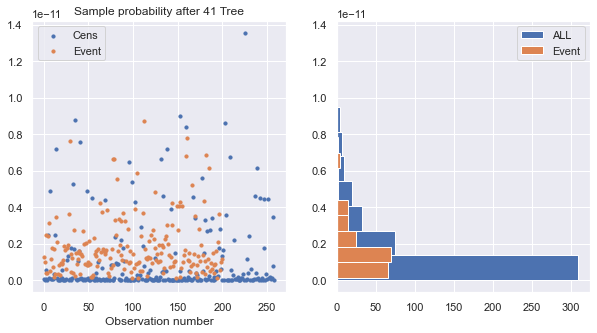

UNIQ INDEX: 163
UNIQ EVENT: 106
UNIQ CENS: 59


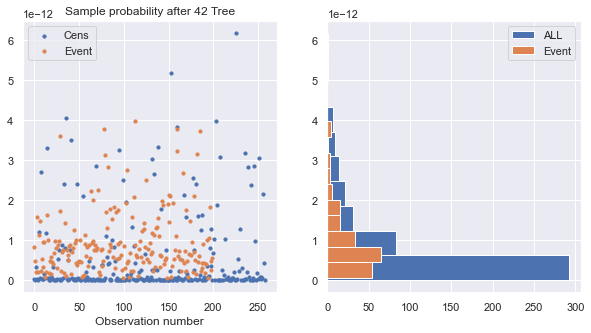

UNIQ INDEX: 159
UNIQ EVENT: 108
UNIQ CENS: 53


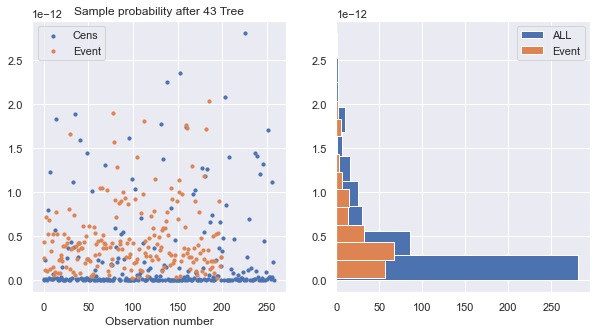

UNIQ INDEX: 164
UNIQ EVENT: 102
UNIQ CENS: 64


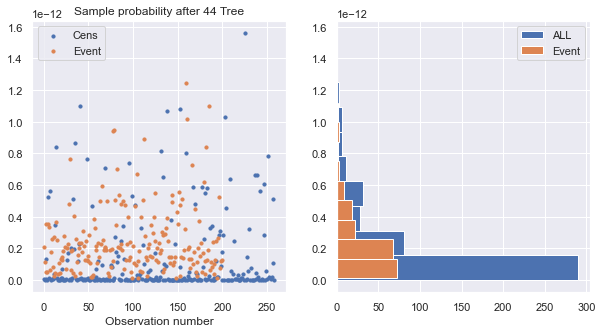

UNIQ INDEX: 160
UNIQ EVENT: 103
UNIQ CENS: 59


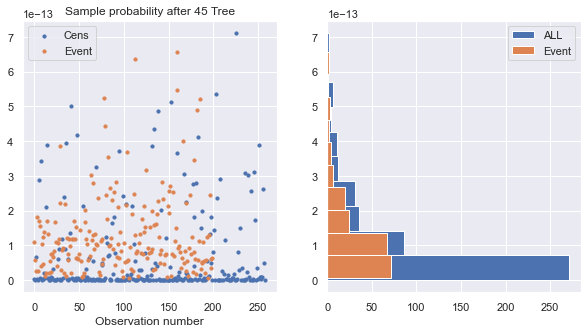

UNIQ INDEX: 154
UNIQ EVENT: 97
UNIQ CENS: 59


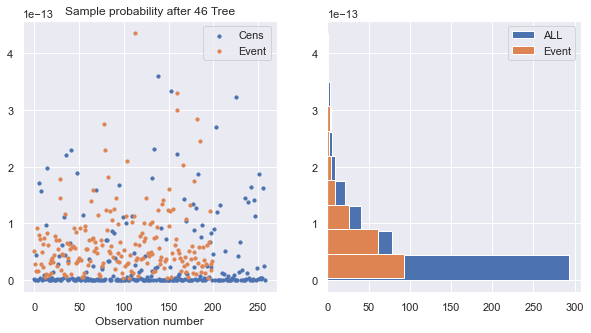

UNIQ INDEX: 160
UNIQ EVENT: 101
UNIQ CENS: 61


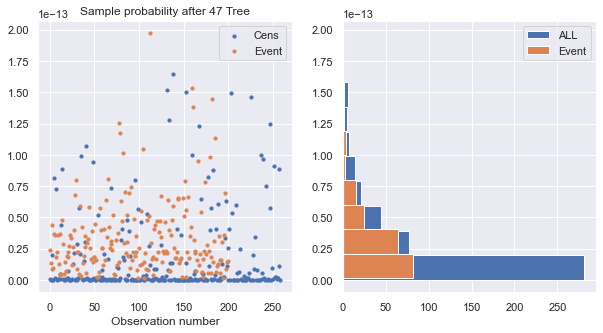

UNIQ INDEX: 160
UNIQ EVENT: 99
UNIQ CENS: 63


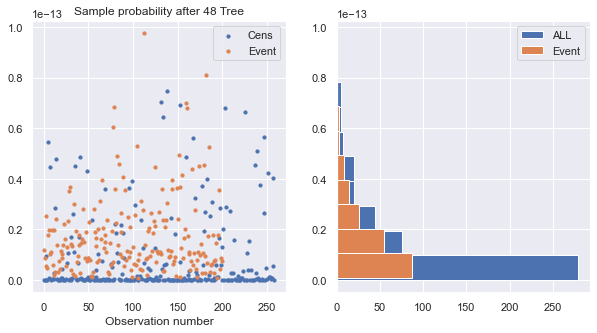

UNIQ INDEX: 163
UNIQ EVENT: 103
UNIQ CENS: 62


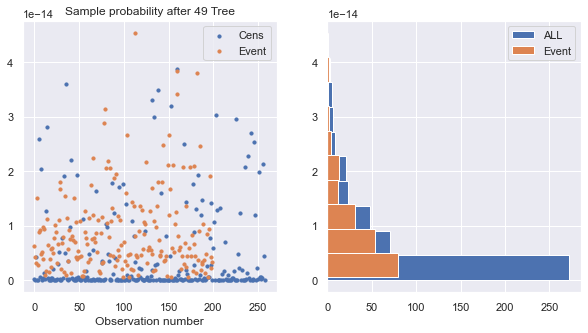

UNIQ INDEX: 164
UNIQ EVENT: 106
UNIQ CENS: 60


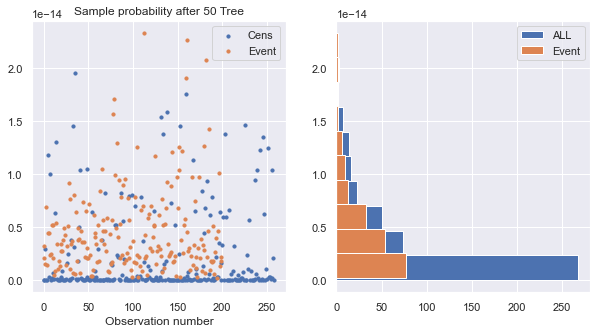

[10258.3342  8988.0553  8471.1633  8121.7403  7925.7828  7764.1914
  7629.8149  7435.2383  7335.1734  7203.0019  7081.1349  6963.5247
  6897.502   6830.9548  6773.7034  6676.2964  6622.4941  6578.4976
  6537.4254  6495.0742  6458.8035  6377.4014  6341.9865  6309.3071
  6277.5212  6248.6285  6221.0059  6194.2904  6167.7721  6143.1191
  6119.2686  6095.93    6074.9002  6055.5392  5984.0238  5917.9502
  5896.5221  5877.3835  5859.4967  5842.4184  5825.3233  5807.7492
  5793.2878  5777.0544  5759.9529  5744.6822  5728.555   5715.0704
  5702.2536  5647.7742]
fitted: 50 models.
55.26441669464111


In [3919]:
# DATASET ONK
# proboost_params = {
#  'balance': None, 
#  "with_arc": False,
#  'aggreg_func': 'wei', 'all_weight': True, 'categ': ['Диагноз'], 
#  'criterion': 'logrank', 'depth': 10, 'ens_metric_name': 'bic', 
#  'leaf_model': 'wei_survive', 'max_features': 0.7, 'min_samples_leaf': 5, 
#  'n_estimators': 30, 'n_jobs': 2, 'size_sample': 0.7
# }

proboost_params = {
 'balance': None, 
 "with_arc": False,
 'aggreg_func': 'wei', 'all_weight': True, 'categ': categ,
 'criterion': 'logrank', 'depth': 10, 'ens_metric_name': 'bic', 
 'leaf_model': 'base_fast', 'max_features': "sqrt", 'min_samples_leaf': 5, 
 'n_estimators': 50, 'n_jobs': 2, 'size_sample': 0.7
}

start_time = time.time()
proboost = Visualize(**proboost_params)
proboost.fit(X_tr, y_tr)

print(time.time() - start_time)

Prior distribution: [259 200]


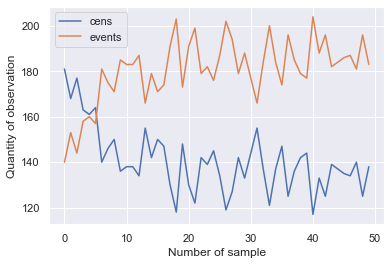

In [3920]:
print("Prior distribution:", np.bincount(y_tr["cens"]))
n_cens = []
n_events = []
for i in range(len(proboost.models)):
    distr = np.bincount(proboost.models[i].nodes[0].leaf_model.predict_list_feature(feature_name="cens"))
    n_cens.append(distr[0])
    n_events.append(distr[1])

plt.plot(n_cens, label="cens")
plt.plot(n_events, label="events")
plt.legend()
plt.ylabel("Quantity of observation")
plt.xlabel("Number of sample")
plt.show()

In [3921]:
pred_surv_proboost = proboost.predict_at_times(X_HO, bins=bins, mode="surv")
pred_time_proboost = proboost.predict(X_HO, target=cnt.TIME_NAME)
pred_haz_proboost = proboost.predict_at_times(X_HO, bins=bins, mode="hazard")

In [3922]:
# print("TRAIN GB:", metr.ibs(y_tr, y_tr, tr_pred_surv_gbsa, bins, axis=-1))
# print("TRAIN PR:", metr.ibs(y_tr, y_tr, tr_pred_surv_proboost, bins, axis=-1))

print("TEST GB:", metr.ibs(y_tr, y_HO, pred_surv_gbsa, bins, axis=-1))
print("TEST PR:", metr.ibs(y_tr, y_HO, pred_surv_proboost, bins, axis=-1))

ibs_gbsa_obs = metr.ibs(y_tr, y_HO, pred_surv_gbsa, bins, axis=0)
ibs_proboost_obs = metr.ibs(y_tr, y_HO, pred_surv_proboost, bins, axis=0)

TEST GB: 0.16857709818767394
TEST PR: 0.1782506581489566


In [3923]:
pred_surv_proboost_tr = proboost.predict_at_times(X_tr, bins=bins, mode="surv")
ibs_proboost_obs_tr = metr.ibs(y_tr, y_tr, pred_surv_proboost_tr, bins, axis=0)

In [3940]:
len(y_tr[proboost.weights < np.mean(proboost.weights)])

299

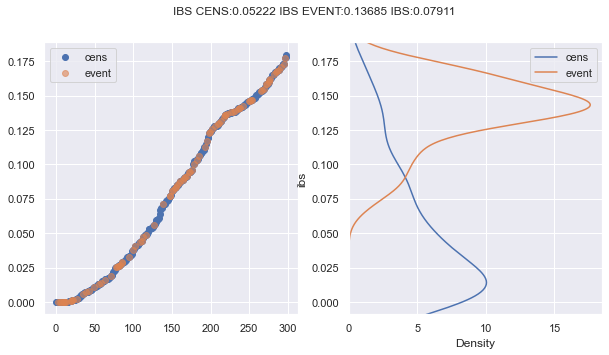

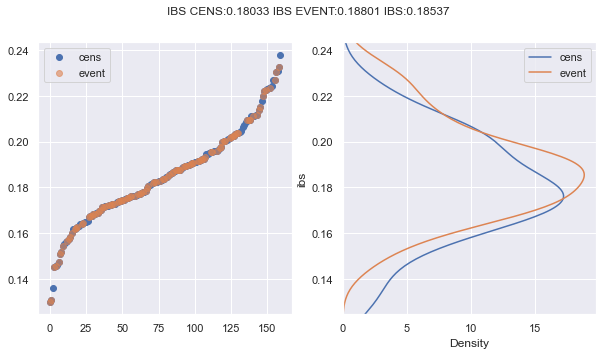

In [3942]:
plot_distr_ibs(y_tr[proboost.weights < np.mean(proboost.weights)], 
               ibs_proboost_obs_tr[proboost.weights < np.mean(proboost.weights)])
plot_distr_ibs(y_tr[proboost.weights >= np.mean(proboost.weights)], 
               ibs_proboost_obs_tr[proboost.weights >= np.mean(proboost.weights)])

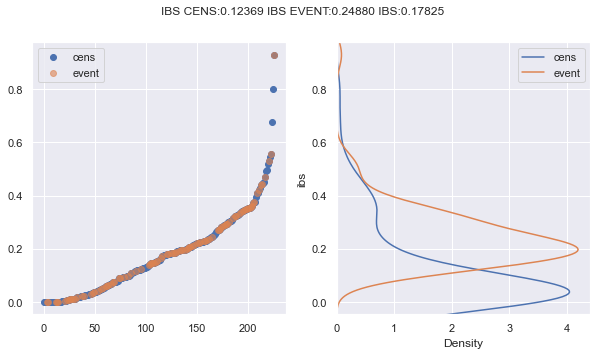

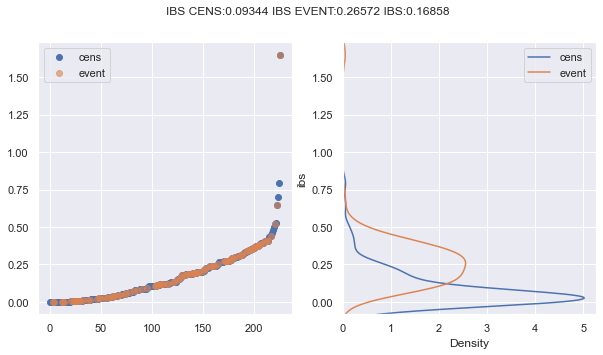

In [3941]:
def plot_distr_ibs(y_HO, ibs_scores):
    x_l = np.arange(len(ibs_scores))
    y_l = np.sort(ibs_scores)

    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    axes[0].scatter(x=x_l, y=y_l, label="cens")
    axes[0].scatter(x=x_l[y_HO["cens"]], y=y_l[y_HO["cens"]], label="event", alpha=0.6)
    axes[0].legend()

    sns_df = pd.DataFrame(ibs_scores, columns=["ibs"])

    sns.kdeplot(data=sns_df[~y_HO["cens"]], y="ibs", ax=axes[1], label="cens")
    sns.kdeplot(data=sns_df[y_HO["cens"]], y="ibs", ax=axes[1], label="event")
    axes[1].legend()
    
    ymin, ymax = axes[0].get_ylim()
    axes[1].set_ylim(ymin, ymax)
    fig.suptitle(f"IBS CENS:{np.mean(ibs_scores[~y_HO['cens']]):.5f} "\
              f"IBS EVENT:{np.mean(ibs_scores[y_HO['cens']]):.5f} "\
              f"IBS:{np.mean(ibs_scores):.5f}"
             )
    plt.show()

plot_distr_ibs(y_HO, ibs_proboost_obs)
plot_distr_ibs(y_HO, ibs_gbsa_obs)

In [3918]:
ibs_vec = ibs_gbsa_obs  # ibs_proboost_obs

print(">MEAN IBS:", np.bincount(y_HO[ibs_vec >= np.mean(ibs_vec)]["cens"]))
print("<MEAN IBS:", np.bincount(y_HO[ibs_vec < np.mean(ibs_vec)]["cens"]))

print(">EVENT IBS:", np.bincount(y_HO[ibs_vec >= np.mean(ibs_vec[y_HO["cens"]])]["cens"]))
print("<EVENT IBS:", np.bincount(y_HO[ibs_vec < np.mean(ibs_vec[y_HO["cens"]])]["cens"]))

print(">CENS IBS:", np.bincount(y_HO[ibs_vec >= np.mean(ibs_vec[~y_HO["cens"]])]["cens"]))
print("<CENS IBS:", np.bincount(y_HO[ibs_vec < np.mean(ibs_vec[~y_HO["cens"]])]["cens"]))

>MEAN IBS: [27 70]
<MEAN IBS: [101  29]
>EVENT IBS: [11 48]
<EVENT IBS: [117  51]
>CENS IBS: [38 93]
<CENS IBS: [90  6]


### Naive example of IBS disadvantage

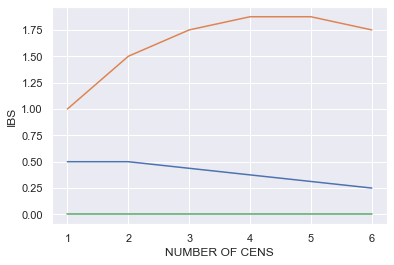

In [3992]:
dur = np.array([10, 50])
cens = np.array([0, 1])
ibs_vals = []
ibs_vals_event = []
ibs_vals_cens = []

for i in range(10, 40, 5):
    y_naive = cnt.get_y(cens=cens, time=dur)
    bins = np.unique(dur)
    s_t = np.ones_like(bins)
    y_pred_naive = np.repeat(s_t[np.newaxis, :], dur.shape[0], axis=0)
    ibs_vals.append(metr.ibs(y_naive, y_naive, y_pred_naive, bins, axis=-1))
    ibs_vals_event.append(metr.ibs(y_naive, y_naive[y_naive["cens"]], y_pred_naive[y_naive["cens"]], bins, axis=-1))
    ibs_vals_cens.append(metr.ibs(y_naive, y_naive[~y_naive["cens"]], y_pred_naive[~y_naive["cens"]], bins, axis=-1))
    dur = np.append(dur, i)
    cens = np.append(cens, 0)

plt.plot(range(1, len(ibs_vals)+1), ibs_vals, label="ibs")
plt.ylabel("IBS")
plt.xlabel("NUMBER OF CENS")
plt.plot(range(1, len(ibs_vals)+1),ibs_vals_event, label="event ibs")
plt.plot(range(1, len(ibs_vals)+1),ibs_vals_cens, label="cens ibs")
# plt.legend()
plt.show()

In [3993]:
ibs_vals_event

[1.0, 1.4999999999999998, 1.75, 1.875, 1.8749999999999996, 1.7499999999999996]

### HeatMap

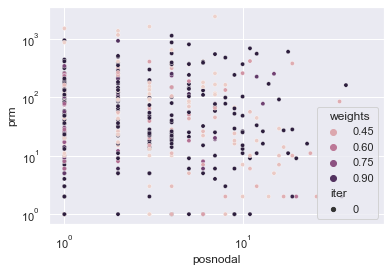

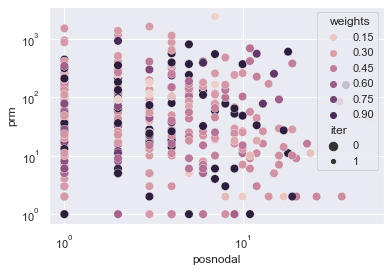

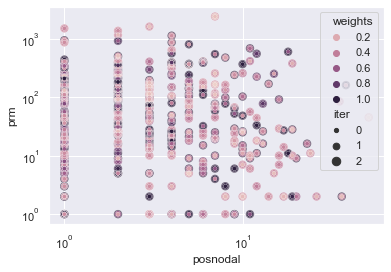

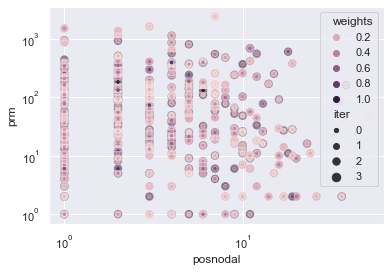

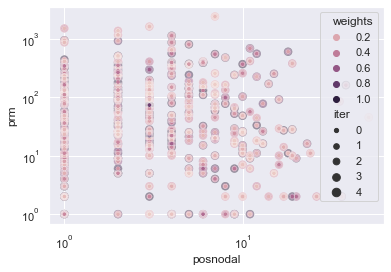

[10049.4575  8969.2313  8473.5017  8161.0781  7948.8878]
fitted: 5 models.


In [5572]:
def plot_heatmap(X):
    X["iter"] = np.max(X["iter"]) - X["iter"]
    # X["weights"] = ibs
#     X["flag_oob"] = flag_oob
    g = sns.scatterplot(data=X,
        x="posnodal", y="prm",
        hue="weights", size="iter")
#     cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
#     g = sns.relplot(
#         data=X,
#         x="posnodal", y="prm",
#         hue="ibs", size="flag_oob",
#         palette=cmap, sizes=(10, 200),
#     )
    g.set(xscale="log", yscale="log")
#     g.ax.xaxis.grid(True, "minor", linewidth=.25)
#     g.ax.yaxis.grid(True, "minor", linewidth=.25)
#     g.despine(left=True, bottom=True)
    plt.show()
    
class VisualizeHeat(IBSProbBoostingCRAID):
    def update_weight(self, index, wei_i):
        if len(self.bettas) == 1:
            self.scatter_x = []
        super().update_weight(index, wei_i)
        
        l = self.X_train.copy()
        l["weights"] = self.weights
        l["iter"] = len(self.bettas)
        self.scatter_x.append(l)
        
        self.visualize_weights(index)
    
    def visualize_weights(self, train_index):
        #pred_sf = self.predict_at_times(self.X_train, bins=self.bins, mode="surv")
        #ibs_vals = metr.ibs(self.y_train, self.y_train, pred_sf, self.bins, axis=0)
        #plot_heatmap(self.X_train, self.weights, self.X_train.index.isin(train_index))
        plot_heatmap(pd.concat(self.scatter_x))
        
proboost_params = {
 'balance': None, 
 "with_arc": False,
 'aggreg_func': 'wei', 'all_weight': False, 'categ': [],
 'criterion': 'logrank', 'depth': 10, 'ens_metric_name': 'bic', 
 'leaf_model': 'base_fast', 'max_features': 1.0, 'min_samples_leaf': 5, 
 'n_estimators': 5, 'n_jobs': 2, 'size_sample': 0.7
}

proboost = VisualizeHeat(**proboost_params)
proboost.fit(X_tr[["posnodal", "prm"]], y_tr)

In [5557]:
X_tr[["posnodal", "prm"]]

posnodal  prm
323         2  170
125         2   84
410         3   10
241         1    5
55          3    5
..        ...  ...
36         12    0
612         2    0
263        13    0
384         1  110
307         1   11

[459 rows x 2 columns]

### Visualizations only for PROBOOST

In [9]:
def loglikelihood_i(time, cens, sf, cumhf, bins):
    index_times = np.digitize(time, bins, right=True) - 1
    hf = np.hstack((cumhf[:, 0][np.newaxis].T, np.diff(cumhf)))
    sf_by_times = np.take_along_axis(sf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10
    hf_by_times = (np.take_along_axis(hf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10) ** cens
    return np.log(sf_by_times) + np.log(hf_by_times)


def values_to_hist(values):
    unq, idx = np.unique(values, return_inverse=True)
    # calculate the weighted frequencies of these indices
    freqs_idx = np.bincount(idx)
    # reconstruct the array of frequencies of the elements
    return freqs_idx[idx]


class VisProbBoostingCRAID(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "ProbBoostingCRAID"

    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train

        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        pred_hf = model.predict_at_times(X_sub, bins=self.bins, mode="hazard")

        time_hist = values_to_hist(y_sub["time"])
        lp_ti = np.log(time_hist / y_sub["time"].shape)
        lp_xi_ti = np.log(1 / time_hist)
        likel = loglikelihood_i(y_sub["time"], y_sub["cens"], pred_sf, pred_hf, self.bins)

        lp_xi = lp_ti + lp_xi_ti - likel
        wei = - np.exp(-lp_xi)
        betta = np.sum(likel)
        return wei, betta

    def update_weight(self, index, wei_i):
        if self.all_weight:
            self.weights = self.weights + wei_i
        else:
            self.weights[index] = (self.weights[index] + wei_i)
#         self.weights = (self.weights - self.weights.min()) / (self.weights.max() - self.weights.min())
        self.weights = (self.weights - self.weights.min())
        self.weights /= np.sum(self.weights)
        
        fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
        axes[0].scatter(np.arange(self.weights.shape[0]), 
                        self.weights,
                        c = np.where(self.y_train["cens"], "orange", "blue"))
        axes[1].hist(self.weights, orientation="horizontal")
        plt.show()

    def get_aggreg(self, x):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        elif self.aggreg_func == 'wei':
            inv_wei = -1/np.array(self.bettas)
            wei = inv_wei/sum(inv_wei)
            return np.sum((x.T*wei).T, axis=0)
        return np.mean(x, axis=0)
    
    def fit(self, X, y):
        self.features = X.columns
        X = X.reset_index(drop=True)
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)
        
        self.X_train = X
        self.X_train["ind_start"] = self.X_train.index
        self.y_train = y
        
        self.weights = np.ones(self.X_train.shape[0], dtype=float)
        self.bettas = []
        self.l_weights = []
        self.update_params()
        
        for i in range(self.n_estimators):
            prob_weights = self.weights  # arc_x4(self.weights)
            x_sub = self.X_train.sample(n=self.size_sample, weights=prob_weights,  # self.weights
                                        replace=self.bootstrap, random_state=i)
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]

            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_tr = cnt.pd_to_xy(x_sub)
            if self.weighted_tree:
                X_sub_tr["weights_obs"] = prob_weights[x_sub['ind_start']]  # self.weights

            model = CRAID(features=self.features, random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_tr)
            
            wei_i, betta_i = self.count_model_weights(model, X_sub_tr, y_sub_tr)
            self.add_model(model, x_oob, wei_i, betta_i)
            self.update_weight(x_sub['ind_start'], wei_i)
            
            # print(betta_i)
            self.ens_metr[i] = self.score_oob()
            
            if not (self.tolerance) and i > 0:
                print(f"METRIC: {self.ens_metr[i-1]} -> +1 model METRIC: {self.ens_metr[i]}")
                if self.descend_metr:
                    stop = self.ens_metr[i-1] < self.ens_metr[i]
                else:
                    stop = self.ens_metr[i-1] > self.ens_metr[i]
                if stop:
                    self.select_model(0, len(self.models)-1)
                    break
        
        if self.tolerance:
            self.tolerance_find_best()
        print('fitted:', len(self.models), 'models.')

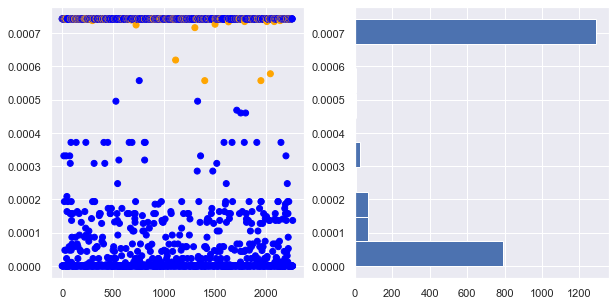

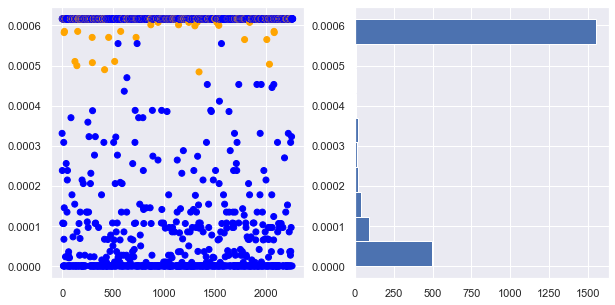

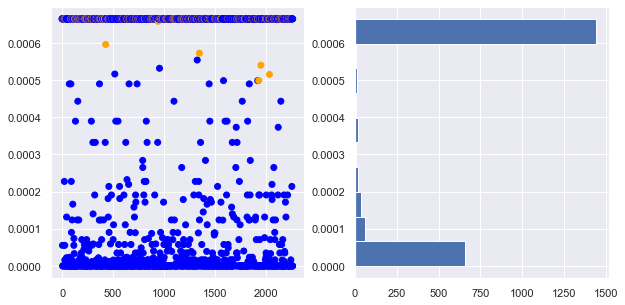

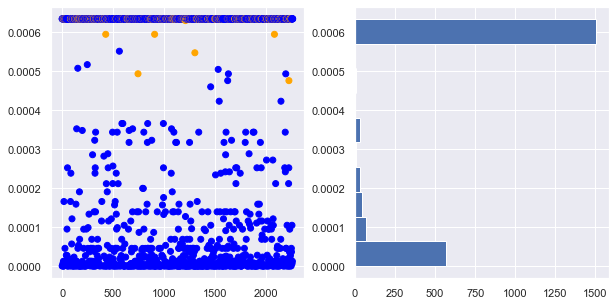

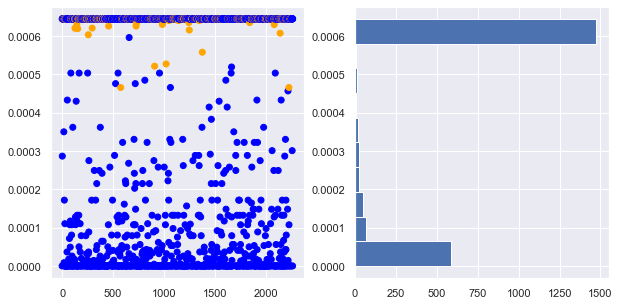

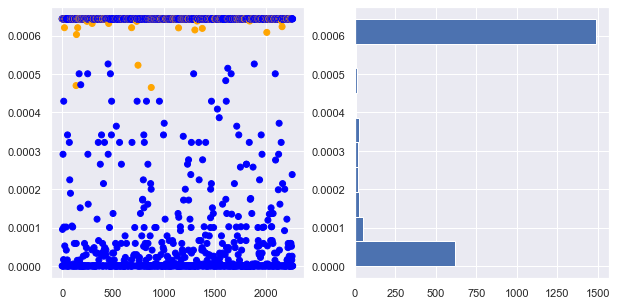

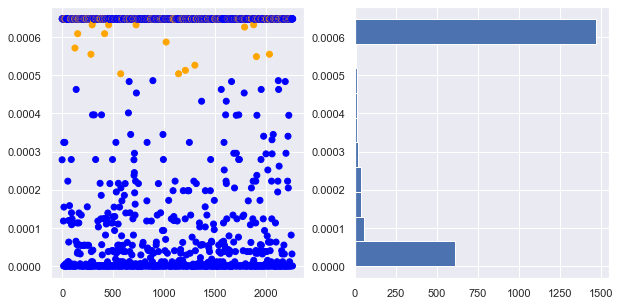

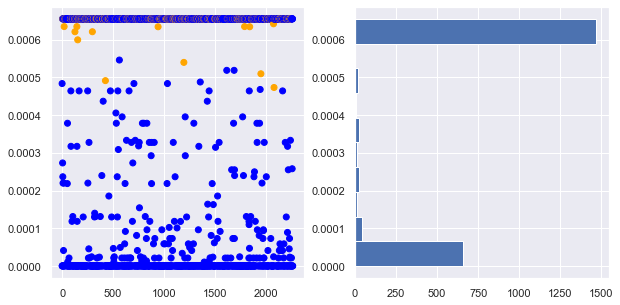

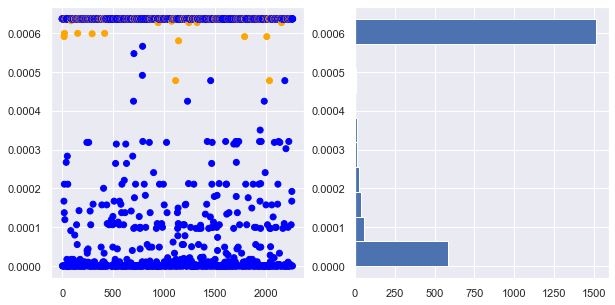

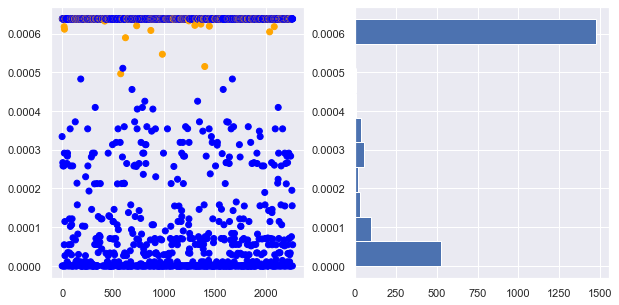

[0.2353 0.1782 0.1705 0.17   0.1646 0.16   0.1571 0.1528 0.1511 0.1486]
fitted: 10 models.


In [10]:
vproboost_params = {'aggreg_func': 'wei', 'all_weight': False, 'categ': ['Диагноз'], 
                   'criterion': 'weights', 'depth': 10, 'ens_metric_name': 'ibs', 
                   'leaf_model': 'base_fast', 'max_features': 0.7, 'min_samples_leaf': 1, 
                   'n_estimators': 10, 'n_jobs': 2, 'size_sample': 0.7}

vproboost = VisProbBoostingCRAID(**vproboost_params)
vproboost.fit(X_tr, y_tr)

In [11]:
vproboost_params = {'aggreg_func': 'wei', 'all_weight': False, 'categ': ['Диагноз'], 
                   'criterion': 'weights', 'depth': 10, 'ens_metric_name': 'ibs', 
                   'leaf_model': 'base_fast', 'max_features': 0.7, 'min_samples_leaf': 10, 
                   'n_estimators': 100, 'n_jobs': 2, 'size_sample': 0.7}

vproboost = BoostingCRAID(**vproboost_params)
vproboost.fit(X_tr, y_tr)

[0.2144 0.1889 0.1822 0.1747 0.165  0.1635 0.1577 0.1539 0.1541 0.1545
 0.1533 0.1512 0.1484 0.1482 0.147  0.1484 0.1477 0.1462 0.1456 0.146
 0.1472 0.1468 0.146  0.1456 0.1457 0.1455 0.1449 0.1451 0.1449 0.1447
 0.1451 0.1447 0.1442 0.144  0.1435 0.1438 0.1435 0.1442 0.1442 0.1442
 0.1443 0.1445 0.1444 0.1443 0.1443 0.1445 0.1446 0.1448 0.1445 0.1448
 0.1453 0.1455 0.1455 0.1452 0.1449 0.1451 0.1453 0.1457 0.1458 0.146
 0.1457 0.1456 0.1454 0.1457 0.1454 0.1455 0.1457 0.1455 0.1455 0.1456
 0.1453 0.1452 0.1453 0.1452 0.1451 0.1448 0.1448 0.1448 0.1447 0.145
 0.1447 0.1447 0.1445 0.1444 0.1443 0.1444 0.1445 0.1445 0.1444 0.1444
 0.1443 0.1443 0.1442 0.1441 0.1443 0.1443 0.1444 0.1444 0.1441 0.1441]
fitted: 35 models.


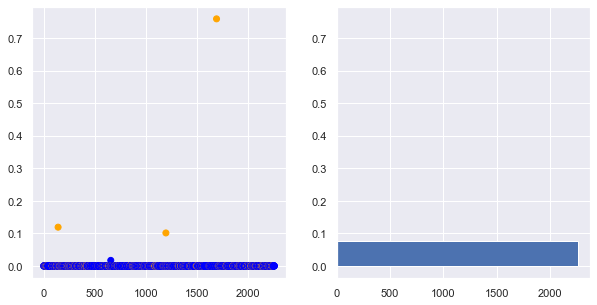

In [12]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
axes[0].scatter(np.arange(vproboost.weights.shape[0]), 
                vproboost.weights,
                c = np.where(vproboost.y_train["cens"], "orange", "blue"))
axes[1].hist(vproboost.weights, orientation="horizontal")
plt.show()

In [13]:
tr_pred_surv_boost = vproboost.predict_at_times(X_tr, bins=bins, mode="surv")
print("TRAIN emp GB:", metr.ibs(y_tr, y_tr, tr_pred_surv_boost, bins, axis=-1))

pred_surv_boost = vproboost.predict_at_times(X_HO, bins=bins, mode="surv")
print("TEST emp GB:", metr.ibs(y_tr, y_HO, pred_surv_boost, bins, axis=-1))


TRAIN emp GB: 0.09731145260444893
TEST emp GB: 0.14330786637613338


### Oversampling from imbalance

In [112]:
from imblearn.over_sampling import RandomOverSampler

In [115]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X, y["cens"])

In [120]:
np.bincount(y["cens"])

array([2856,  524], dtype=int64)

In [124]:
from imblearn.over_sampling import RandomOverSampler

def get_oversample(df, target=cnt.CENS_NAME):
    oversample = RandomOverSampler(sampling_strategy='minority')
    df_over, _ = oversample.fit_resample(df, df[target])
    return df_over

X_full = X.copy()
X_full[cnt.CENS_NAME] = y[cnt.CENS_NAME]
X_full[cnt.TIME_NAME] = y[cnt.TIME_NAME]

get_oversample(X_full, target=cnt.CENS_NAME)[cnt.CENS_NAME].value_counts()

False    2856
True     2856
Name: cens, dtype: int64

### SMOTE from imbalance

1. [Example](https://github.com/KhyatiMahendru/Balancing-data-SMOTE/blob/master/CreditCardFraudDetection.ipynb)
2. [Documentation](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC)
3. [Survival Analysis + SMOTE Usage (Improving the Prediction of Heart Failure Patients’ Survival Using SMOTE and Effective Data Mining Techniques)](https://github.com/deveshpatel0101/heart-failure-patients-survival/blob/master/notebooks/decision_tree_with_smote.ipynb)

In [128]:
def get_n(n):
    yield from range(n)
    
next(get_n(4))

0

In [96]:
categ

['Диагноз']

In [97]:
from imblearn.over_sampling import SMOTE

In [98]:
X_tr_1[categ].value_counts()

Диагноз
2          1503
1          1176
0          1147
dtype: int64

In [110]:
sm = SMOTE(random_state=42)

X_tr_smote = X_tr.copy()
X_tr_smote[cnt.TIME_NAME] = y_tr[cnt.TIME_NAME]
X_tr_1, y_tr_1 = sm.fit_resample(X_tr_smote.fillna(0).replace(np.nan, 0), y_tr[cnt.CENS_NAME])

y_tr_1 = cnt.get_y(y_tr_1, X_tr_1[cnt.TIME_NAME])
X_tr_1 = X_tr_1.drop(cnt.TIME_NAME, axis=1)

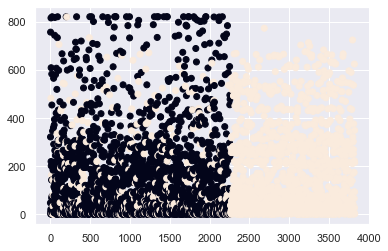

In [111]:
plt.scatter(np.arange(y_tr_1.shape[0]), 
            y_tr_1["time"], c = y_tr_1["cens"])

In [95]:
np.bincount(y_tr["cens"]), np.bincount(y_tr_1["cens"])

(array([1913,  351], dtype=int64), array([1913, 1913], dtype=int64))